In [1]:
import csv
import os
import re

import fiona
import matplotlib.pyplot as plt
import requests
import json
import pandas as pd
import numpy as np
from rich import print_json
from IPython.display import display
import seaborn
import geopandas

# Liste des labos INS2I
LISN = LISN + LIMSI + LRI
LS2N = LS2N + LINA + IRCCyN
LIS = LIS + LSIS + LIF


In [2]:
# les id des labos sont ceux qu'ils ont ou ont eus depuis 2016, cf. https://aurehal.archives-ouvertes.fr/structure/index
listeLabosINS2I=(("CMP",{244423}), ("CRAN",{185180,1001}), ("CREATIS",{139739}), ("CRIL",{90448,1628}), ("CRISTAL",{410272,389110,388977,390300,183073,111636,24885,2546,186929}), ("DI ENS",{25027}),("CROSSING (IRL)",{1063106}), ("ETIS",{1003474,1061575,1087906,1003348}), ("FILOFOCS (UMI)", {1006288,1006289}), ("GIPSA-Lab",{1043333,1042376,24470}), ("GREYC",{150}), ("G-SCOP",{1043137,1041927,74240}),("HEUDIASYC",{389870}), ("I3S",{13009, 552896, 1079434}),("ICUBE",{217648,1073080}), ("IDRIS",{1823}), ("IPAL  (IRL)", {542003,220880,138926}), ("IRIF",{1005016,444497}), ("IRISA",{491183,491231,490899,491188,1092618,491177,1092619,490900,419364,419370,105128,2494,25255,419365,419367,491230,419363,419366,491232,419362,1099404,545024,1099406,1099401,1099402,1099435, 525233, 1088566, 1088569, 495900, 489780, 1092631, 1092630, 1092628, 1092632, 1092626, 1092625, 1092629}), ("IRIT",{34499,1082335}), ("ISIR",{541937,96164}), ("JFLI",{542009,229050}), ("L2S",{1051117,1289}),("LAAS",{459}),("LABRI",{3102}), ("LAB-STICC",{486345,491660,199324,81533,1089048}), ("LAMIH",{1067790,1303}), ("LAMSADE",{989}), ("LIG",{1043301, 1041964,24471}),("LIGM",{1001627,3210}), ("LIMOS",{1063677,490706,857}),("LIP",{35418}),("LIP6",{541703,233,1095103}),("LIPN",{1000994,994,1086916,1056718}),("LIRIS",{2003,1086665}), ("LIRMM",{181,1071941}), ("LIS",{527033,199402,199394,862,178374}), ("LISN",{1061259,1041968,247329,2544,1050003,81750}), ("LIX",{2071,1041697,1071530,1070048}),("LMF",{1065710}), ("LORIA",{206040,466633}),("LS2N",{1088564,473973,95421,1693,21439}),("LMF-LSV",{1065710,1042689,2571}),("MDLS",{210816}),("RELAX",{1040410,528907}),("ROOT (IRL)", {389700}),("STMS",{541779,1374}), ("TIMA",{1043043,1044023,640}),("TIMC IMAG",{1043049,1070489,1042061,707,574002,555959,1056575}),("VERIMAG",{1043148,1041816,194}))
# notes:
# CRIStAL 2015 (Centre de Recherche en Informatique, Signal et Automatique de Lille) est une unité mixte de recherche (UMR 9189) résultant de la fusion du LAGIS (Laboratoire d’Automatique, Génie Informatique et Signal - UMR 8219) et du LIFL (Laboratoire d’Informatique Fondamentale de Lille - UMR 8022)
# IRISA : 4 new partners have joined IRISA to bring it to 750 people in 2015: ENS Cachan-Brittany (which became ENS Rennes in 2014), Université de Bretagne Sud (UBS), Telecom Bretagne and Supelec (which became CentraleSupelec in 2015)
# --> Laboratoire d'informatique des télécommunications (Institut Mines-Télécom-Télécom Bretagne-UEB) 438418 --> ne change rien
# --> IMT Atlantique Telecom Bretagne (481355) : Les équipes STACK et Gallinette sont en outre des équipes-centre Inria rattachées au centre Inria de Rennes - Bretagne Atlantique --> 525233, 1088566
# --> ITI Département lmage et Traitement Information (Brest) = 489781, 98037 --> change rien
# --> IMT Département Automatique, Productique et Informatique : 489559
# --> IMT Département Informatique : 489780
# --> IMT Département Systèmes Réseaux, Cybersécurité et Droit du numérique : 482801 --> change rien ; 491313, 220137 : change rien
# --> UBS Sécurité logicielle (IRISA) -- le reste informatique est au Lab-STICC
# --> UBS équipes ARCHWARE, CASA, EXPRESSION, OBELIX : 1003568, 203130, 399166, 1003569, 203131, 391086, 1092629, 255395, 1003580 : ne change rien
# --> ENS Cachan-Bretagne
# --> ENS Rennes : Celtique, KerData, LogicA, Myriads : 491212, 88187, 491076, 98001, 1003579, 234528, 490914, 106587 : change rien
# --> équipes :
# 1003581, 1003571, 491479, 491653, 491693, 491655, 543358, 1003568, 1124245, 491189, 1003579, 491207, 491208, 491212, 491215, 491210, 491314 : change rien
# 491414,491419, 560015, 491438, 1003575, 1003577 : change rien
# 1092631, 1092630, 1092628, 1092632, 1092626, 1092625, 1092629 : change rien

In [128]:
#liste réduite pour essais :
#listeLabosINS2I=(("CRISTAL",{410272}),("LORIA",{206040,466633}))
#listeLabosINS2I=(("LAB-STICC",{486345,491660,199324,81533,1089048}),("LIRIS",{2003,1086665}),("LIS",{527033,199402,199394,862,178374}))
listeLabosINS2I=(("CRISTAL",{410272}),("IRISA",{491183,491231,490899,491188,1092618,491177,1092619,490900,419364,419370,105128,2494,25255,419365,419367,491230,419363,419366,491232,419362,1099404,545024,1099406,1099401,1099402,1099435, 525233, 1088566, 1088569, 495900, 489780, 1092631, 1092630, 1092628, 1092632, 1092626, 1092625, 1092629}))

In [98]:
len(listeLabosINS2I)

2

In [3]:
listeCollectionsLabosINS2I=("CRAN", "CRIL", "CRISTAL", "ETIS", "GIPSA", "GREYC", "HEUDIASYC", "IPAL", "I3S", "IRIT", "IRISA", "ISIR", "UMI-3527", "LABRI", "LIP", "LAMIH", "LIMOS", "LPSM", "LAMSADE-DAUPHINE", "LS2N", "LAB-STICC", "G-SCOP", "LAAS", "LIG", "LIGM","LIX", "LIP6", "LIPN", "LIRIS", "LIRMM", "LIS-LAB", "LISN", "LORIA", "LMF", "SUP_LSS", "MDLS", "RELAX-AUTO", "ROOT-TOURS", "STMS", "TIMA", "VERIMAG")

In [14]:
#listeCollectionsLabosINS2I=("CRISTAL", "LORIA")

In [9]:
len(listeCollectionsLabosINS2I)

41

In [43]:
listeLabosINS2I

(('CMP', {244423}),
 ('CRAN', {185180}),
 ('CREATIS', {139739}),
 ('CRIL', {1628, 90448}),
 ('CRISTAL', {410272}),
 ('DI ENS', {25027}),
 ('ETIS', {1003348, 1003474, 1061575, 1087906}),
 ('GIPSA-Lab', {24470, 1042376, 1043333}),
 ('GREYC', {150}),
 ('G-SCOP', {74240, 1041927, 1043137}),
 ('HEUDIASYC', {389870}),
 ('I3S', {13009, 552896, 1079434}),
 ('ICUBE', {217648, 1073080}),
 ('IDRIS', {1823}),
 ('IRIF', {444497, 1005016}),
 ('IRISA', {2494, 8621, 105128, 490899}),
 ('IRIT', {34499, 1082335}),
 ('ISIR', {96164, 541937}),
 ('L2S', {1289, 1051117}),
 ('LAAS', {459}),
 ('LABRI', {3102}),
 ('LAB-STICC', {81533, 199324, 486345, 491660, 1089048}),
 ('LAMIH', {1303, 1067790}),
 ('LAMSADE', {989}),
 ('LIG', {24471, 1041964, 1043301}),
 ('LIGM', {3210, 1001627}),
 ('LIMOS', {857, 490706, 1063677}),
 ('LIP', {35418}),
 ('LIP6', {233, 541703, 1095103}),
 ('LIPN', {994, 1000994, 1056718, 1086916}),
 ('LIRIS', {2003, 1086665}),
 ('LIRMM', {181, 1071941}),
 ('LIS', {862, 178374, 199394, 199402, 5

# Liste des collections labos INRIA

In [ ]:
#https://hal.inria.fr/browse/collection
#collectionsINRIA =

# Récupération des initiales des noms de pays
Liste http://documentation.abes.fr/sudoc/formats/CodesPays.htm
en usage dans le Sudoc, s'appuie sur la liste des codes de pays ISO 3166-1 alpha-2.

In [4]:
initialesPays = pd.read_csv("./Pays.csv",sep=';',header=None,names=['Nom','Initiales','ISO'])
initialesPays.set_index('Nom',inplace=True)
initialesPays.head(30)

Initiales  ISO
Nom                                  
Afghanistan                   AF  AFG
Afrique du Sud                ZA  ZAF
Åland, Îles                   AX  NaN
Albanie                       AL  ALB
Algérie                       DZ  DZA
Allemagne                     DE  DEU
Allemagne de l'EST            DD  NaN
Andorre                       AD  NaN
Angola                        AO  AGO
Anguilla                      AI  NaN
Antarctique                   AQ  NaN
Antigua et Barbuda            AG  NaN
Antilles néerlandaises        AN  NaN
Arabie Saoudite               SA  SAU
Argentine                     AR  ARG
Arménie                       AM  ARM
Aruba                         AW  NaN
Australie                     AU  AUS
Autriche                      AT  AUT
Azerbaïdjan                   AZ  AZE
Bahamas                       BS  BHS
Bahrein                       BH  NaN
Bangladesh                    BD  BGD
Barbade                       BB  NaN
Bélarus                       BY  BLR
Belgique                      BE  BEL
Bélize                        BZ  BLZ
Bénin                         BJ  BEN
Bermudes                      BM  NaN
Bhoutan                       BT  BTN

## Essais de requêtes sur les contenus et les référentiels

In [4]:
def lanceRequete (collection, req):
    reponses = requests.get("https://api.archives-ouvertes.fr/search/"+collection+"/?q="+req)
    #print_json(json.dumps(json.loads(reponses.text), indent=3))
    print_json(json.dumps(json.loads(reponses.text), indent=3))

### les champs des requêtes :
option "fq" définit les filtres (par exemple une plage)
option "facet" définit les facettes qui permettent de ventiler les réponses en groupes


In [4]:
# Essai de requête
# valeur trouvée avant le 14 juin 2022 : 1047
# valeur trouvée le 14 juin 2022  17h : 486 !
# à 19h54 : 492 ; à 20h30 : 525 ; à 22h21 : 624 ;
# le 15.06 à 11h06 : 975, 17h03 : 988 ; 22h37 : 998
# le 16.06 à 20h31 : 1001
# le 21.06 à 10h24 : 1024
# le 22.06 à 17h21 : 1047 (OUF !)

recherche="structId_i:1042376&rows=10&fq=producedDateY_i:[2016 TO 2017]&wt=json"
reponses = requests.get("https://api.archives-ouvertes.fr/search/CNRS/?q="+recherche)
j = json.loads(reponses.text)
print("Nombre documents trouvés : ",j['response']['numFound'])

Nombre documents trouvés :  1047


In [95]:
recherche="LS2N&fl=label_s,code_s,parentType_s,docid,aliasDocid_i&wt=json"
reponses = requests.get("https://api.archives-ouvertes.fr/ref/structure/?q="+recherche)
j = json.loads(reponses.text)
print(json.dumps(j, indent=3))

{
   "response": {
      "numFound": 7,
      "start": 0,
      "numFoundExact": true,
      "docs": [
         {
            "docid": "1028564",
            "label_s": "LS2N NANTES FRA",
            "parentType_s": [
               "regrouplaboratory"
            ]
         },
         {
            "docid": "579887",
            "label_s": "Laboratoire des Sciences du Num\u00e9riques de Nantes [LS2N]"
         },
         {
            "docid": "579888",
            "label_s": "Laboratoire des Sciences du Num\u00e9rique de Nantes [LS2N]",
            "parentType_s": [
               "institution"
            ]
         },
         {
            "docid": "1057888",
            "label_s": "LS2N - Laboratoire des Sciences du Num\u00e9rique de Nantes"
         },
         {
            "aliasDocid_i": [
               1096532
            ],
            "docid": "1088564",
            "label_s": "Laboratoire des Sciences du Num\u00e9rique de Nantes [LS2N]",
            "parentType_s": [
 

## Nombre total de produits de la recherche dans HAL par labo selon l'id de structure, entre 2016 et 2020 compris

(obsolète) Nombre de publications par labo selon nom de structure

réponses mai 2022 :
('LIRIS', {2003})
labStructAcronym_s:LIRIS&fq=producedDateY_i:[2016 TO 2017]&rows=10&fl=label_s,keyword_s&indent=true&wt=json
Nombre documents trouvés :  801
('LIS', {527033, 199402, 199394})
labStructAcronym_s:LIS&fq=producedDateY_i:[2016 TO 2017]&rows=10&fl=label_s,keyword_s&indent=true&wt=json
Nombre documents trouvés :  330
('LAB-STICC', {486345})
labStructAcronym_s:LAB-STICC&fq=producedDateY_i:[2016 TO 2017]&rows=10&fl=label_s,keyword_s&indent=true&wt=json
Nombre documents trouvés :  0

réponses 14 juin 2022 :
('LAB-STICC', {199324, 1089048, 486345, 491660, 81533})
labStructAcronym_s:LAB-STICC&fq=producedDateY_i:[2016 TO 2017]&rows=10&fl=label_s,keyword_s&indent=true&wt=json
Nombre documents trouvés :  0
('LIRIS', {1086665, 2003})
labStructAcronym_s:LIRIS&fq=producedDateY_i:[2016 TO 2017]&rows=10&fl=label_s,keyword_s&indent=true&wt=json
Nombre documents trouvés :  271
('LIS', {199394, 178374, 527033, 199402, 862})
labStructAcronym_s:LIS&fq=producedDateY_i:[2016 TO 2017]&rows=10&fl=label_s,keyword_s&indent=true&wt=json
Nombre documents trouvés :  91


In [23]:
for labo in listeLabosINS2I:
    print(labo)
    recherche= "labStructAcronym_s:"+labo[0]+"&fq=producedDateY_i:[2016 TO 2017]&rows=10&fl=label_s,keyword_s&indent=true&wt=json"
    print(recherche)
    reponses = requests.get("https://api.archives-ouvertes.fr/search/CNRS/?q="+recherche)
    j = json.loads(reponses.text)
    print("Nombre documents trouvés : ",j['response']['numFound'])
    #print(reponses.text)

('LAB-STICC', {199324, 1089048, 486345, 491660, 81533})
labStructAcronym_s:LAB-STICC&fq=producedDateY_i:[2016 TO 2017]&rows=10&fl=label_s,keyword_s&indent=true&wt=json
Nombre documents trouvés :  0
('LIRIS', {1086665, 2003})
labStructAcronym_s:LIRIS&fq=producedDateY_i:[2016 TO 2017]&rows=10&fl=label_s,keyword_s&indent=true&wt=json
Nombre documents trouvés :  271
('LIS', {199394, 178374, 527033, 199402, 862})
labStructAcronym_s:LIS&fq=producedDateY_i:[2016 TO 2017]&rows=10&fl=label_s,keyword_s&indent=true&wt=json
Nombre documents trouvés :  91


In [21]:
def initStatsLabo ():
    npPublisLabo = list()
    for labo in listeLabosINS2I:
        npPublisLabo.append({"nom":labo[0]})
    #print(npPublisLabo)
    global statsLabo
    statsLabo = pd.DataFrame(npPublisLabo)
    statsLabo.set_index('nom',inplace=True)
    statsLabo["Total"]=0
    statsLabo["COMM"]=0
    statsLabo["ART"]=0
    statsLabo["THESE"]=0
    statsLabo["HDR"]=0
    statsLabo["COUV"]=0
    statsLabo["REPORT"]=0
    statsLabo["DOUV"]=0
    statsLabo["POSTER"]=0
    statsLabo["UNDEFINED"]=0
    statsLabo["OTHER"]=0
    statsLabo["LECTURE"]=0
    statsLabo["PATENT"]=0
    statsLabo["OUV"]=0
    statsLabo["SOFTWARE"]=0
    statsLabo["MEM"]=0
    statsLabo["PRESCONF"]=0
    statsLabo["SYNTHESE"]=0
    #statsLabo["REPORT_GMAST"]=0 #valeur nulle pour tous les labos
    statsLabo["OTHERREPORT"]=0
    statsLabo["VIDEO"]=0

In [39]:
# ici seul le total par labo est calculé
initStatsLabo()
for labo in listeLabosINS2I:
    print(labo)
    listeIds = "("
    premierId = True
    for id in labo[1]:
        if not premierId:
            listeIds += " OR "
        else:
            premierId = False
        listeIds += str(id)
    listeIds += ")"
    recherche= "structId_i:"+listeIds+"&fq=producedDateY_i:[2016 TO 2017]&rows=0&fl=label_s,keyword_s&indent=true&wt=json"
    reponses = requests.get("https://api.archives-ouvertes.fr/search/CNRS/?q="+recherche)
    j = json.loads(reponses.text)
    print("Nombre documents trouvés : ",j['response']['numFound'])
    statsLabo.loc[labo[0]]['Total'] += j['response']['numFound']
    #print(reponses.text)
#print(statsLabo)

('LIRIS', {2003})
Nombre documents trouvés :  787
('LIS', {527033, 199402, 199394})
Nombre documents trouvés :  736
('LAB-STICC', {199324, 1089048, 486345, 491660, 81533})
Nombre documents trouvés :  1469


In [8]:
initStatsLabo()
for labo in listeLabosINS2I:
    print(labo)
    listeIds = "("
    premierId = True
    for id in labo[1]:
        if not premierId:
            listeIds += " OR "
        else:
            premierId = False
        listeIds += str(id)
    listeIds += ")"
    recherche= "structId_i:"+listeIds+"&fq=producedDateY_i:[2016 TO 2020]&rows=0&indent=true&wt=json&facet=true&facet.pivot=docType_s"
    try:
        reponses = requests.get("https://api.archives-ouvertes.fr/search/CNRS/?q="+recherche, timeout=(300,300))
    except requests.ReadTimeout:
        print ("temps limite atteint")
    j = json.loads(reponses.text)
    #print(json.dumps(j, indent=3))
    for donnees in  j['facet_counts']['facet_pivot']['docType_s']:
        if donnees['value'] in statsLabo: #on ne conserve les stats que pour les types choisis à l'initialisation du dataframe
            statsLabo.loc[labo[0]][donnees['value']] += donnees['count']
    #print("Nombre documents trouvés : ",j['response']['numFound'])
    statsLabo.loc[labo[0]].Total += j['response']['numFound']
display(statsLabo)

('CMP', {244423})
('CRAN', {185180})
('CREATIS', {139739})
('CRIL', {90448, 1628})
('CRISTAL', {410272})
('DI ENS', {25027})
('ETIS', {1003474, 1087906, 1003348, 1061575})
('GIPSA-Lab', {1042376, 1043333, 24470})
('GREYC', {150})
('G-SCOP', {74240, 1043137, 1041927})
('HEUDIASYC', {389870})
('I3S', {552896, 13009, 1079434})
('ICUBE', {217648, 1073080})
('IDRIS', {1823})
('IRIF', {1005016, 444497})
('IRISA', {105128, 490899, 8621, 2494})
('IRIT', {34499, 1082335})
('ISIR', {541937, 96164})
('L2S', {1289, 1051117})


KeyboardInterrupt: 

In [47]:
statsLabo.to_csv("statsLaboParType.csv")

In [24]:
statsLabo = pd.read_csv("statsLaboParType.csv", index_col=0)

In [25]:
display(statsLabo)

Total  COMM   ART  THESE  HDR  COUV  REPORT  DOUV  POSTER  \
nom                                                                    
CMP            9     5     4      0    0     0       0     0       0   
CRAN        1938   950   732    107   10    52      16    25       7   
CREATIS     1455   573   678     83    3    15       1     4      74   
CRIL         305   220    46      7    2     8       2     8       0   
CRISTAL     2929  1506   903    145   13    71      51    33      44   
DI ENS      1053   526   219    109    1    14      31    13       6   
ETIS         586   300   187     29    4    19       2    11       6   
GIPSA-Lab   2446  1118   850    167    4    96      35    13      49   
GREYC        882   438   268     59    8    18       6    18      21   
G-SCOP       927   423   284     86    3    55      14     3      13   
HEUDIASYC    896   489   278     65    1    17       1    17      12   
I3S         1574   791   428     77   10    44      81    24      29   
ICUBE       2028   601   948    200    2    66      83    18      46   
IDRIS          8     2     2      0    0     0       2     0       0   
IRIF         674   253   245     48    4    14      13     7       2   
IRISA       5024  2625  1260    378   32   122     140    72     134   
IRIT        3587  1987   864    151   18   141      76    96      52   
ISIR         717   243   335     67    4    28       4    10       7   
L2S         2510  1252   957    110    5    51       6    13      23   
LAAS        3227  1431  1086    260   22    86      63    36      65   
LABRI       2394  1042   688    147   16    85     109    39      89   
LAB-STICC   3229  1721   933    247   14    71      25    15      95   
LAMIH       1839   802   718    110    1    91      38    36      26   
LAMSADE      797   315   302     38    0    52       5     3       1   
LIG         2463  1375   478    218    8    78      77    58      42   
LIGM        1041   467   379     70    5    36       7     7       9   
LIMOS       1170   498   438     61    2    57      15    14      15   
LIP         1196   532   366     66   11    27     103     9       7   
LIP6        2786  1507   690    190   12    82      77    60      33   
LIPN         477   185   161     52    1    36       2     7       2   
LIRIS       1815   837   531    164   11    72      44    39      32   
LIRMM       2878  1274   987    176   10    87      43    50      67   
LIS         1855   892   666     65    5    78      12    23      30   
LISN        3083  1561   869    189   11    81      65    59      81   
LIX          958   382   325     52    5    44      24    10       8   
LORIA       2930  1467   716    152   17   127     144    79      52   
LS2N        3396  1558  1095    176   23   205      54    53      58   
LSV          420   204   100     27    1    14      14     5       3   
MDLS         186    40   117      9    0     1       5     0       0   
STMS         847   386   233     31    4    84      13    19      17   
TIMA         609   395   121     49    2    13       0     2      11   
TIMC IMAG   1268   177   933     80    1    31       6     2       8   
VERIMAG      295   146    56     39    2    12      10     2       1   

           UNDEFINED  OTHER  LECTURE  PATENT  OUV  SOFTWARE  MEM  PRESCONF  \
nom                                                                          
CMP                0      0        0       0    0         0    0         0   
CRAN              16      4        0      12    7         0    0         0   
CREATIS            7      4        5       8    0         0    0         0   
CRIL               5      1        0       0    4         2    0         0   
CRISTAL           96     19        3       6   30         0    4         4   
DI ENS           113      4        1       2    7         1    3         3   
ETIS              17      2        1       5    2         0    1         0   
GIPSA-Lab         51     19        0      13   10        10    9    

In [23]:
def initStatsLaboCollections ():
    npPublisLabo = list()
    for labo in listeCollectionsLabosINS2I:
        npPublisLabo.append({"nom":labo})
    #print(npPublisLabo)
    global statsLabo
    statsLabo = pd.DataFrame(npPublisLabo)
    statsLabo.set_index('nom',inplace=True)
    statsLabo["Total"]=0
    statsLabo["COMM"]=0
    statsLabo["ART"]=0
    statsLabo["THESE"]=0
    statsLabo["HDR"]=0
    statsLabo["COUV"]=0
    statsLabo["REPORT"]=0
    statsLabo["DOUV"]=0
    statsLabo["POSTER"]=0
    statsLabo["UNDEFINED"]=0
    statsLabo["OTHER"]=0
    statsLabo["LECTURE"]=0
    statsLabo["PATENT"]=0
    statsLabo["OUV"]=0
    statsLabo["SOFTWARE"]=0
    statsLabo["MEM"]=0
    statsLabo["PRESCONF"]=0
    statsLabo["SYNTHESE"]=0
    #statsLabo["REPORT_GMAST"]=0 #valeur nulle pour tous les labos
    statsLabo["OTHERREPORT"]=0
    statsLabo["VIDEO"]=0
# Même code que ci-dessus mais avec les collections de labo et non pas les IDs
initStatsLaboCollections()
for labo in listeCollectionsLabosINS2I:
    print(labo)
    recherche= "*:*&fq=producedDateY_i:[2016 TO 2020]&rows=0&indent=true&wt=json&facet=true&facet.pivot=docType_s"
    requete = "https://api.archives-ouvertes.fr/search/"+labo+"/?q="+recherche
    print(requete)
    try:
        reponses = requests.get(requete, timeout=(300,300))
    except requests.ReadTimeout:
        print ("temps limite atteint")
    j = json.loads(reponses.text)
    #print(json.dumps(j, indent=3))
    for donnees in  j['facet_counts']['facet_pivot']['docType_s']:
        if donnees['value'] in statsLabo: #on ne conserve les stats que pour les types choisis à l'initialisation du dataframe
            statsLabo.loc[labo][donnees['value']] += donnees['count']
    #print("Nombre documents trouvés : ",j['response']['numFound'])
    statsLabo.loc[labo].Total += j['response']['numFound']
display(statsLabo)

CRAN
https://api.archives-ouvertes.fr/search/CRAN/?q=*:*&fq=producedDateY_i:[2016 TO 2020]&rows=0&indent=true&wt=json&facet=true&facet.pivot=docType_s
CRIL
https://api.archives-ouvertes.fr/search/CRIL/?q=*:*&fq=producedDateY_i:[2016 TO 2020]&rows=0&indent=true&wt=json&facet=true&facet.pivot=docType_s
CRISTAL
https://api.archives-ouvertes.fr/search/CRISTAL/?q=*:*&fq=producedDateY_i:[2016 TO 2020]&rows=0&indent=true&wt=json&facet=true&facet.pivot=docType_s
ETIS
https://api.archives-ouvertes.fr/search/ETIS/?q=*:*&fq=producedDateY_i:[2016 TO 2020]&rows=0&indent=true&wt=json&facet=true&facet.pivot=docType_s
GIPSA
https://api.archives-ouvertes.fr/search/GIPSA/?q=*:*&fq=producedDateY_i:[2016 TO 2020]&rows=0&indent=true&wt=json&facet=true&facet.pivot=docType_s
GREYC
https://api.archives-ouvertes.fr/search/GREYC/?q=*:*&fq=producedDateY_i:[2016 TO 2020]&rows=0&indent=true&wt=json&facet=true&facet.pivot=docType_s
HEUDIASYC
https://api.archives-ouvertes.fr/search/HEUDIASYC/?q=*:*&fq=producedDateY_

Total  COMM   ART  THESE  HDR  COUV  REPORT  DOUV  POSTER  \
nom                                                                           
CRAN               1924   947   726    107   10    51      15    24       6   
CRIL                307   220    47      7    2     8       2     9       0   
CRISTAL            3058  1544   971    155   14    72      52    33      44   
ETIS                589   302   188     29    4    19       2    11       6   
GIPSA              2438  1118   849    170    4    96      34    13      49   
GREYC               860   429   256     58    8    18       6    18      21   
HEUDIASYC           887   481   278     65    1    17       1    17      12   
IPAL                 56    31    19      5    0     1       0     0       0   
I3S                1575   795   426     76   10    44      81    24      29   
IRIT               3588  1987   864    152   18   141      76    96      52   
IRISA              5077  2647  1281    382   32   122     141    72     134   
ISIR                737   248   345     67    5    31       4    10       7   
UMI-3527             73    49    16      0    0     2       1     1       0   
LABRI                13     4     7      1    0     0       0     1       0   
LIP                   6     2     2      0    0     0       0     1       0   
LAMIH              1850   805   727    110    1    91      38    35      26   
LIMOS              1175   500   439     61    2    57      15    14      15   
LPSM                741    25   371     73    1     3       1     5       2   
LAMSADE-DAUPHINE    798   315   303     38    0    52       5     3       1   
LS2N               2826  1301   893    145   20   181      38    47      47   
LAB-STICC          3239  1728   934    247   14    71      25    15      95   
G-SCOP              929   423   285     87    3    55      14     3      13   
LAAS               3248  1442  1087    263   22    86      66    36      66   
LIG                2484  1384   484    221    8    78      77    59      43   
LIGM               1058   477   388     70    5    34       8     7       9   
LIX                 960   382   325     52    5    44      24    10       8   
LIP6               2786  1507   690    190   12    82      77    60      33   
LIPN                479   185   162     53    1    35       2     7       2   
LIRIS              1816   837   531    164   11    72      44    39      32   
LIRMM              2901  1281  1000    177   10    87      44    50      67   
LIS-LAB            1843   892   659     59    5    78      12    23      30   
LISN               2254  1166   649     97   10    68      37    47      74   
LORIA              2933  1466   717    153   17   127     144    79      52   
LMF                   9     5     1      0    0     3       0     0       0   
SUP_LSS            2550  1266   978    113    5    51       6    13      25   
MDLS                186    40   117      9    0     1       5     0       0   
RELAX-AUTO            9     3     2      0    0     2       0     2       0   
ROOT-TOURS          187   107    41     14    0     8       2     1       0   
STMS                851   386   234     33    4    84      13    19      17   
TIMA                623   404   125     49    2    13       0     2      11   
VERIMAG             295   146    56     39    2    12      10     2       1   

                  UNDEFINED  OTHER  LECTURE  PATENT  OUV  SOFTWARE  MEM  \
nom                                                                       
CRAN                     14      4        0      12    8         0    0   
CRIL                      5      1        0       0    4         2    0   
CRISTAL                 106     19        3       6   30         0    4   
ETIS                     17      2        1       5    2         0    1   
GIPSA                    51     19        0      13   10        10    0   
GREYC                    20      7        0       4   11         4    0   
HEUDIASYC           

## Nombre de publications par labo et par année de production de l'article

In [91]:
statsParAnneeLabo = pd.DataFrame()
for labo in listeLabosINS2I:
    print(labo)
    anneeDebut = 2016
    anneeFin = 2021
    evolutionLabo = pd.DataFrame()
    for x in range(anneeDebut,anneeFin+1):
        data = {
            "Année" : [x],
            "Nom":labo[0],
            "Total" : [0],
            "COMM" : [0],
            "ART" : [0],
            "COUV" : [0],
            "DOUV" : [0],
            "OUV" : [0],
            "THESE" : [0],
            "HDR" : [0]
        }
        evolutionLabo = pd.concat([evolutionLabo, pd.DataFrame(data)], ignore_index=True)
    evolutionLabo.set_index(['Année'], inplace=True)
    listeIds = "("
    premierId = True
    for id in labo[1]:
        if not premierId:
            listeIds += " OR "
        else:
            premierId = False
        listeIds += str(id)
    listeIds += ")"
    recherche= "structId_i:"+listeIds+"&fq=producedDateY_i:[2016 TO 2021]&rows=0&indent=true&wt=json&facet=true&facet.pivot=producedDateY_i,docType_s"
    try:
        reponses = requests.get("https://api.archives-ouvertes.fr/search/CNRS/?q="+recherche, timeout=(300,300))
    except requests.ReadTimeout:
        print ("temps limite atteint")
    j = json.loads(reponses.text)
    #print(json.dumps(j, indent=3))
    for donnees in  j['facet_counts']['facet_pivot']['producedDateY_i,docType_s']:
        annee = donnees['value']
        #print (annee, " : ")
        for statsAnnee in donnees['pivot']:
            if statsAnnee['value'] in evolutionLabo:
                #print (statsAnnee['value']," : ",statsAnnee['count'])
                evolutionLabo.loc[annee,statsAnnee['value']] += statsAnnee['count'] #addition pour tenir compte des différents ids des labos
                evolutionLabo.loc[annee,'Total'] += statsAnnee['count']
    #display(evolutionLabo)
    statsParAnneeLabo = pd.concat([statsParAnneeLabo, evolutionLabo])
display(statsParAnneeLabo)

('CMP', {244423})
('CRAN', {185180})
('CREATIS', {139739})
('CRIL', {90448, 1628})
('CRISTAL', {410272})
('DI ENS', {25027})
('CROSSING (IRL)', {1063106})
('ETIS', {1003474, 1087906, 1003348, 1061575})
('FILOFOCS (UMI)', {1006288, 1006289})
('GIPSA-Lab', {1042376, 1043333, 24470})
('GREYC', {150})
('G-SCOP', {74240, 1043137, 1041927})
('HEUDIASYC', {389870})
('I3S', {552896, 13009, 1079434})
('ICUBE', {217648, 1073080})
('IDRIS', {1823})
('IPAL  (IRL)', {220880, 542003, 138926})
('IRIF', {1005016, 444497})
('IRISA', {1098246, 25255, 105128, 1099401, 1099402, 1099435, 1099404, 8621, 1099406, 490899, 1099479, 2494})
('IRIT', {34499, 1082335})
('ISIR', {541937, 96164})
('JFLI', {542009, 229050})
('L2S', {1289, 1051117})
('LAAS', {459})
('LABRI', {3102})
('LAB-STICC', {199324, 1089048, 486345, 491660, 81533})
('LAMIH', {1067790, 1303})
('LAMSADE', {989})
('LIG', {1041964, 1043301, 24471})
('LIGM', {3210, 1001627})
('LIMOS', {857, 490706, 1063677})
('LIP', {35418})
('LIP6', {233, 541703, 10

Nom  Total  COMM  ART  COUV  DOUV  OUV  THESE  HDR
Année                                                        
2016       CMP      2     1    1     0     0    0      0    0
2017       CMP      5     2    3     0     0    0      0    0
2018       CMP      2     2    0     0     0    0      0    0
2019       CMP      0     0    0     0     0    0      0    0
2020       CMP      0     0    0     0     0    0      0    0
...        ...    ...   ...  ...   ...   ...  ...    ...  ...
2017   VERIMAG     50    27   11     0     1    0     11    0
2018   VERIMAG     60    32   13     2     1    2     10    0
2019   VERIMAG     50    25   11     5     0    3      6    0
2020   VERIMAG     37    22    7     2     0    0      5    1
2021   VERIMAG     35    19    8     4     0    0      3    1

[300 rows x 9 columns]

In [98]:
statsParAnneeLabo.to_csv("StatsParAnneeLabo.csv")

In [50]:
statsParAnneeLabo = pd.read_csv("StatsParAnneeLabo.csv", index_col=0)

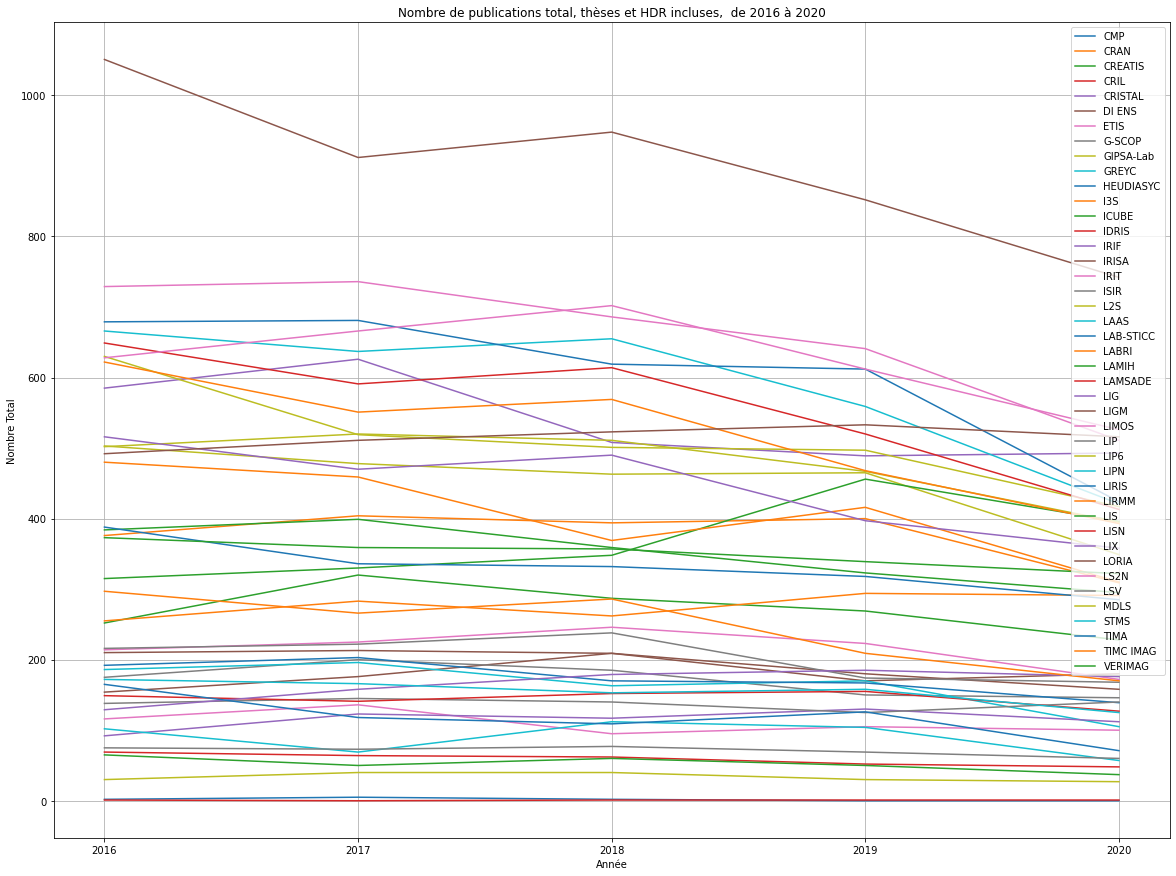

In [51]:
statsParAnneeLabo.groupby('Nom')['Total'].plot(title='Nombre de publications total, thèses et HDR incluses,  de 2016 à 2020',figsize=(20,15))
plt.xticks(np.arange(2016,2021,step=1))
plt.ylabel("Nombre Total")
plt.legend()
plt.grid(True)

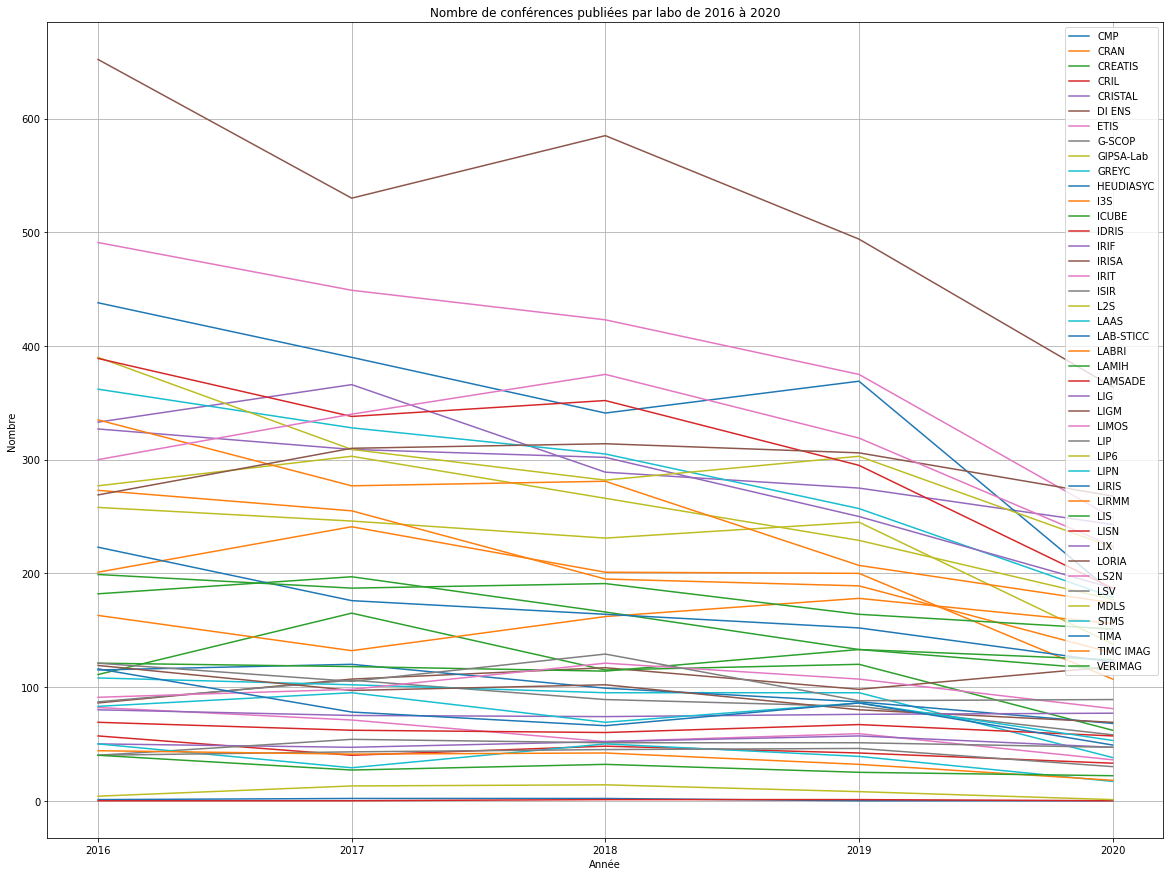

In [52]:
statsParAnneeLabo.groupby('Nom')['COMM'].plot(title='Nombre de conférences publiées par labo de 2016 à 2020',figsize=(20,15))
plt.xticks(np.arange(2016,2021,step=1))
plt.ylabel("Nombre")
plt.legend()
plt.grid(True)

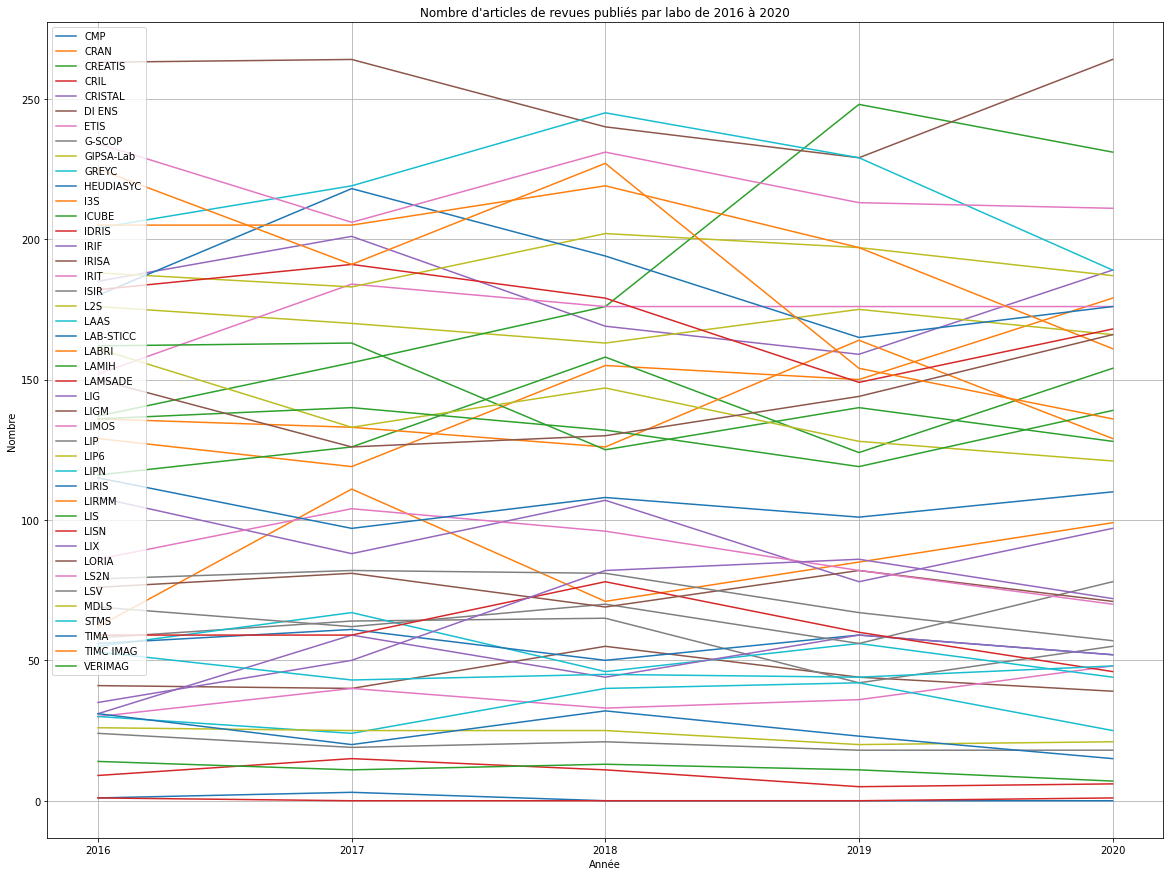

In [53]:
statsParAnneeLabo.groupby('Nom')['ART'].plot(title="Nombre d'articles de revues publiés par labo de 2016 à 2020",figsize=(20,15))
plt.xticks(np.arange(2016,2021,step=1))
plt.ylabel("Nombre")
plt.legend()
plt.grid(True)

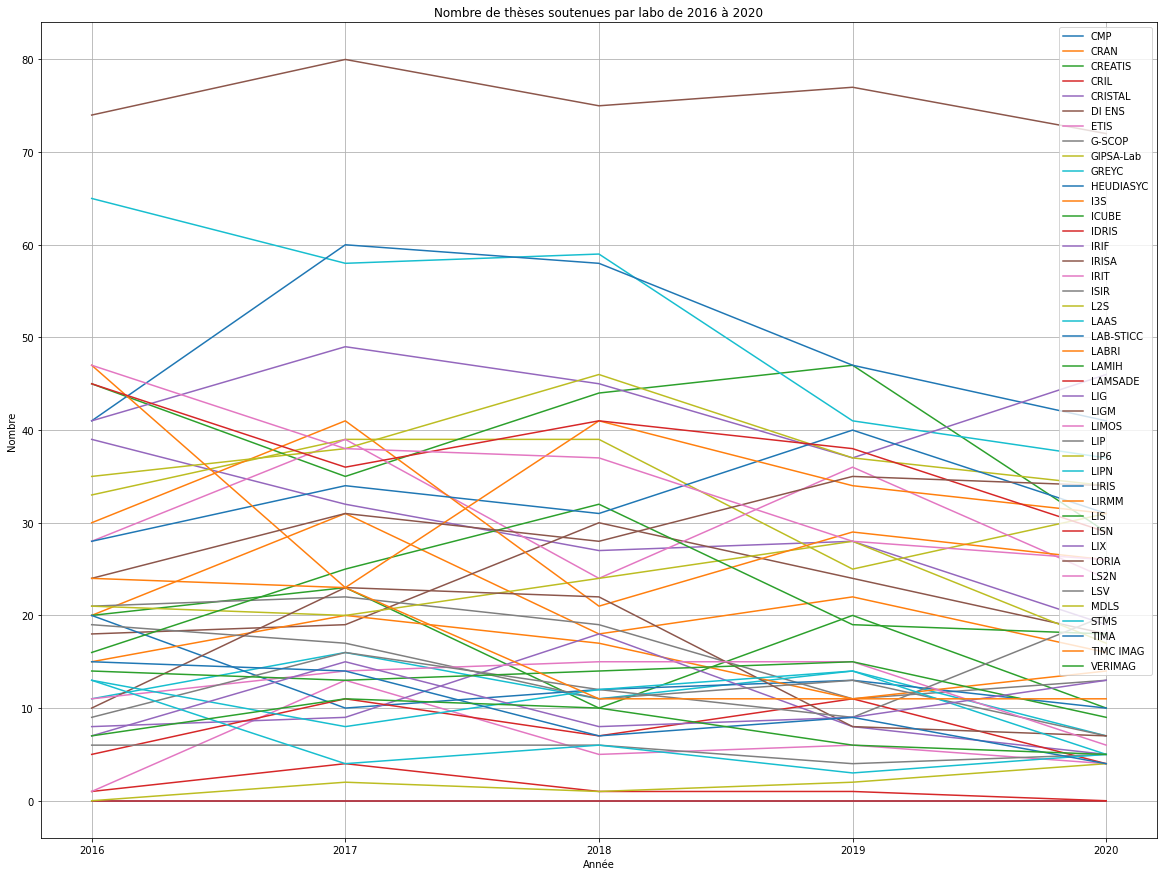

In [54]:
statsParAnneeLabo.groupby('Nom')['THESE'].plot(title="Nombre de thèses soutenues par labo de 2016 à 2020",figsize=(20,15))
plt.xticks(np.arange(2016,2021,step=1))
plt.ylabel("Nombre")
plt.legend()
plt.grid(True)

In [92]:
statsParAnneeLabo

Nom  Total  COMM  ART  COUV  DOUV  OUV  THESE  HDR
Année                                                        
2016       CMP      2     1    1     0     0    0      0    0
2017       CMP      5     2    3     0     0    0      0    0
2018       CMP      2     2    0     0     0    0      0    0
2019       CMP      0     0    0     0     0    0      0    0
2020       CMP      0     0    0     0     0    0      0    0
...        ...    ...   ...  ...   ...   ...  ...    ...  ...
2017   VERIMAG     50    27   11     0     1    0     11    0
2018   VERIMAG     60    32   13     2     1    2     10    0
2019   VERIMAG     50    25   11     5     0    3      6    0
2020   VERIMAG     37    22    7     2     0    0      5    1
2021   VERIMAG     35    19    8     4     0    0      3    1

[300 rows x 9 columns]

### Evolution par année du nombre total de publications

In [93]:
statsPourPivot = statsParAnneeLabo.reset_index(inplace=False)
ins2iTotalPubli = statsPourPivot.pivot(index="Nom", columns=["Année"], values='Total')
display(ins2iTotalPubli)

Année           2016  2017  2018  2019  2020  2021
Nom                                               
CMP                2     5     2     0     0     0
CRAN             376   404   396   399   313   311
CREATIS          252   320   286   294   259   255
CRIL              71    71    68    62    53    46
CRISTAL          586   628   513   492   499   534
CROSSING (IRL)     0     0     0     0     5    24
DI ENS           154   177   209   171   182   172
ETIS             116   137    95   107   101   103
FILOFOCS (UMI)     0     0     0     0     0     0
G-SCOP           175   201   186   152   146   156
GIPSA-Lab        504   479   463   464   352   401
GREYC            187   197   168   176   111   129
HEUDIASYC        194   220   185   170   146   138
I3S              255   286   264   293   292   308
ICUBE            343   353   374   492   425   672
IDRIS              1     0     1     1     2     4
IPAL  (IRL)       10    13     8    14    11     4
IRIF              96   126   117   126   112   116
IRISA           1051   912   950   853   746   724
IRIT             730   740   693   646   516   583
ISIR             136   146   139   124   143   169
JFLI              10    11    10    22    16    12
L2S              502   521   513   470   405   382
LAAS             667   641   656   564   431   488
LAB-STICC        676   682   619   617   427   484
LABRI            480   460   373   413   308   273
LAMIH            425   426   405   347   325   308
LAMSADE          150   141   151   155   134   126
LIG              516   470   489   395   357   304
LIGM             210   214   209   182   165   180
LIMOS            215   225   247   225   174   204
LIP              216   222   238   174   167   141
LIP6             632   519   502   497   420   465
LIPN             105    73   113   104    57    75
LIRIS            386   335   328   312   286   273
LIRMM            621   550   569   470   396   388
LIS              375   356   357   341   323   296
LISN             649   593   615   524   420   344
LIX              129   158   178   186   176   202
LMF                0     0     0     2     8    89
LMF-LSV           75    73    77    71    65    99
LORIA            495   515   523   534   516   480
LS2N             627   662   702   613   522   554
MDLS              30    40    40    30    35    24
RELAX              0     1     1     3     4     2
ROOT (IRL)        10    10     6    10    10    22
STMS             173   166   151   160   124   111
TIMA             165   118   110   126    71   104
TIMC IMAG        299   268   285   207   183   138
VERIMAG           66    50    60    50    37    35

### Evolution par année du nombre de conférences

In [95]:
statsPourPivot = statsParAnneeLabo.reset_index(inplace=False)
ins2iNbConf = statsPourPivot.pivot(index="Nom", columns=["Année"], values='COMM')
display(ins2iNbConf)

Année           2016  2017  2018  2019  2020  2021
Nom                                               
CMP                1     2     2     0     0     0
CRAN             201   241   201   200   111   115
CREATIS          111   165   114   121    65    77
CRIL              59    44    50    46    35    29
CRISTAL          333   367   292   274   246   248
CROSSING (IRL)     0     0     0     0     3     8
DI ENS            86   108   117    98   118   110
ETIS              82    71    52    60    37    46
FILOFOCS (UMI)     0     0     0     0     0     0
G-SCOP            87   107    89    85    62    56
GIPSA-Lab        258   246   231   245   141   151
GREYC            107   103    95    98    42    75
HEUDIASYC        115   135   107    88    72    73
I3S              163   133   163   178   160   131
ICUBE            122   120   117   141   123   231
IDRIS              0     0     1     1     0     1
IPAL  (IRL)        7     9     3     5     7     2
IRIF              51    48    52    56    46    36
IRISA            652   530   586   494   367   356
IRIT             492   452   427   376   251   320
ISIR              40    58    50    51    47    59
JFLI               5     6     7    20    12     3
L2S              277   304   267   231   182   167
LAAS             363   330   305   261   184   205
LAB-STICC        437   390   341   373   187   213
LABRI            273   254   199   189   132   103
LAMIH            201   204   183   144   130   113
LAMSADE           70    62    60    67    63    53
LIG              327   309   301   248   186   172
LIGM             119    97   102    81    72    68
LIMOS             91    98   121   107    82    97
LIP              121   105   129    88    88    78
LIP6             391   309   283   303   224   263
LIPN              50    32    49    39    17    30
LIRIS            221   175   163   150   123   149
LIRMM            336   277   280   209   176   156
LIS              200   185   191   165   152   135
LISN             390   339   354   297   193   149
LIX               80    75    74    76    77    83
LMF                0     0     0     1     4    44
LMF-LSV           40    43    45    47    33    46
LORIA            272   314   314   306   269   277
LS2N             300   340   375   318   229   241
MDLS               4    13    14     8     1     5
RELAX              0     0     1     1     1     0
ROOT (IRL)         5     4     1     8     5    13
STMS              83    95    67    87    53    35
TIMA             116    78    67    86    49    46
TIMC IMAG         44    41    42    32    18    19
VERIMAG           41    27    32    25    22    19

### Evolution par année du nombre d'articles de revues

In [96]:
statsPourPivot = statsParAnneeLabo.reset_index(inplace=False)
ins2iNbART = statsPourPivot.pivot(index="Nom", columns=["Année"], values='ART')
display(ins2iNbART)

Année           2016  2017  2018  2019  2020  2021
Nom                                               
CMP                1     3     0     0     0     0
CRAN             129   119   155   150   179   162
CREATIS          116   126   158   147   182   159
CRIL               9    15    14     9     7    11
CRISTAL          186   202   171   160   188   214
CROSSING (IRL)     0     0     0     0     2    15
DI ENS            41    40    55    45    40    42
ETIS              30    41    33    37    48    47
FILOFOCS (UMI)     0     0     0     0     0     0
G-SCOP            58    64    66    42    53    74
GIPSA-Lab        177   170   163   174   167   210
GREYC             55    67    51    59    46    32
HEUDIASYC         56    63    55    61    55    54
I3S               62   113    70    84    96   117
ICUBE            164   175   200   275   252   397
IDRIS              1     0     0     0     1     3
IPAL  (IRL)        2     4     3     8     2     1
IRIF              34    60    44    56    53    55
IRISA            264   264   241   230   263   255
IRIT             152   184   176   179   179   189
ISIR              67    59    69    55    81    86
JFLI               4     3     3     2     4     9
L2S              188   183   203   198   191   183
LAAS             204   220   246   230   194   215
LAB-STICC        179   218   194   165   174   220
LABRI            136   134   127   162   123   120
LAMIH            179   179   144   152   141   162
LAMSADE           59    59    77    60    46    49
LIG              108    88   107    78    97    76
LIGM              76    81    69    83    74    85
LIMOS             87   104    96    83    71    75
LIP               79    82    81    67    57    48
LIP6             162   133   147   128   121   141
LIPN              32    25    41    42    25    32
LIRIS            115    97   107    99   111    84
LIRMM            204   204   219   197   163   185
LIS              137   139   131   119   140   135
LISN             182   192   178   151   169   127
LIX               35    50    81    86    72    84
LMF                0     0     0     0     1    31
LMF-LSV           24    19    21    18    18    39
LORIA            150   126   130   145   165   126
LS2N             233   203   231   215   209   235
MDLS              26    25    25    20    28    17
RELAX              0     0     0     1     1     2
ROOT (IRL)         3     3     1     2     2     6
STMS              54    43    45    44    47    38
TIMA              31    20    32    23    15    38
TIMC IMAG        227   192   226   152   149   110
VERIMAG           14    11    13    11     7     8

### Evolution du nombre de thèses soutenues

In [97]:
statsPourPivot = statsParAnneeLabo.reset_index(inplace=False)
ins2iNbTheses = statsPourPivot.pivot(index="Nom", columns=["Année"], values='THESE')
display(ins2iNbTheses)

Année           2016  2017  2018  2019  2020  2021
Nom                                               
CMP                0     0     0     0     0     0
CRAN              20    31    18    22    16    17
CREATIS           20    23    10    20    10    15
CRIL               1     4     1     1     1     1
CRISTAL           39    32    28    30    21    48
CROSSING (IRL)     0     0     0     0     0     0
DI ENS            18    19    30    24    19    14
ETIS               1    13     5     6     4     4
FILOFOCS (UMI)     0     0     0     0     0     0
G-SCOP            21    22    19    11    13    16
GIPSA-Lab         33    40    39    25    31    26
GREYC             11    16    11    14     7    10
HEUDIASYC         22    10    13    13    10    11
I3S               15    20    17    11    14    30
ICUBE             45    36    43    46    29    22
IDRIS              0     0     0     0     0     0
IPAL  (IRL)        0     0     2     1     2     0
IRIF               8     9    18     8     5    11
IRISA             74    80    75    77    73    78
IRIT              28    39    26    37    25    36
ISIR              19    17    12    13     7    15
JFLI               0     0     0     0     0     0
L2S               21    20    24    28    17    24
LAAS              65    59    59    41    37    54
LAB-STICC         41    61    58    47    42    37
LABRI             30    41    21    29    26    25
LAMIH             16    25    32    19    18    19
LAMSADE            5    11     7    12     5    10
LIG               41    49    45    37    46    32
LIGM              10    23    22     8     7    15
LIMOS             11    14    15    15     6    13
LIP                9    16    12     9    20    13
LIP6              35    38    46    37    37    31
LIPN              13     8    12    14     5     8
LIRIS             28    34    30    38    30    24
LIRMM             47    23    42    34    31    23
LIS               14    13    14    15     8     5
LISN              45    36    41    38    29    33
LIX                7    15     8    10    13    22
LMF                0     0     0     0     1     9
LMF-LSV            6     6     6     4     5     9
LORIA             24    31    28    35    34    41
LS2N              47    38    37    28    25    35
MDLS               0     2     1     2     4     1
RELAX              0     0     0     0     0     0
ROOT (IRL)         2     3     3     0     3     1
STMS              13     4     6     4     5     7
TIMA              15    14     7     9     4    12
TIMC IMAG         24    23    11    11    11     7
VERIMAG            7    11    10     6     5     3

In [26]:
statsParAnneeLabo.groupby('Année').describe()

Total                                                         COMM  \
      count    mean         std  min    25%    50%     75%     max count   
Année                                                                      
2016   50.0  282.88  251.799616  0.0  80.25  202.0  491.25  1052.0  50.0   
2017   50.0  278.30  237.717741  0.0  73.00  217.0  467.50   912.0  50.0   
2018   50.0  272.90  234.878627  0.0  81.50  209.0  448.50   950.0  50.0   
2019   50.0  256.82  216.583178  0.0  79.25  179.0  451.25   853.0  50.0   
2020   50.0  219.52  183.206167  0.0  59.00  170.5  355.75   746.0  50.0   

               ...  THESE         HDR                                       \
         mean  ...    75%   max count  mean       std  min  25%  50%   75%   
Année          ...                                                           
2016   156.48  ...  28.00  74.0  50.0  1.52  2.032792  0.0  0.0  1.0  2.00   
2017   148.90  ...  31.75  80.0  50.0  1.14  1.565052  0.0  0.0  1.0  2.00   
2018   142.32  ...  29.50  75.0  50.0  1.24  1.720939  0.0  0.0  1.0  1.75   
2019   131.68  ...  28.75  77.0  50.0  1.40  1.937809  0.0  0.0  1.0  2.00   
2020    97.94  ...  25.00  73.0  50.0  1.02  1.834922  0.0  0.0  0.0  1.00   

            
       max  
Année       
2016   7.0  
2017   8.0  
2018   7.0  
2019   9.0  
2020   9.0  

[5 rows x 64 columns]

In [27]:
statsParAnneeLabo.groupby('Nom')['ART'].sum()

Nom
CMP                  4
CRAN               732
CREATIS            729
CRIL                54
CRISTAL            907
CROSSING (IRL)       2
DI ENS             221
ETIS               189
FILOFOCS (UMI)       0
G-SCOP             283
GIPSA-Lab          851
GREYC              278
HEUDIASYC          290
I3S                425
ICUBE             1066
IDRIS                2
IPAL  (IRL)         19
IRIF               247
IRISA             1263
IRIT               870
ISIR               331
JFLI                16
L2S                963
LAAS              1094
LAB-STICC          930
LABRI              682
LAMIH              795
LAMSADE            301
LIG                478
LIGM               383
LIMOS              441
LIP                366
LIP6               691
LIPN               165
LIRIS              529
LIRMM              987
LIS                666
LISN               872
LIX                324
LMF                  1
LMF-LSV            100
LORIA              716
LS2N              1091
MDLS   

## Somme des valeurs par laboratoire
! Cela entraîne des doublons = les publications publiées par plusieurs laboratoires
Voir plus bas pour une requête qui fusionne tous les labos et évite ces doublons
...
mais cela permet aussi par la suite de voir le nombre de publications qui impliquent plusieurs laboratoires INS2I
Estimation : environ 10% aussi bien pour COMM que pour ART

In [28]:
ins2i = statsParAnneeLabo.groupby('Année').sum()
display(ins2i)
### !!!! OBSOLETE CAR DOUBLONS : voir plus bas pour une interrogation globale INS2I

Total  COMM   ART  COUV  DOUV  OUV  THESE  HDR
Année                                                
2016   14144  7824  4533   455   235   70    951   76
2017   13915  7445  4602   446   231  105   1029   57
2018   13645  7116  4699   506   205   92    965   62
2019   12841  6584  4504   515   189   89    890   70
2020   10976  4897  4509   515   152   91    761   51

Text(0, 0.5, 'Nombre total')

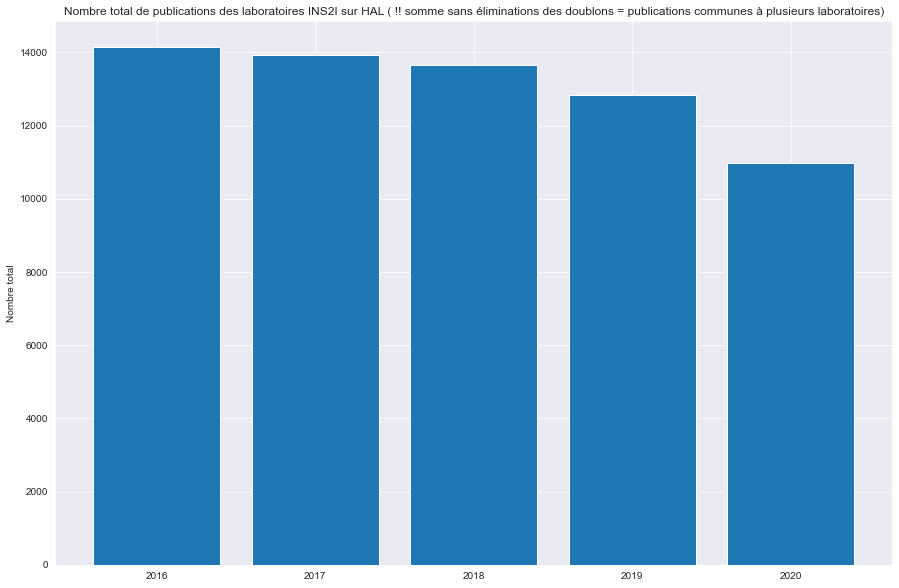

In [29]:
plt.figure(figsize=(15,10))
plt.bar(ins2i.index,ins2i['Total'])
plt.title("Nombre total de publications des laboratoires INS2I sur HAL ( !! somme sans éliminations des doublons = publications communes à plusieurs laboratoires)")
plt.xticks(np.arange(2016,2021,step=1))
plt.ylabel("Nombre total")

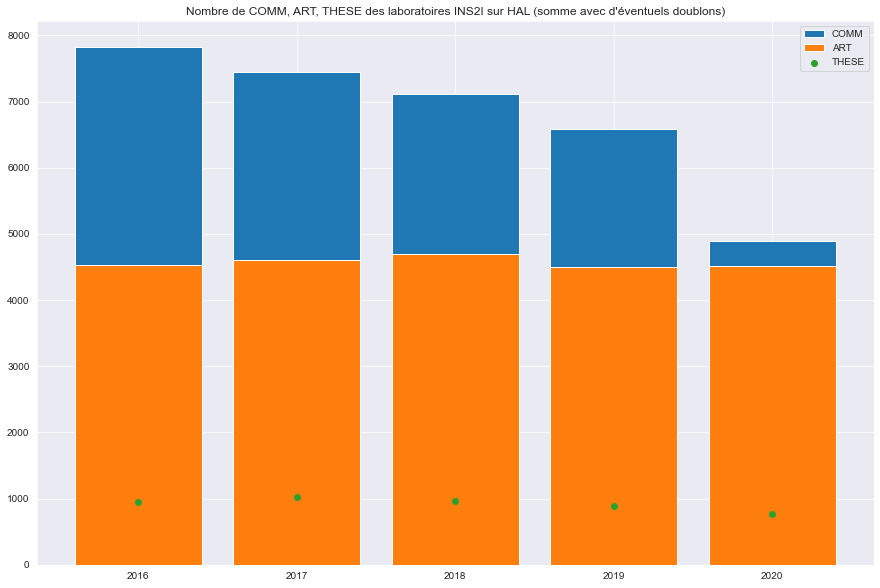

In [30]:
plt.figure(figsize=(15,10))
plt.title("Nombre de COMM, ART, THESE des laboratoires INS2I sur HAL (somme avec d'éventuels doublons)")
b1 = plt.bar(ins2i.index,ins2i['COMM'])
b2 = plt.bar(ins2i.index,ins2i['ART'])
b3 = plt.scatter(ins2i.index,ins2i['THESE'])
plt.legend([b1,b2,b3], ['COMM','ART','THESE'])

In [9]:
recherche = 'authFullName_t:Patrice+Bellot&sort=publicationDate_s desc&indent=true&rows=10&fl=label_s,keyword_s&facet=true&facet.field=keyword_s&wt=json'

In [10]:
reponses = requests.get("https://api.archives-ouvertes.fr/search/?q="+recherche)

In [11]:
j = json.loads(reponses.text)
print("Nombre documents trouvés : ",j['response']['numFound'])

Nombre documents trouvés :  145


In [115]:
print(reponses.text)

{
  "response":{"numFound":145,"start":0,"docs":[
      {
        "label_s":"Liana Ermakova, Patrice Bellot, Jaap Kamps, Diana Nurbakova, Irina Ovchinnikova, et al.. Automatic Simplification of Scientific Texts: SimpleText Lab at CLEF-2022. Advances in Information Retrieval, 13186, Springer International Publishing, pp.364-373, 2022, Lecture Notes in Computer Science, &#x27E8;10.1007/978-3-030-99739-7_46&#x27E9;. &#x27E8;hal-03637775&#x27E9;"},
      {
        "label_s":"Haytame Fallah, Patrice Bellot, Emmanuel Bruno, Elisabeth Murisasco. Architectures Transformeurs pour la classification multilabels de textes. BDA 2021 - 37ème Conférence sur la Gestion de Données – Principes, Technologies et Applications, Oct 2021, Paris, France. &#x27E8;hal-03489418&#x27E9;",
        "keyword_s":["Deep learning",
          "Transformers",
          "Language models",
          "Multilabel text classification",
          "BERT",
          "Deep Learning",
          "Apprentissage profond",
          "

# Evolution des publications pour l'ensemble de l'INS2I
### avec une seule requête fusionnée

In [79]:
# Création de la requête et du dataframe final
# Interrogation avec les IDs des laboratoires avec une seule requête pour l'ensemble des labos
anneeDebut = 2015
anneeFin = 2021

evolutionINS2I = pd.DataFrame()
for x in range(anneeDebut,anneeFin+1):
    data = {
        "Année" : [x],
        "Total" : [0],
        "COMM" : [0],
        "ART" : [0],
        "COUV" : [0],
        "DOUV" : [0],
        "OUV" : [0],
        "THESE" : [0],
        "HDR" : [0],
        "SOFTWARE" : [0],
    }
    evolutionINS2I = pd.concat([evolutionINS2I, pd.DataFrame(data)], ignore_index=True)
evolutionINS2I.set_index(['Année'], inplace=True)

premierId = True
for labo in listeLabosINS2I:
    #print(labo)
    if premierId:
        listeIds = "("
    for id in labo[1]:
        if not premierId:
            listeIds += " OR "
        else:
            premierId = False
        listeIds += str(id)
listeIds += ")"
recherche= "structId_i:"+listeIds+"&fq=producedDateY_i:["+str(anneeDebut)+" TO "+str(anneeFin)+"]&rows=0&facet=true&facet.pivot=producedDateY_i,docType_s&wt=json"
print(recherche)
print(evolutionINS2I)

structId_i:(244423 OR 185180 OR 139739 OR 90448 OR 1628 OR 410272 OR 25027 OR 1063106 OR 1003474 OR 1087906 OR 1003348 OR 1061575 OR 1006288 OR 1006289 OR 1042376 OR 1043333 OR 24470 OR 150 OR 74240 OR 1043137 OR 1041927 OR 389870 OR 552896 OR 13009 OR 1079434 OR 217648 OR 1073080 OR 1823 OR 220880 OR 542003 OR 138926 OR 1005016 OR 444497 OR 1098246 OR 25255 OR 105128 OR 1099401 OR 1099402 OR 1099435 OR 1099404 OR 8621 OR 1099406 OR 490899 OR 1099479 OR 2494 OR 34499 OR 1082335 OR 541937 OR 96164 OR 542009 OR 229050 OR 1289 OR 1051117 OR 459 OR 3102 OR 199324 OR 1089048 OR 486345 OR 491660 OR 81533 OR 1067790 OR 1303 OR 989 OR 1041964 OR 1043301 OR 24471 OR 3210 OR 1001627 OR 857 OR 490706 OR 1063677 OR 35418 OR 233 OR 541703 OR 1095103 OR 1000994 OR 994 OR 1086916 OR 1056718 OR 1086665 OR 2003 OR 1071941 OR 181 OR 199394 OR 178374 OR 527033 OR 199402 OR 862 OR 1041968 OR 247329 OR 2544 OR 1050003 OR 81750 OR 1061259 OR 1070048 OR 1041697 OR 1071530 OR 2071 OR 1065710 OR 206040 OR 4666

In [80]:
#Exécution de la requête unique
try:
    requete = "https://api.archives-ouvertes.fr/search/CNRS/?q="+recherche
    print(requete)
    reponses = requests.get(requete, timeout=(300,300))
except requests.ReadTimeout:
    print ("temps limite atteint")
j = json.loads(reponses.text)
#print(json.dumps(j, indent=3))
liste = j['facet_counts']['facet_pivot']['producedDateY_i,docType_s']

https://api.archives-ouvertes.fr/search/CNRS/?q=structId_i:(244423 OR 185180 OR 139739 OR 90448 OR 1628 OR 410272 OR 25027 OR 1063106 OR 1003474 OR 1087906 OR 1003348 OR 1061575 OR 1006288 OR 1006289 OR 1042376 OR 1043333 OR 24470 OR 150 OR 74240 OR 1043137 OR 1041927 OR 389870 OR 552896 OR 13009 OR 1079434 OR 217648 OR 1073080 OR 1823 OR 220880 OR 542003 OR 138926 OR 1005016 OR 444497 OR 1098246 OR 25255 OR 105128 OR 1099401 OR 1099402 OR 1099435 OR 1099404 OR 8621 OR 1099406 OR 490899 OR 1099479 OR 2494 OR 34499 OR 1082335 OR 541937 OR 96164 OR 542009 OR 229050 OR 1289 OR 1051117 OR 459 OR 3102 OR 199324 OR 1089048 OR 486345 OR 491660 OR 81533 OR 1067790 OR 1303 OR 989 OR 1041964 OR 1043301 OR 24471 OR 3210 OR 1001627 OR 857 OR 490706 OR 1063677 OR 35418 OR 233 OR 541703 OR 1095103 OR 1000994 OR 994 OR 1086916 OR 1056718 OR 1086665 OR 2003 OR 1071941 OR 181 OR 199394 OR 178374 OR 527033 OR 199402 OR 862 OR 1041968 OR 247329 OR 2544 OR 1050003 OR 81750 OR 1061259 OR 1070048 OR 1041697

In [18]:
print(liste)

[{'field': 'producedDateY_i', 'value': 2016, 'count': 14106, 'pivot': [{'field': 'docType_s', 'value': 'COMM', 'count': 7122}, {'field': 'docType_s', 'value': 'ART', 'count': 4119}, {'field': 'docType_s', 'value': 'THESE', 'count': 945}, {'field': 'docType_s', 'value': 'COUV', 'count': 406}, {'field': 'docType_s', 'value': 'REPORT', 'count': 366}, {'field': 'docType_s', 'value': 'POSTER', 'count': 278}, {'field': 'docType_s', 'value': 'UNDEFINED', 'count': 268}, {'field': 'docType_s', 'value': 'DOUV', 'count': 192}, {'field': 'docType_s', 'value': 'OTHER', 'count': 140}, {'field': 'docType_s', 'value': 'HDR', 'count': 76}, {'field': 'docType_s', 'value': 'PATENT', 'count': 70}, {'field': 'docType_s', 'value': 'OUV', 'count': 66}, {'field': 'docType_s', 'value': 'MEM', 'count': 18}, {'field': 'docType_s', 'value': 'SOFTWARE', 'count': 15}, {'field': 'docType_s', 'value': 'PRESCONF', 'count': 11}, {'field': 'docType_s', 'value': 'LECTURE', 'count': 9}, {'field': 'docType_s', 'value': 'VI

In [81]:
for donnees in  liste:
    annee = donnees['value']
    #print (annee, " : ")
    for statsAnnee in donnees['pivot']:
        if statsAnnee['value'] in evolutionINS2I:
            #print (statsAnnee['value']," : ",statsAnnee['count'])
            evolutionINS2I.loc[annee,statsAnnee['value']] += statsAnnee['count'] #addition pour tenir compte des différents ids des labos
            evolutionINS2I.loc[annee,'Total'] += statsAnnee['count'] #cela assure que le total correspond aux seuls types de publications retenus

display(evolutionINS2I)

Total  COMM   ART  COUV  DOUV  OUV  THESE  HDR  SOFTWARE
Année                                                          
2015   12565  7098  3804   442   197   70    886   63         5
2016   12940  7122  4118   406   192   66    945   76        15
2017   12753  6766  4202   407   193   99   1020   57         9
2018   12524  6504  4285   446   167   77    959   62        24
2019   11757  5972  4112   471   150   75    874   70        33
2020   10101  4478  4160   442   122   83    754   51        11
2021   10474  4617  4377   378   118   71    850   46        17

### idem ci-dessus mais avec COMM et ART seulement

In [82]:
# Création de la requête et du dataframe final
# Interrogation avec les IDs des laboratoires avec une seule requête pour l'ensemble des labos
anneeDebut = 2015
anneeFin = 2021

evolutionINS2I = pd.DataFrame()
for x in range(anneeDebut,anneeFin+1):
    data = {
        "Année" : [x],
        "Total" : [0],
        "COMM" : [0],
        "ART" : [0],
    }
    evolutionINS2I = pd.concat([evolutionINS2I, pd.DataFrame(data)], ignore_index=True)
evolutionINS2I.set_index(['Année'], inplace=True)

premierId = True
for labo in listeLabosINS2I:
    #print(labo)
    if premierId:
        listeIds = "("
    for id in labo[1]:
        if not premierId:
            listeIds += " OR "
        else:
            premierId = False
        listeIds += str(id)
listeIds += ")"
recherche= "structId_i:"+listeIds+"&fq=producedDateY_i:["+str(anneeDebut)+" TO "+str(anneeFin)+"]&rows=0&facet=true&facet.pivot=producedDateY_i,docType_s&wt=json"
print(recherche)
print(evolutionINS2I)

structId_i:(244423 OR 185180 OR 139739 OR 90448 OR 1628 OR 410272 OR 25027 OR 1063106 OR 1003474 OR 1087906 OR 1003348 OR 1061575 OR 1006288 OR 1006289 OR 1042376 OR 1043333 OR 24470 OR 150 OR 74240 OR 1043137 OR 1041927 OR 389870 OR 552896 OR 13009 OR 1079434 OR 217648 OR 1073080 OR 1823 OR 220880 OR 542003 OR 138926 OR 1005016 OR 444497 OR 1098246 OR 25255 OR 105128 OR 1099401 OR 1099402 OR 1099435 OR 1099404 OR 8621 OR 1099406 OR 490899 OR 1099479 OR 2494 OR 34499 OR 1082335 OR 541937 OR 96164 OR 542009 OR 229050 OR 1289 OR 1051117 OR 459 OR 3102 OR 199324 OR 1089048 OR 486345 OR 491660 OR 81533 OR 1067790 OR 1303 OR 989 OR 1041964 OR 1043301 OR 24471 OR 3210 OR 1001627 OR 857 OR 490706 OR 1063677 OR 35418 OR 233 OR 541703 OR 1095103 OR 1000994 OR 994 OR 1086916 OR 1056718 OR 1086665 OR 2003 OR 1071941 OR 181 OR 199394 OR 178374 OR 527033 OR 199402 OR 862 OR 1041968 OR 247329 OR 2544 OR 1050003 OR 81750 OR 1061259 OR 1070048 OR 1041697 OR 1071530 OR 2071 OR 1065710 OR 206040 OR 4666

In [83]:
#Exécution de la requête unique
try:
    requete = "https://api.archives-ouvertes.fr/search/CNRS/?q="+recherche
    print(requete)
    reponses = requests.get(requete, timeout=(300,300))
except requests.ReadTimeout:
    print ("temps limite atteint")
j = json.loads(reponses.text)
#print(json.dumps(j, indent=3))
liste = j['facet_counts']['facet_pivot']['producedDateY_i,docType_s']
for donnees in  liste:
    annee = donnees['value']
    #print (annee, " : ")
    for statsAnnee in donnees['pivot']:
        if statsAnnee['value'] in evolutionINS2I:
            #print (statsAnnee['value']," : ",statsAnnee['count'])
            evolutionINS2I.loc[annee,statsAnnee['value']] += statsAnnee['count'] #addition pour tenir compte des différents ids des labos
            evolutionINS2I.loc[annee,'Total'] += statsAnnee['count'] #cela assure que le total correspond aux seuls types de publications retenus

display(evolutionINS2I)

https://api.archives-ouvertes.fr/search/CNRS/?q=structId_i:(244423 OR 185180 OR 139739 OR 90448 OR 1628 OR 410272 OR 25027 OR 1063106 OR 1003474 OR 1087906 OR 1003348 OR 1061575 OR 1006288 OR 1006289 OR 1042376 OR 1043333 OR 24470 OR 150 OR 74240 OR 1043137 OR 1041927 OR 389870 OR 552896 OR 13009 OR 1079434 OR 217648 OR 1073080 OR 1823 OR 220880 OR 542003 OR 138926 OR 1005016 OR 444497 OR 1098246 OR 25255 OR 105128 OR 1099401 OR 1099402 OR 1099435 OR 1099404 OR 8621 OR 1099406 OR 490899 OR 1099479 OR 2494 OR 34499 OR 1082335 OR 541937 OR 96164 OR 542009 OR 229050 OR 1289 OR 1051117 OR 459 OR 3102 OR 199324 OR 1089048 OR 486345 OR 491660 OR 81533 OR 1067790 OR 1303 OR 989 OR 1041964 OR 1043301 OR 24471 OR 3210 OR 1001627 OR 857 OR 490706 OR 1063677 OR 35418 OR 233 OR 541703 OR 1095103 OR 1000994 OR 994 OR 1086916 OR 1056718 OR 1086665 OR 2003 OR 1071941 OR 181 OR 199394 OR 178374 OR 527033 OR 199402 OR 862 OR 1041968 OR 247329 OR 2544 OR 1050003 OR 81750 OR 1061259 OR 1070048 OR 1041697

Total  COMM   ART
Année                   
2015   10902  7098  3804
2016   11240  7122  4118
2017   10968  6766  4202
2018   10789  6504  4285
2019   10084  5972  4112
2020    8638  4478  4160
2021    8994  4617  4377

Text(0, 0.5, 'Nombre total')

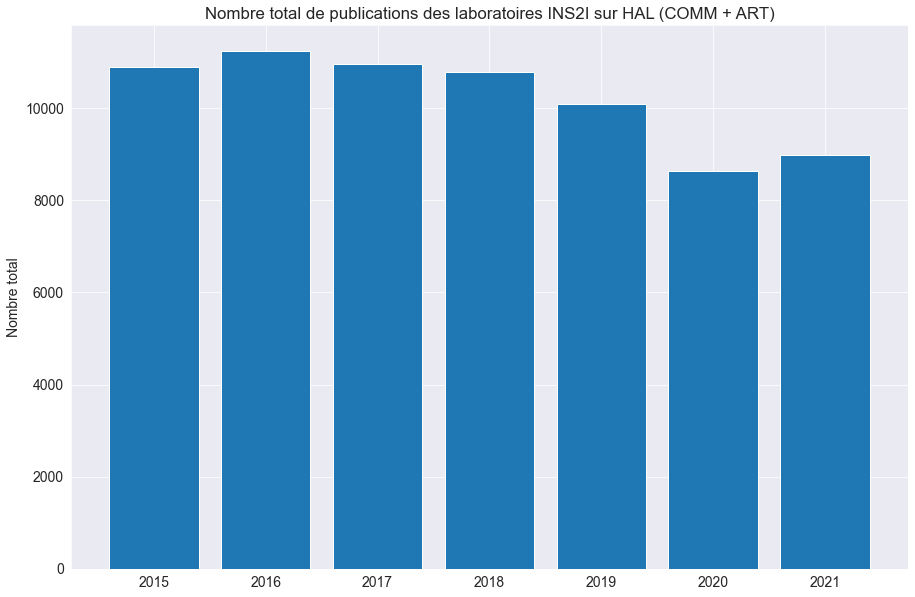

In [72]:
plt.figure(figsize=(15,10))
plt.bar(evolutionINS2I.index,evolutionINS2I['Total'])
plt.title("Nombre total de publications des laboratoires INS2I sur HAL (COMM + ART)")
plt.ylabel("Nombre total")

Text(0, 0.5, 'Nombre')

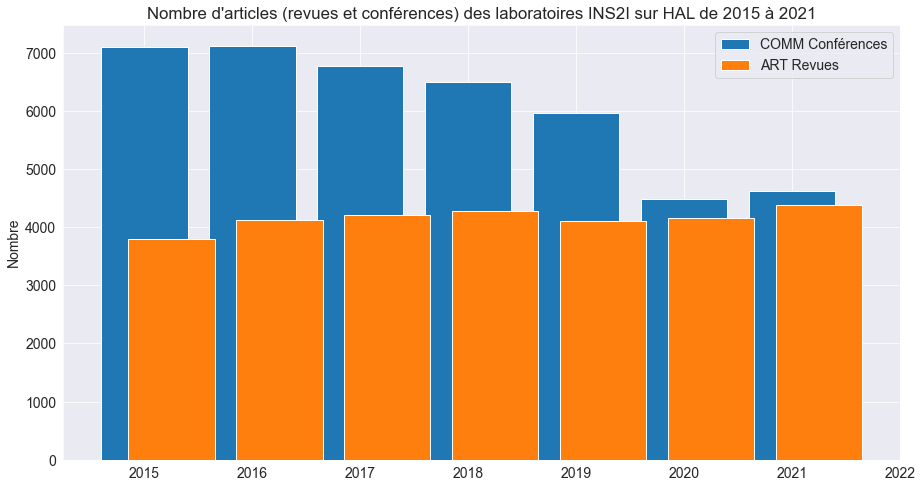

In [86]:
plt.figure(figsize=(15, 8))
width = 0.25
plt.rcParams['font.size'] = 14
plt.title("Nombre d'articles (revues et conférences) des laboratoires INS2I sur HAL de "+str(anneeDebut)+" à "+str(anneeFin))
b1 = plt.bar(evolutionINS2I.index, evolutionINS2I['COMM'])
b2 = plt.bar(evolutionINS2I.index+width, evolutionINS2I['ART'])
plt.legend([b1, b2, b3], ['COMM Conférences', 'ART Revues'])
plt.ylabel("Nombre")

-------------------------------------

In [12]:
recherche = "labStructAcronym_s:LIRIS&rows=10&fq=producedDateY_i:[2016 TO 2021]&wt=json"

In [13]:
reponses = requests.get("https://api.archives-ouvertes.fr/search/CNRS/?q="+recherche)

In [14]:
print(json.dumps(json.loads(reponses.text), indent=3))

{
   "response": {
      "numFound": 2181,
      "start": 0,
      "docs": [
         {
            "docid": 1878010,
            "label_s": "Abir Masmoudi, Mahmoud Barhamgi, Noura Faci, Zohra Saoud, Khalid Belhajjame, et al.. An Ontology-Based Approach for Mining Radicalization Indicators from Online Messages. 2018 IEEE 32nd International Conference on Advanced Information Networking and Applications (AINA), May 2018, Krakow, Poland. pp.609-616, &#x27E8;10.1109/AINA.2018.00094&#x27E9;. &#x27E8;hal-01878010&#x27E9;",
            "uri_s": "https://hal.archives-ouvertes.fr/hal-01878010"
         },
         {
            "docid": 3390102,
            "label_s": "Alexandre Millot. Exceptional Model Mining meets Multi-Objective Optimization: Application to Plant Growth Recipes in Controlled Environments. Computer Science [cs]. INSA Lyon, 2021. English. &#x27E8;tel-03390102&#x27E9;",
            "uri_s": "https://hal.archives-ouvertes.fr/tel-03390102"
         },
         {
            "doc

-------------------------------------

## Recherche de publications communes avec un pays donné

In [2]:
dictListeLabosINS2I= { "CMP": {244423}, "CRAN": {185180,1001}, "CREATIS" : {139739}, "CRIL" : {90448,1628}, "CRISTAL" : {410272,389110,388977,390300,183073,111636,24885,2546,186929}, "DI ENS" : {25027},"CROSSING" : {1063106}, "ETIS" : {1003474,1061575,1087906,1003348}, "FILOFOCS" : {1006288,1006289}, "GIPSA-Lab" : {1043333,1042376,24470}, "GREYC" : {150}, "G-SCOP" : {1043137,1041927,74240},"HEUDIASYC" : {389870}, "I3S" : {13009, 552896, 1079434},"ICUBE" : {217648,1073080}, "IDRIS" : {1823}, "IPAL  IRL" : {542003,220880,138926}, "IRIF" : {1005016,444497}, "IRISA" : {491183,491231,490899,491188,1092618,491177,1092619,490900,419364,419370,105128,2494,25255,419365,419367,491230,419363,419366,491232,419362,1099404,545024,1099406,1099401,1099402,1099435, 525233, 1088566, 1088569, 495900, 489780, 1092631, 1092630, 1092628, 1092632, 1092626, 1092625, 1092629}, "IRIT" : {34499,1082335}, "ISIR" : {541937,96164}, "JFLI" : {542009,229050}, "L2S" : {1051117,1289},"LAAS" : {459},"LABRI" : {3102}, "LAB-STICC" : {486345,491660,199324,81533,1089048}, "LAMIH" : {1067790,1303}, "LAMSADE" : {989}, "LIG" : {1043301, 1041964,24471},"LIGM" : {1001627,3210}, "LIMOS" : {1063677,490706,857},"LIP" : {35418},"LIP6" : {541703,233,1095103},"LIPN" : {1000994,994,1086916,1056718},"LIRIS" : {2003,1086665}, "LIRMM" : {181,1071941}, "LIS" : {527033,199402,199394,862,178374}, "LISN" : {1061259,1041968,247329,2544,1050003,81750}, "LIX" : {2071,1041697,1071530,1070048},"LMF" : {1065710}, "LORIA" : {206040,466633},"LS2N" : {1088564,473973,95421,1693,21439},"LMF-LSV" : {1065710,1042689,2571},"MDLS" : {210816},"RELAX" : {1040410,528907},"ROOT IRL" : {389700},"STMS" : {541779,1374}, "TIMA" : {1043043,1044023,640},"TIMC IMAG" : {1043049,1070489,1042061,707,574002,555959,1056575},"VERIMAG" : {1043148,1041816,194} }

In [3]:
def recupereListeIDs (laboratoire):
    listeIds = "("
    premierId = True
    ids = dictListeLabosINS2I[laboratoire]
    #print(ids)
    for id in ids:
        if not premierId:
            listeIds += " OR "
        else:
            premierId = False
        listeIds += str(id)
    listeIds += ")"
    return listeIds

In [25]:
# fonction de requêtage qui enregistre dans un csv les publications d'un laboratoire avec un pays donné
# language_s : langue du document
# labStructCountry_s : pays pour chaque auteur
# instStructAcronym_s : institutions des auteurs
# doiId_s : DOI
# authLastName_s ou authLastNameFirstName_s : liste des noms des auteurs
import csv
def publicationsLaboPaysToCSV (labo, codePays, anneeDebut, anneeFin):
    requete = "&fq=structCountry_s:"+codePays+"&fq=producedDateY_i:["+str(anneeDebut)+" TO "+str(anneeFin)+"]&fl=producedDateY_i,docType_s,instStructAcronym_s,labStructCountry_s,authLastNameFirstName_s,title_s,abstract_s,keyword_s,authIdHasStructure_fs,structName_s,publisher_s,openAccess_bool&sort=producedDateY_i asc&rows=1000&wt=csv"
    if labo != "IRISA":
        ids = recupereListeIDs(labo)
        requete = "CNRS/?q=structId_i:"+ids+requete
    else:
        requete = labo+"/?q=*:*"+requete
    requete = "https://api.archives-ouvertes.fr/search/"+requete
    #print(requete)
    reponses = requests.get(requete, timeout=(600,600))
    #print(reponses.text)
    nb = len(reponses.text.splitlines())-1
    print (labo + " : " + str(nb))
    if nb > 0:
        nomFichier = "ListePublisPays/"+codePays+"/"+labo+"_"+codePays+".csv"
        with open(nomFichier,"w") as file:
            file.write(reponses.text)
        df = pd.read_csv(nomFichier, keep_default_na=False) # rajout colonne avec nom labo_FR dans le .csv
        df.insert(0,"Laboratoire_FR",labo)
        df.to_csv(nomFichier, index=False)

In [22]:
nomFichier = "ListePublisPays/il/LIS_il.csv"
df = pd.read_csv(nomFichier, keep_default_na=False) # rajout colonne avec nom labo_FR dans le .csv
df.insert(0,"Laboratoire_FR","LIS")
df.to_csv("ListePublisPays/il/essai.csv", index=False)

In [45]:
# parcourt les .csv d'un répertoire et les concatène dans un seul .csv
def concateneCSV (repertoireRacine, pays):
    repertoire = repertoireRacine+"/"+pays
    files = sorted(os.listdir(repertoire))
    csvFiles = [f for f in files if f.endswith('.csv')]
    listeComplete = pd.DataFrame()
    for f in csvFiles:
        #print (f)
        #print(repertoire+"/"+f)
        df = pd.read_csv(repertoire+"/"+f)
        listeComplete = pd.concat([listeComplete, df], ignore_index=True)
    listeComplete.head(10)
    listeComplete.to_csv(repertoire+"/listePublications.csv", index=False)

In [82]:
df = pd.read_csv("ListePublisPays/il/CRAN_il.csv")
df2 = pd.read_csv("ListePublisPays/il/LIS_il.csv")
df3 = pd.concat([df, df2], ignore_index=True)
df3.head(20)

Laboratoire_FR  producedDateY_i docType_s  \
0            CRAN             2014       ART   
1            CRAN             2021       ART   
2             LIS             2010      COMM   
3             LIS             2012       ART   
4             LIS             2014       ART   
5             LIS             2015       ART   
6             LIS             2017    REPORT   
7             LIS             2018     OTHER   
8             LIS             2018      COMM   
9             LIS             2018      COUV   
10            LIS             2019      COMM   
11            LIS             2019      COMM   
12            LIS             2019      COMM   
13            LIS             2020      COMM   
14            LIS             2020       ART   

                                  instStructAcronym_s  \
0           POLIMI,POLIMI,UL,CNRS,KIT,RWTH,MTA SZTAKI   
1                                        MUSC,UL,CNRS   
2                                        AMU,ECM,CNRS   
3                                        AMU,ECM,CNRS   
4                     AMU,UTLN,CNRS,TUM,AMU,UTLN,CNRS   
5                        Inria,Inria,UL,CNRS,CNRS,HUJ   
6   AMU,ECM,CNRS,UN,ECN,CNRS,IMT Atlantique,UN,ECN...   
7   ITU,DCU,UNAM,SDU,UNITO,UPD7,CNRS,CNRS,ITÜ,UPN,...   
8   AMU,UTLN,CNRS,UT,INSA CVL,CNRS,IHMC,GW,UPV/EHU...   
9      CU,AMU,ITÜ,JCT,VDU,IJS,UNIOR,AMU,UTLN,CNRS,BAS   
10  AMU,UTLN,CNRS,Inria,UR1,INSA Rennes,UBS,ENS Re...   
11  AMU,UTLN,CNRS,Inria,UR1,INSA Rennes,UBS,ENS Re...   
12  AMU,UTLN,CNRS,Inria,UR1,INSA Rennes,UBS,ENS Re...   
13  AMU,UTLN,CNRS,UT,INSA CVL,CNRS,Inria,Inria,UL,...   
14  AMU,UTLN,CNRS,Inria,UR1,INSA Rennes,UBS,ENS Re...   

                                   labStructCountry_s  \
0                                   it,it,il,fr,de,hu   
1                                                  fr   
2                                               fr,il   
3                                               fr,il   
4                                               fr,fr   
5                                         fr,fr,fr,il   
6                                      fr,fr,fr,fr,fr   
7   se,se,ie,mx,ro,dk,fr,fr,si,hu,fr,es,es,il,fr,f...   
8                                               fr,fr   
9                                               ro,fr   
10                                        fr,fr,fr,il   
11                                        fr,fr,fr,il   
12                                     ca,fr,fr,fr,il   
13                                     fr,fr,fr,fr,fr   
14                                           fr,fr,fr   

                              authLastNameFirstName_s  \
0   Colledani Marcello,Tolio Tullio,Fisher Anath,I...   
1   Tatum William,Mani Jayanti,Jin Kazutaka,Halfor...   
2   Chepoi Victor,Dragan Feodor F.,Newman Ilan,Rab...   
3   Chepoi Victor,Dragan Feodor F.,Newman Ilan,Rab...   
4   Chabriel Gilles,Kleinsteuber Martin,Moreau Eri...   
5                      Jeandel Emmanuel,Vanier Pascal   
6   Imbs Damien,Mostefaoui Achour,Perrin Matthieu,...   
7   Nivre Joakim,Abrams Mitchell,Agić Željko,Ahren...   
8   Ramisch Carlos,Cordeiro Silvio,Savary Agata,Vi...   
9   Savary Agata,Candito Marie,Barbu Mititelu Verg...   
10  Godard Emmanuel,Imbs Damien,Raynal Michel,Taub...   
11  Godard Emmanuel,Imbs Damien,Raynal Michel,Taub...   
12  Aghazadeh Zahra,Imbs Damien,Raynal Michel,Taub...   
13  Ramisch Carlos,Savary Agata,Guillaume Bruno,Wa...   
14  Godard Emmanuel,Imbs Damien,Raynal Michel,Taub...   

                                              title_s  \
0   Design and management of manufacturing systems...   
1   Minimum standards for inpatient long‐term vide...   
2   Constant Approximation Algorithms for Embeddin...   
3   Constant Approximation Algorithms for Embeddin...   
4   Joint Matrices Decompositions and Blind Source...   
5   Characterizations of periods of multidimension...   
6   Another Look at the Implementation of Read/wri...   
7                          Universal De

In [84]:
# !!!! penser à changer le nom du pays
df = pd.read_csv("ListePublisPays/br/listePublications.csv")
df.head()

Laboratoire_FR  producedDateY_i docType_s        instStructAcronym_s  \
0           CRAN             2010      COMM              UHP,INPL,CNRS   
1           CRAN             2010      COMM  UFRGS,UFRGS,UHP,INPL,CNRS   
2           CRAN             2010      COMM      UNICAMP,UHP,INPL,CNRS   
3           CRAN             2010      COMM      UNICAMP,UHP,INPL,CNRS   
4           CRAN             2010       ART      UNICAMP,UHP,INPL,CNRS   

  labStructCountry_s                            authLastNameFirstName_s  \
0              br,fr  El'Youssed Ebrahim Samer,Martins Nardênio Alme...   
1        br,br,br,fr  Moreira Tomas G.,Wehrmeister Marco A.,Pereira ...   
2                 fr  Deaecto Grace Silva,Geromel José Cláudio,Daafo...   
3                 fr  Deaecto Grace Silva,Geromel José Cláudio,Daafo...   
4                 fr  Deaecto Grace Silva,Geromel José Cláudio,Daafo...   

                                             title_s  \
0  On a Wheeledmobile Robot Trajectory Tracking C...   
1  Generating VHDL source code from UML models of...   
2  Full order dynamic output feedback H infinity ...   
3  On H_infinity control design of continuous-tim...   
4  Trajectory-dependent filter design for discret...   

                                          abstract_s  \
0  In this paper\, a trajectory tracking control ...   
1  Embedded systems' complexity and amount of dis...   
2  The main purpose of this paper is to design\, ...   
3  This paper is devoted to dynamic output feedba...   
4  This paper is devoted to trajectory-dependent ...   

                                           keyword_s  \
0  Nonholonomic wheeled mobile robot,Compensated ...   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4  Switched systems,Linear matrix inequalities,Fi...   

                               authIdHasStructure_fs  \
0  431678-865306_FacetSep_Ebrahim Samer El'Yousse...   
1  504517-881697_FacetSep_Tomas G. Moreira_JoinSe...   
2  432374-0_FacetSep_Grace Silva Deaecto_JoinSep_...   
3  432374-0_FacetSep_Grace Silva Deaecto_JoinSep_...   
4  432374-0_FacetSep_Grace Silva Deaecto_JoinSep_...   

                                        structName_s publisher_s  \
0  Departamento de Automação e Sistemas,Federal U...         NaN   
1  Informatics Institute,Universidade Federal do ...    Springer   
2  Universidade Estadual de Campinas =  Universit...         NaN   
3  Universidade Estadual de Campinas =  Universit...         NaN   
4  Universidade Estadual de Campinas =  Universit...         NaN   

   openAccess_bool  
0            False  
1             True  
2            False  
3            False  
4            False

In [88]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from wordcloud import WordCloud
import nltk
nltk.download("punkt")
nltk.download("stopwords")
texte = df.title_s.str.cat(sep=' ')
#texte = df.keyword_s.str.cat(sep=' ')
#texte += df.abstract_s.str.cat(sep=' ')
print(len(texte))
tokens = word_tokenize(texte)

202921


[nltk_data] Downloading package punkt to /Users/Patrice/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Patrice/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [95]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
more_stop_words = {"problem", "results", "model", "show", "based", "paper", "using", "two", "one", "new", "also", "used", "approach", "present", "first", "may", "use", "given", "many", "known", "efficient", "propose", "study", "proposed", "case", "different", "source", "analysis", "method", "problems", "processes", "large", "several", "multiple", "consider", "prove", "possible", "novel", "work", "shown", "provide", "provides", "including", "paper", "high", "des", "obtained", "well", "allows", "simple", "due", "via", "best", "towards", "pour", "improving", "approaches", "global", "output", "input", "dans", "techniques", "exact", "tool", "research", "conference", "scientific", "proceedings", "exploiting", "international", "algorithms", "applications"}
stop_words.update(more_stop_words)
tokens = [w.lower() for w in tokens if not w.lower() in stop_words and len(w)>2]
vocabulary = set(tokens)
frequency_dist = nltk.FreqDist(tokens)

In [59]:
print(stop_words)

{'m', 'wouldn', 'any', 'are', 'it', 'for', 'which', 'of', "weren't", 'he', 'nor', 'be', 'further', "won't", 'shan', 'because', "didn't", 'both', "hadn't", 'weren', 'myself', 'did', 'until', 'that', 'above', 'from', 'in', 'through', 'been', 'such', "it's", 'mustn', 'hadn', 'hasn', 'herself', 'can', 'was', 'where', "mightn't", 'why', 'out', 'show', 'based', 'were', 'ours', 'not', 'these', 'ain', "wasn't", 'whom', 'ma', 'yourselves', 'then', 'do', "that'll", 'some', "wouldn't", 'does', 'and', 'hers', 'himself', 'you', 'shouldn', 'by', 'ourselves', 'they', 'has', 'our', 'all', "don't", 'yourself', 'wasn', 'under', 'him', 'themselves', 'paper', 'what', 'off', "you've", 'the', 'may', 'against', 'its', 'just', 'now', "she's", 'how', "isn't", 'used', 'at', "you'd", 'she', 'each', 'own', 'first', 'to', 'approach', 'i', 'doesn', "needn't", "doesn't", 'those', 'with', 'needn', 'while', 'present', 'y', 'also', 'when', 'itself', "haven't", 't', 'once', 'my', 'one', 'between', 'won', 'her', 'before'

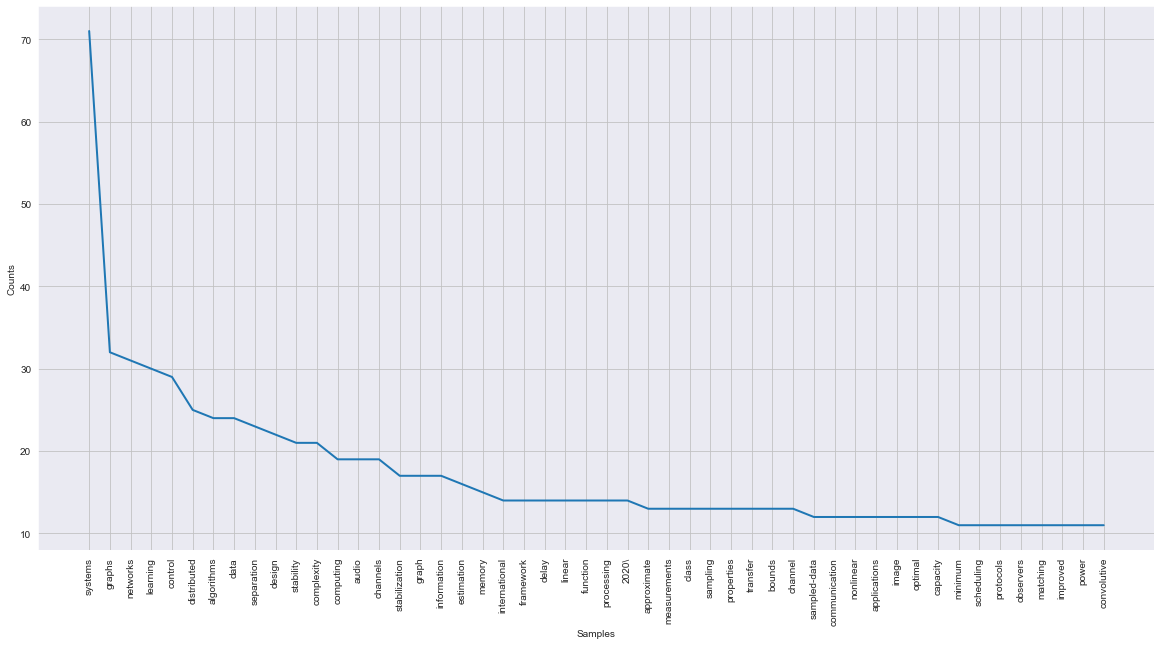

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [73]:
plt.figure(figsize=(20,10))
frequency_dist.plot(50)

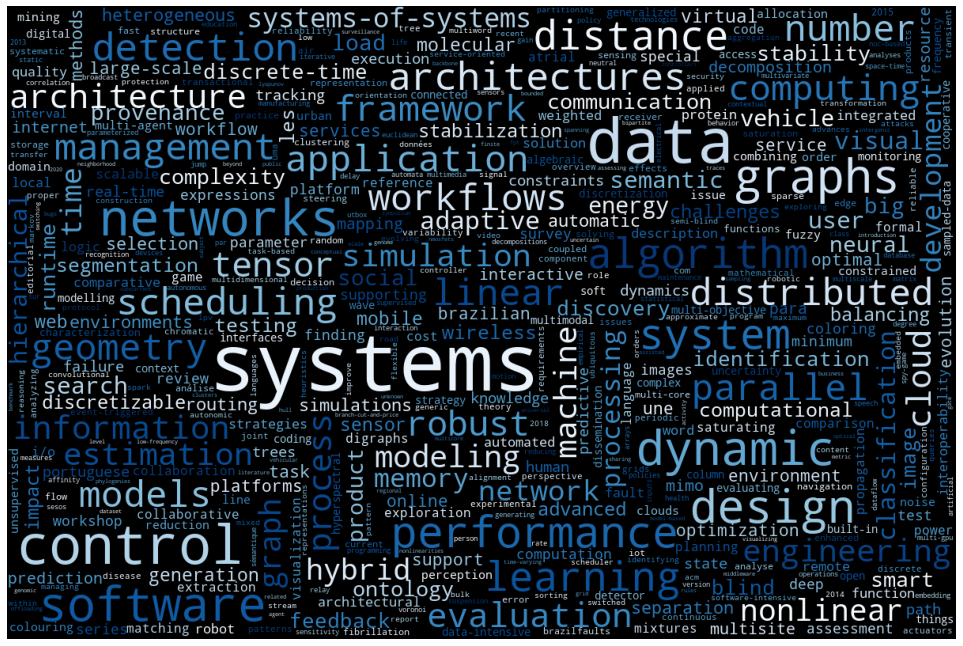

In [96]:
wordcloud = WordCloud(width=1200, height=800,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',
                      normalize_plurals=True).generate_from_frequencies(frequency_dist)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [79]:
codePays='br'
anneeDebut = 2010
anneeFin = 2021
#publicationsLaboPaysToCSV("LIS", codePays, anneeDebut, anneeFin)
for labo in dictListeLabosINS2I:
    #print(labo)
    publicationsLaboPaysToCSV(labo, codePays, anneeDebut, anneeFin) #crée un fichier .csv pour chaque pays
concateneCSV("ListePublisPays",codePays) #crée un fichier global pour le pays, nommé listePublications.csv

CMP : 0
CRAN : 78
CREATIS : 6
CRIL : 6
CRISTAL : 76
DI ENS : 10
CROSSING : 0
ETIS : 17
FILOFOCS : 0
GIPSA-Lab : 98
GREYC : 19
G-SCOP : 43
HEUDIASYC : 55
I3S : 171
ICUBE : 8
IDRIS : 0
IPAL  IRL : 2
IRIF : 1
IRISA : 360
IRIT : 102
ISIR : 4
JFLI : 0
L2S : 90
LAAS : 70
LABRI : 71
LAB-STICC : 43
LAMIH : 55
LAMSADE : 14
LIG : 237
LIGM : 49
LIMOS : 22
LIP : 39
LIP6 : 148
LIPN : 3
LIRIS : 35
LIRMM : 226
LIS : 40
LISN : 96
LIX : 64
LMF : 0
LORIA : 72
LS2N : 49
LMF-LSV : 0
MDLS : 0
RELAX : 0
ROOT IRL : 0
STMS : 5
TIMA : 34
TIMC IMAG : 2
VERIMAG : 0


### Détermine le nombre de publications communes avec un pays pour chaque laboratoire

In [136]:
# Interrogation avec les IDs des laboratoires (utile seulement pour les laboratoires qui n'ont pas de collection mais risque d'IDs incomplets)
# le champ structCountry_s correspond au pays de chaque auteur = les publications avec au moins un auteur de ce pays sont retournées
import re
#codePays='br'
codePays='il'
anneeDebut = 2010
anneeFin = 2021
enregistrementReponsesPourUnLabo = True #dans ce cas requête avec extraction des noms des structures auteurs (instStructIdName_fs)

evolutionLabo = pd.DataFrame()
for labo in listeLabosINS2I:
    #print(labo)
    data = {
        "Nom":labo[0],
        "Total" : [0]
    }
    for x in range(anneeDebut,anneeFin+1):
        data[x] = [0]
    evolutionLabo = pd.concat([evolutionLabo, pd.DataFrame(data)], ignore_index=True)
evolutionLabo.set_index(['Nom'], inplace=True)
#print(evolutionLabo)

if enregistrementReponsesPourUnLabo:
    syntheseInstitutionsPays = pd.DataFrame()

for labo in listeLabosINS2I:
    print(labo)
    listeIds = "("
    premierId = True
    for id in labo[1]:
        if not premierId:
            listeIds += " OR "
        else:
            premierId = False
        listeIds += str(id)
    listeIds += ")"

    if not enregistrementReponsesPourUnLabo:
        if labo[0] != "IRISA":
            recherche= "structId_i:"+listeIds+"&fq=structCountry_s:"+codePays+"&fq=producedDateY_i:["+str(anneeDebut)+" TO "+str(anneeFin)+"]&rows=0&facet=true&facet.field=producedDateY_i&wt=json]"
        else:
            recherche= "fq=structCountry_s:"+codePays+"&fq=producedDateY_i:["+str(anneeDebut)+" TO "+str(anneeFin)+"]&rows=0&facet=true&facet.field=producedDateY_i&wt=json]"
    else:
        if labo[0] != "IRISA":
            recherche= "structId_i:"+listeIds+"&fq=structCountry_s:"+codePays+"&fq=producedDateY_i:["+str(anneeDebut)+" TO "+str(anneeFin)+"]&facet=true&facet.field=producedDateY_i&fl=instStructIdName_fs,instStructCountry_s&rows=10000&wt=json]"
        else:
            recherche= "fq=structCountry_s:"+codePays+"&fq=producedDateY_i:["+str(anneeDebut)+" TO "+str(anneeFin)+"]&facet=true&facet.field=producedDateY_i&fl=instStructIdName_fs,instStructCountry_s&rows=10000&wt=json]"
    try:
        if labo[0] != "IRISA":
            print("https://api.archives-ouvertes.fr/search/CNRS/?q="+recherche)
            reponses = requests.get("https://api.archives-ouvertes.fr/search/CNRS/?q="+recherche, timeout=(300,300))
        else:
            print("https://api.archives-ouvertes.fr/search/CNRS/?q="+recherche)
            reponses = requests.get("https://api.archives-ouvertes.fr/search/"+labo[0]+"/?q=*:*&"+recherche, timeout=(300,300))
    except requests.ReadTimeout:
        print ("temps limite atteint")
    j = json.loads(reponses.text)
    if enregistrementReponsesPourUnLabo:
        with open(labo[0]+"_"+codePays+".json","w") as f:
            json.dump(j,f)
    #print(json.dumps(j, indent=3))
    evolutionLabo.loc[labo[0],"Total"] = j['response']['numFound']
    liste = j['facet_counts']['facet_fields']['producedDateY_i']
    i = 0
    while i < len(liste) :
        annee = int(liste[i])
        if annee in evolutionLabo.columns:
            evolutionLabo.loc[labo[0],annee] += liste[i+1]
        i += 2
    if enregistrementReponsesPourUnLabo:
        regex = re.compile("[0-9]+_FacetSep_")
        structuresLaboCible = {}
        print (len(j['response']['docs']))
        for doc in j['response']['docs']: # pour chaque publication du labo
            i = 0
            structuresDoc = {} # la liste des institutions associées à la publication
            for structAuteur in doc['instStructCountry_s']: # pour chaque auteur de cette publication
                #print (structAuteur)
                if structAuteur == codePays: # si l'auteur est du pays cible
                    #print(doc['instStructIdName_fs'][i])
                    nom = regex.sub("",doc['instStructIdName_fs'][i]) # récupère le nom de l'institution associée à l'auteur
                    #print (nom)
                    if structuresDoc.get(nom) is None: # si cette institution n'a pas encore été vue pour cette publication
                        structuresDoc[nom] = 1 # on l'ajoute dans la liste des institutions associées à la publication
                    #    print ("AJOUT DE :" + nom)
                    #else:
                    #    print (nom + " déjà trouvé")
                i +=1
                #print (structuresDoc)
            for nom in structuresDoc:
                if structuresLaboCible.get(nom) is None:
                    structuresLaboCible[nom] = 1
                else:
                    structuresLaboCible[nom] += 1
             #   print (nom)
              #  structuresLaboCible[nom] += 1
        #print("Synthèse :")
        #print(structuresLaboCible)
        dfLabo = pd.DataFrame.from_dict(structuresLaboCible, orient='index', columns=[labo[0]])
        #display(dfLabo)
        syntheseInstitutionsPays = pd.merge(syntheseInstitutionsPays,dfLabo, how="outer", left_index=True, right_index=True)

if enregistrementReponsesPourUnLabo:
    syntheseInstitutionsPays.fillna(0, inplace=True)
    syntheseInstitutionsPays = syntheseInstitutionsPays.astype(int)
    display(syntheseInstitutionsPays)
        #display(pd.DataFrame.from_dict(structuresLaboCible, index=[0]))
display(evolutionLabo)Isrr

('CMP', {244423})
https://api.archives-ouvertes.fr/search/CNRS/?q=structId_i:(244423)&fq=structCountry_s:il&fq=producedDateY_i:[2010 TO 2021]&facet=true&facet.field=producedDateY_i&fl=instStructIdName_fs,instStructCountry_s&rows=10000&wt=json]
0
('CRAN', {1001, 185180})
https://api.archives-ouvertes.fr/search/CNRS/?q=structId_i:(1001 OR 185180)&fq=structCountry_s:il&fq=producedDateY_i:[2010 TO 2021]&facet=true&facet.field=producedDateY_i&fl=instStructIdName_fs,instStructCountry_s&rows=10000&wt=json]
2
('CREATIS', {139739})
https://api.archives-ouvertes.fr/search/CNRS/?q=structId_i:(139739)&fq=structCountry_s:il&fq=producedDateY_i:[2010 TO 2021]&facet=true&facet.field=producedDateY_i&fl=instStructIdName_fs,instStructCountry_s&rows=10000&wt=json]
5
('CRIL', {90448, 1628})
https://api.archives-ouvertes.fr/search/CNRS/?q=structId_i:(90448 OR 1628)&fq=structCountry_s:il&fq=producedDateY_i:[2010 TO 2021]&facet=true&facet.field=producedDateY_i&fl=instStructIdName_fs,instStructCountry_s&rows=1

CMP  CRAN  CREATIS  CRIL  \
Ariel University Center                               0     0        0     0   
Bar-Ilan University [Israël]                          0     0        0     0   
Baruch Ivcher School of Psychology                    0     0        0     0   
Ben-Gurion University of the Negev                    0     0        0     0   
Computer Science Department  (Technion Israel I...    0     0        0     0   
Exent Technology (Exent)                              0     0        0     0   
Hadassah Hebrew University Medical Center [Jeru...    0     0        0     0   
Hebrew University                                     0     0        0     0   
Holon Institut of Technology                          0     0        0     0   
Human Languages Technologies Lab, INESC-ID, Lis...    0     0        0     0   
IBM R&D Labs in Israel                                0     0        0     0   
Interdisciplinary Center Herzliya                     0     0        0     0   
Jerusalem College of Technology                       0     0        0     0   
Max Stern Yezreel Valley college                      0     0        0     0   
ORT Braude College [Karmiel, Israel]                  0     0        0     0   
Open University of Israël                             0     0        0     0   
Pediatric Endocrine Institute [Afula, Israel]         0     0        0     0   
Ruppin Academic Center                                0     0        0     0   
Shamoon Academic College of Engineering [Beer-S...    0     0        0     0   
Technion - Israel Institute of Technology [Haifa]     0     1        2     2   
Tel Aviv Sourasky Medical Center [Te Aviv]            0     1        0     0   
Tel Aviv University [Tel Aviv]                        0     0        1     0   
Tel-Hai College                                       0     0        0     0   
The Hebrew University of Jerusalem                    0     0        1     0   
The Weizmann Institute                                0     0        1     0   
The faculty of industrial engineering, Technion...    0     0        0     0   
Universidad Autonoma del Estado de Morelos            0     0        0     0   
University of Garmian                                 0     0        0     0   
University of Haifa [Haifa]                           0     0        1     0   
Weizmann Institute of Science [Rehovot, Israël]       0     0        1     0   

                                                    CRISTAL  DI ENS  \
Ariel University Center                                   0       0   
Bar-Ilan University [Israël]                              1      12   
Baruch Ivcher School of Psychology                        0       0   
Ben-Gurion University of the Negev                        4       2   
Computer Science Department  (Technion Israel I...        0       0   
Exent Technology (Exent)                                  0       0   
Hadassah Hebrew University Medical Center [Jeru...        0       0   
Hebrew University                                         0       0   
Holon Institut of Technology                              1       0   
Human Languages Technologies Lab, INESC-ID, Lis...        0       0   
IBM R&D Labs in Israel                                    1       2   
Interdisciplinary Center Herzliya                         0       0   
Jerusalem College of Technology                           0       0   
Max Stern Yezreel Valley college                          0       0   
ORT Braude College [Karmiel, Israel]                      0       0   
Open University of Israël                                 0       0   
Pediatric Endocrine Institute [Afula, Israel]             0       0   
Ruppin Academic Center                                    0       0   
Shamoon Academic College of Engineering [Beer-S...        0       0   
Technion - Israel Institute of Technology [Haifa]         8      11   
Tel Aviv Sourasky Medical Center [Te Aviv]                0       0   
Tel Aviv 

Total  2010  2011  2012  2013  2014  2015  2016  2017  2018  \
Nom                                                                           
CMP                 0     0     0     0     0     0     0     0     0     0   
CRAN                2     0     0     0     0     1     0     0     0     0   
CREATIS             5     1     1     0     1     0     1     0     0     0   
CRIL                2     0     2     0     0     0     0     0     0     0   
CRISTAL            74     4     5     5     7     5     6    14     8     7   
DI ENS             41     3     2     2     5     8     4     4     5     1   
CROSSING (IRL)      0     0     0     0     0     0     0     0     0     0   
ETIS                2     0     0     1     0     0     0     1     0     0   
FILOFOCS (UMI)      0     0     0     0     0     0     0     0     0     0   
GIPSA-Lab          25     2     0     0     1     1     4     6     5     4   
GREYC               6     2     0     0     0     0     2     1     0     0   
G-SCOP              5     0     2     0     0     0     1     1     1     0   
HEUDIASYC           1     0     0     0     0     0     1     0     0     0   
I3S                12     5     3     2     1     0     0     0     0     0   
ICUBE               2     0     0     0     0     0     0     0     1     1   
IDRIS               0     0     0     0     0     0     0     0     0     0   
IPAL  (IRL)         1     1     0     0     0     0     0     0     0     0   
IRIF               35     0     0     0     0     0     0     6     7     7   
IRISA             154    15    19     7    13     9    15    11    17    16   
IRIT               10     0     2     0     0     0     3     0     1     1   
ISIR                7     0     0     1     1     1     0     2     0     1   
JFLI                0     0     0     0     0     0     0     0     0     0   
L2S                51     0     0     1     1     5    12     9     5     6   
LAAS               18     0     0     0     1     1     3     2     2     3   
LABRI              34     6     5    10     1     2     0     2     1     3   
LAB-STICC           4     0     1     0     0     0     1     1     0     0   
LAMIH               1     0     0     0     1     0     0     0     0     0   
LAMSADE            11     0     1     1     2     1     2     0     1     3   
LIG                 9     2     1     0     2     0     0     0     1     0   
LIGM               35     5     3     0     8     6     1     2     3     3   
LIMOS               6     0     0     0     0     1     0     2     0     0   
LIP                17     0     0     0     1     1     1     1     3     6   
LIP6               35     8     4     1     1     1     4     2     1     3   
LIPN                0     0     0     0     0     0     0     0     0     0   
LIRIS              25     2     3     2     0     8     1     0     2     3   
LIRMM              25     0     2     4     2     2     1     0     2     1   
LIS                13     1     0     1     0     1     1     0     1     3   
LISN               34     4     8     3     1     1     3     4     2     4   
LIX                32     0     2     1     3     1     1     3     3     8   
LMF                 0     0     0     0     0     0     0     0     0     0   
LORIA              27     1     2     0     0     1     2     1     2     7   
LS2N               15     1     2     1     2     0     2     0     3     1   
LMF-LSV            14     1     1     3     0     1     0     0     0     3   
MDLS                1     0     0     0     0     0     1     0     0     0   
RELAX               0     0     0     0     0     0     0     0     0     0   
ROOT (IRL)          0     0     0     0     0     0     0     0     0     0   
STMS                8     0     0     1     0     0     3     2     1     0   
TIMA                3     0     0     0     0     0     0     0     0     0   
TIMC IMAG           7     0     2     0     0     0     1     0   

In [139]:
#syntheseInstitutionsPays.to_csv("BrésilInstitutions.csv")
syntheseInstitutionsPays.to_csv("IsraëlInstitutions.csv")

In [27]:
print(reponses)

<Response [200]>


In [137]:
#evolutionLabo.to_csv("EvolutionsPublicationsAvecBresil.csv")
evolutionLabo.to_csv("EvolutionsPublicationsAvecIsraël.csv")

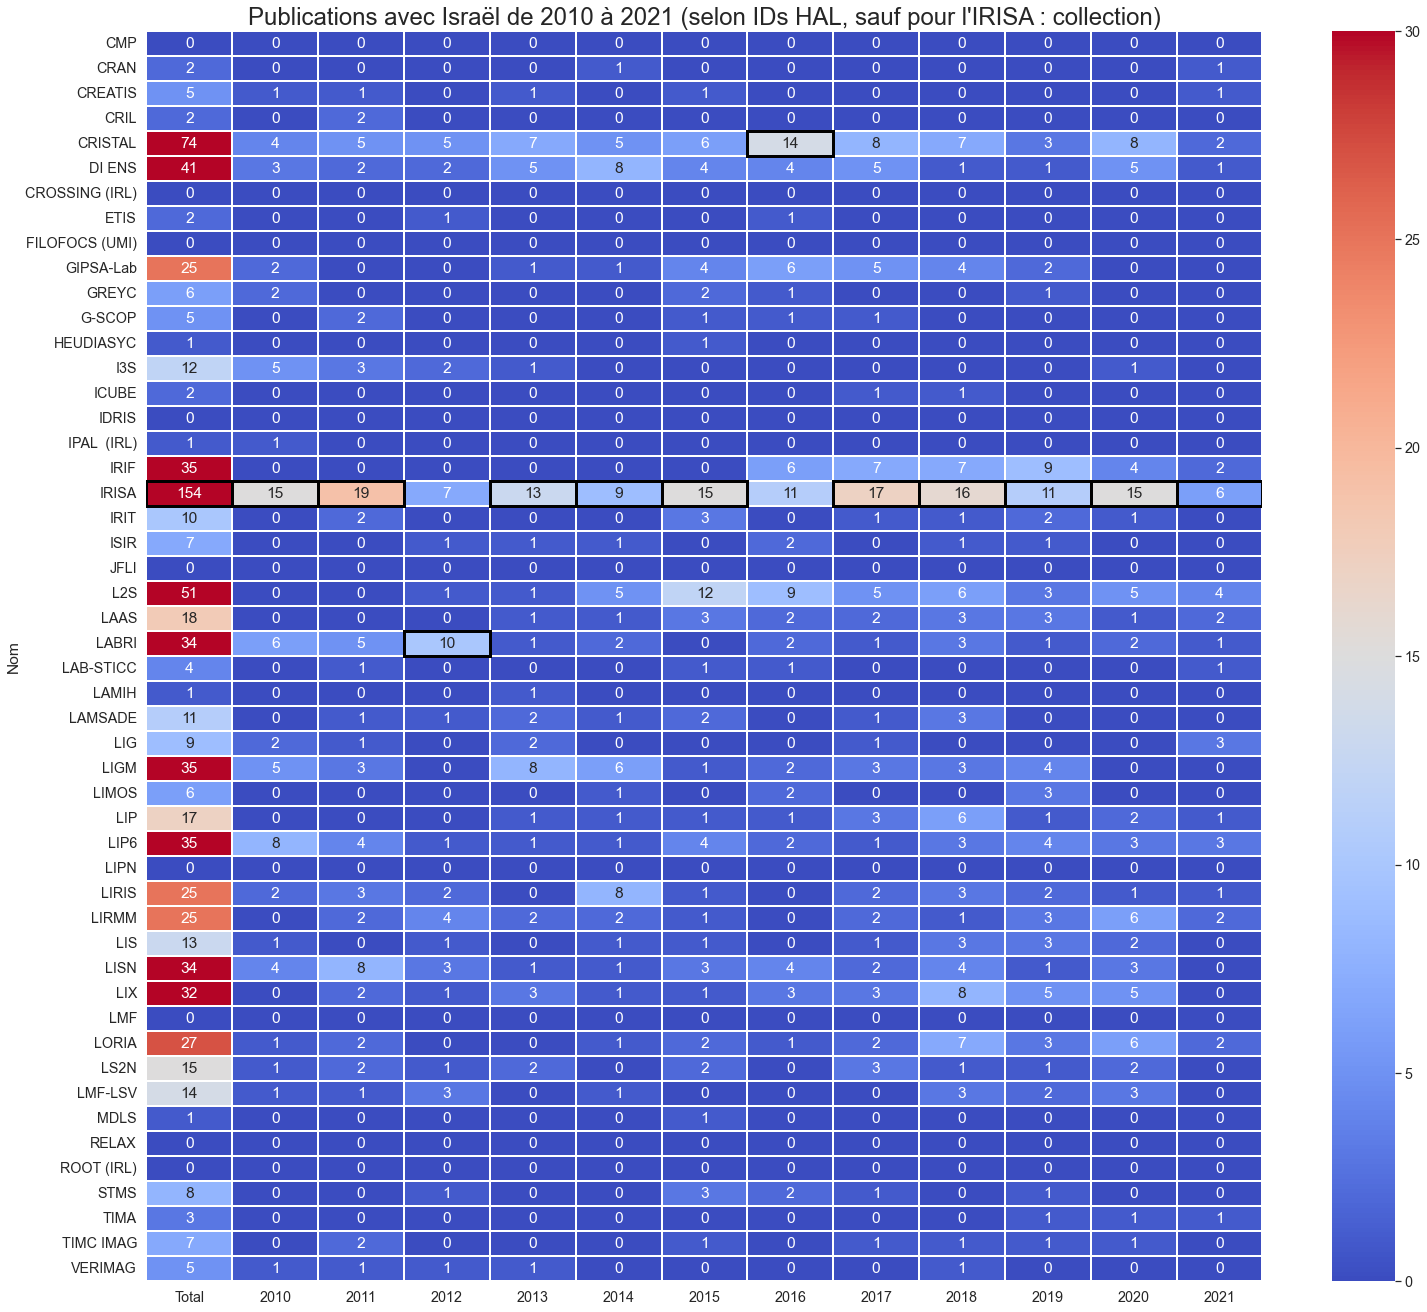

In [138]:
import seaborn as sns
from matplotlib.patches import Rectangle
plt.figure(figsize=(25,23))
sns.set(font_scale = 1.3)
ax = sns.heatmap(evolutionLabo, cmap ='coolwarm', linewidths = 0.30, annot = True, vmax=30, fmt='d')
ax.set_title("Publications avec "+ str(initialesPays[initialesPays['Initiales']==str.upper(codePays)].index.values[0]) + " de 2010 à 2021 (selon IDs HAL, sauf pour l'IRISA : collection)", fontsize=24)
column_max = evolutionLabo.idxmax(axis=0)

for col, variable in enumerate(evolutionLabo.columns):
    position = evolutionLabo.index.get_loc(column_max[variable])
    ax.add_patch(Rectangle((col, position),1,1, fill=False, edgecolor='black', lw=3))

In [10]:
def make_pretty(styler):
    styler.set_caption("Publications avec "+ str(initialesPays[initialesPays['Initiales']=="BR"].index.values[0]) )
    styler.background_gradient(axis=None, vmin=0, vmax=100, cmap="YlGnBu")
    return styler

evolutionLabo.style.pipe(make_pretty)

In [13]:
# Interrogation des collections des laboratoires
codePays='br'
anneeDebut = 2010
anneeFin = 2021

evolutionLabo = pd.DataFrame()
for labo in listeCollectionsLabosINS2I:
    print(labo)
    data = {
        "Nom":labo,
        "Total" : [0]
    }
    for x in range(anneeDebut,anneeFin+1):
        data[x] = [0]
    evolutionLabo = pd.concat([evolutionLabo, pd.DataFrame(data)], ignore_index=True)
evolutionLabo.set_index(['Nom'], inplace=True)
#print(evolutionLabo)

for labo in listeCollectionsLabosINS2I:
    print(labo)
    recherche= "fq=structCountry_s:"+codePays+"&fq=producedDateY_i:["+str(anneeDebut)+" TO "+str(anneeFin)+"]&rows=0&facet=true&facet.field=producedDateY_i&wt=json]"
    try:
        requete = "https://api.archives-ouvertes.fr/search/"+labo+"/?q=*:*&"+recherche
        print(requete)
        reponses = requests.get(requete, timeout=(300,300))
    except requests.ReadTimeout:
        print ("temps limite atteint")
    j = json.loads(reponses.text)
    #print(json.dumps(j, indent=3))
    evolutionLabo.loc[labo,"Total"] = j['response']['numFound']
    liste = j['facet_counts']['facet_fields']['producedDateY_i']
    i = 0
    #la requête renvoie toutes les années possibles : il faut filtrer sur les années voulues
    # autre possibilité, requêter avec https://api.archives-ouvertes.fr/search/CRISTAL/?q=*:*&fq=structCountry_s:il&rows=0&facet=true&facet.range=producedDateY_i&facet.range.start=2010&facet.range.end=2022&facet.range.gap=1&wt=json&indent=true
    # mais dans ce cas il faut changer l'accès json en modifiant la variable "liste" ci-dessus
    while i < len(liste) :
        annee = int(liste[i])
        if annee in evolutionLabo.columns:
            evolutionLabo.loc[labo,annee] += liste[i+1]
        i += 2
display(evolutionLabo)

CRAN
CRIL
CRISTAL
ETIS
GIPSA
GREYC
HEUDIASYC
IPAL
I3S
IRIT
IRISA
ISIR
UMI-3527
LABRI
LIP
LAMIH
LIMOS
LPSM
LAMSADE-DAUPHINE
LS2N
LAB-STICC
G-SCOP
LAAS
LIG
LIGM
LIX
LIP6
LIPN
LIRIS
LIRMM
LIS-LAB
LISN
LORIA
LMF
SUP_LSS
MDLS
RELAX-AUTO
ROOT-TOURS
STMS
TIMA
VERIMAG
CRAN
https://api.archives-ouvertes.fr/search/CRAN/?q=*:*&fq=structCountry_s:br&fq=producedDateY_i:[2010 TO 2021]&rows=0&facet=true&facet.field=producedDateY_i&wt=json]
CRIL
https://api.archives-ouvertes.fr/search/CRIL/?q=*:*&fq=structCountry_s:br&fq=producedDateY_i:[2010 TO 2021]&rows=0&facet=true&facet.field=producedDateY_i&wt=json]
CRISTAL
https://api.archives-ouvertes.fr/search/CRISTAL/?q=*:*&fq=structCountry_s:br&fq=producedDateY_i:[2010 TO 2021]&rows=0&facet=true&facet.field=producedDateY_i&wt=json]
ETIS
https://api.archives-ouvertes.fr/search/ETIS/?q=*:*&fq=structCountry_s:br&fq=producedDateY_i:[2010 TO 2021]&rows=0&facet=true&facet.field=producedDateY_i&wt=json]
GIPSA
https://api.archives-ouvertes.fr/search/GIPSA/?q=*:*&fq

Total  2010  2011  2012  2013  2014  2015  2016  2017  2018  \
Nom                                                                             
CRAN                 78     6     7     4     6     9     6     6     8     5   
CRIL                  6     1     1     1     1     0     1     0     0     0   
CRISTAL              71     4     0     2     5     2     9     7     8    14   
ETIS                 17     2     1     5     2     2     0     0     0     0   
GIPSA                98     7     7    11     3     9    10     8     5     8   
GREYC                19     0     0     1     6     2     5     2     1     0   
HEUDIASYC            54     0     6     2     8     6     8     5     2    10   
IPAL                  2     0     0     0     0     0     0     0     1     0   
I3S                 171    14    11    16    20    11    11    15    19    13   
IRIT                102     3     2     7    11    15    11     9    16     5   
IRISA               360     9    20    29    30    50    36    37    40    29   
ISIR                  4     0     0     0     0     0     0     0     0     0   
UMI-3527              0     0     0     0     0     0     0     0     0     0   
LABRI                 1     0     1     0     0     0     0     0     0     0   
LIP                   3     0     0     0     0     1     1     0     1     0   
LAMIH                55     0     0     0     2     4    11     8     2     7   
LIMOS                22     2     0     2     4     4     0     3     3     2   
LPSM                 17     1     1     0     2     0     1     3     0     3   
LAMSADE-DAUPHINE     14     0     0     2     1     1     2     1     0     1   
LS2N                 16     0     0     0     0     0     0     0     1     5   
LAB-STICC            44     1     1     5     1     4     3     3     1     7   
G-SCOP               43     1     3     5     2     5     3     2     3     6   
LAAS                 71     4     5     5     7     8     5    10     2     3   
LIG                 237    15    19    20    18    24    18    10    23    31   
LIGM                 50     2     0     5     9     1     6     1     6     6   
LIX                  64     3     2     7     2     8     1     2     6     8   
LIP6                148     4    10     6    10     9     8    19    25    18   
LIPN                  3     1     0     0     1     1     0     0     0     0   
LIRIS                35     1     4     0     2     1     8     6     2     1   
LIRMM               226     5    12     8    17    11    12    19    22    45   
LIS-LAB              38     0     0     0     5     4     3     7     4     4   
LISN                 65     1     1     9     7     3     2     3    15     3   
LORIA                72     3     8     3     6     5     5     6     8     6   
LMF                   0     0     0     0     0     0     0     0     0     0   
SUP_LSS              90     5     5     2     2     0     4     6     7    17   
MDLS                  0     0     0     0     0     0     0     0     0     0   
RELAX-AUTO            0     0     0     0     0     0     0     0     0     0   
ROOT-TOURS            1     0     0     0     0     0     0     0     1     0   
STMS                  5     0     0     0     1     1     3     0     0     0   
TIMA                 36     4     1     6     5     1     1     1     2     0   
VERIMAG               0     0     0     0     0     0     0     0     0     0   

                  2019  2020  2021  
Nom                                 
CRAN                 5     6    10  
CRIL                 1     0     0  
CRISTAL             10     2     8  
ETIS                 2     2     1  
GIPSA                6     7    17  
GREYC                1     1     0  
HEUDIASYC            3     1     3  
IPAL                 1     0     0  
I3S                 11    17    13  
IRIT                 6     8     9  
IRISA               23    38    19  
ISIR                 1     1     2  
UMI-3527        

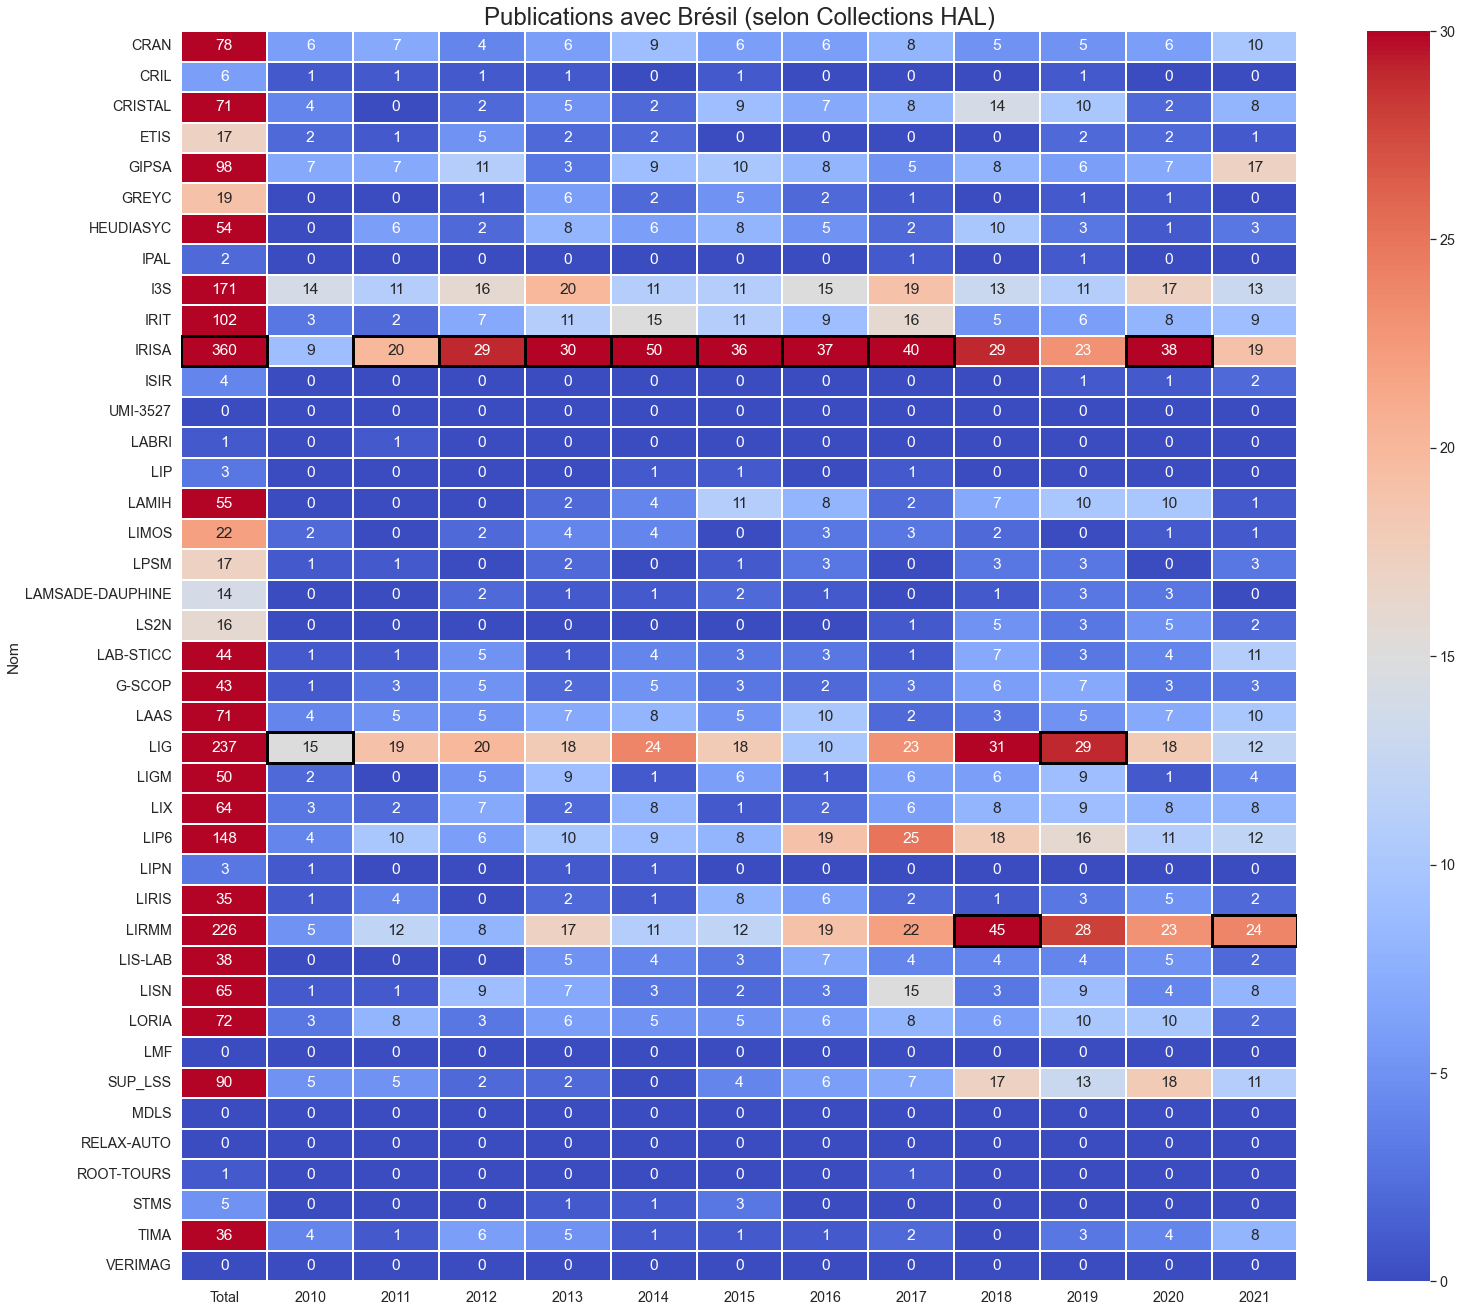

In [15]:
import seaborn as sns
from matplotlib.patches import Rectangle
plt.figure(figsize=(25,23))
sns.set(font_scale = 1.3)
ax = sns.heatmap(evolutionLabo, cmap ='coolwarm', linewidths = 0.30, annot = True, vmax=30, fmt='d')
ax.set_title("Publications avec "+ str(initialesPays[initialesPays['Initiales']==str.upper(codePays)].index.values[0]) + " (selon Collections HAL)", fontsize=24)
column_max = evolutionLabo.idxmax(axis=0)

for col, variable in enumerate(evolutionLabo.columns):
    position = evolutionLabo.index.get_loc(column_max[variable])
    ax.add_patch(Rectangle((col, position),1,1, fill=False, edgecolor='black', lw=3))

# Statistiques sur les publications avec d'autres pays pour chaque laboratoire sur une période donnée

In [38]:
pd.DataFrame(listeLabosINS2I)[0].values

array(['CMP', 'CRAN', 'CREATIS', 'CRIL', 'CRISTAL', 'DI ENS',
       'CROSSING (IRL)', 'ETIS', 'FILOFOCS (UMI)', 'GIPSA-Lab', 'GREYC',
       'G-SCOP', 'HEUDIASYC', 'I3S', 'ICUBE', 'IDRIS', 'IPAL  (IRL)',
       'IRIF', 'IRISA', 'IRIT', 'ISIR', 'JFLI', 'L2S', 'LAAS', 'LABRI',
       'LAB-STICC', 'LAMIH', 'LAMSADE', 'LIG', 'LIGM', 'LIMOS', 'LIP',
       'LIP6', 'LIPN', 'LIRIS', 'LIRMM', 'LIS', 'LISN', 'LIX', 'LMF',
       'LORIA', 'LS2N', 'LMF-LSV', 'MDLS', 'RELAX', 'ROOT (IRL)', 'STMS',
       'TIMA', 'TIMC IMAG', 'VERIMAG'], dtype=object)

In [41]:
# Interrogation avec les IDs des laboratoires
anneeDebut = 2016
anneeFin = 2020

data = { x : [0] for x in initialesPays['Initiales'] }
evolutionLabo = pd.DataFrame(data, index =  pd.DataFrame(listeLabosINS2I)[0])
#evolutionLabo.head()
for labo in listeLabosINS2I:
    print(labo)
    listeIds = "("
    premierId = True
    for id in labo[1]:
        if not premierId:
            listeIds += " OR "
        else:
            premierId = False
        listeIds += str(id)
    listeIds += ")"
    recherche= "structId_i:"+listeIds+"&fq=producedDateY_i:["+str(anneeDebut)+" TO "+str(anneeFin)+"]&rows=0&facet=true&facet.field=structCountry_s&f.structCountry_s.facet.limit=260&wt=json"
    try:
        requete = "https://api.archives-ouvertes.fr/search/CNRS/?q="+recherche
        print(requete)
        reponses = requests.get(requete, timeout=(300,300))
    except requests.ReadTimeout:
        print ("temps limite atteint")
    j = json.loads(reponses.text)
    #print(json.dumps(j, indent=3))
    liste = j['facet_counts']['facet_fields']['structCountry_s']
    i=0
    while i < len(liste):
        #print(str(liste[i])+" "+ str(liste[i+1]))
        pays = liste[i].upper()
        if pays in evolutionLabo.columns:
            evolutionLabo.loc[labo[0],pays] += int(liste[i+1])
        else:
            if (liste[i+1]>0):
                print("Pays non trouvé : "+pays+" avec "+str(liste[i+1])+" publications")
        i += 2
    #display(evolutionLabo)
display(evolutionLabo)

('CMP', {244423})
https://api.archives-ouvertes.fr/search/CNRS/?q=structId_i:(244423)&fq=producedDateY_i:[2016 TO 2020]&rows=0&facet=true&facet.field=structCountry_s&f.structCountry_s.facet.limit=260&wt=json
('CRAN', {185180})
https://api.archives-ouvertes.fr/search/CNRS/?q=structId_i:(185180)&fq=producedDateY_i:[2016 TO 2020]&rows=0&facet=true&facet.field=structCountry_s&f.structCountry_s.facet.limit=260&wt=json
('CREATIS', {139739})
https://api.archives-ouvertes.fr/search/CNRS/?q=structId_i:(139739)&fq=producedDateY_i:[2016 TO 2020]&rows=0&facet=true&facet.field=structCountry_s&f.structCountry_s.facet.limit=260&wt=json
('CRIL', {90448, 1628})
https://api.archives-ouvertes.fr/search/CNRS/?q=structId_i:(90448 OR 1628)&fq=producedDateY_i:[2016 TO 2020]&rows=0&facet=true&facet.field=structCountry_s&f.structCountry_s.facet.limit=260&wt=json
('CRISTAL', {410272})
https://api.archives-ouvertes.fr/search/CNRS/?q=structId_i:(410272)&fq=producedDateY_i:[2016 TO 2020]&rows=0&facet=true&facet.fi

AF  ZA  AX  AL  DZ   DE  DD  AD  AO  AI  ...  VA  VE  VN  VD  \
0                                                        ...                   
CMP              0   0   0   0   0    0   0   0   0   0  ...   0   0   0   0   
CRAN             0   0   0   0  36   43   0   0   0   0  ...   0   1   3   0   
CREATIS          0   0   0   0   2   81   0   0   0   0  ...   0   0   0   0   
CRIL             0   1   0   0  13    7   0   0   0   0  ...   0   1   4   0   
CRISTAL          0   3   0   0  50   67   0   0   0   0  ...   0   0   2   0   
DI ENS           0   0   0   0   1   51   0   0   0   0  ...   0   0   2   0   
CROSSING (IRL)   0   0   0   0   0    1   0   0   0   0  ...   0   0   0   0   
ETIS             0   0   0   0   6   22   0   0   0   0  ...   0   0   0   0   
FILOFOCS (UMI)   0   0   0   0   0    0   0   0   0   0  ...   0   0   0   0   
GIPSA-Lab        0   2   0   0  10   67   0   0   0   0  ...   0   3  18   0   
GREYC            0   1   0   0  36   26   0   0   0   0  ...   0   0   0   0   
G-SCOP           0   0   0   0   2   19   0   0   0   0  ...   0   0   1   0   
HEUDIASYC        0   1   0   3  38   11   0   0   0   0  ...   0   0   1   0   
I3S              0   0   0   0   2   50   0   0   0   0  ...   0   1   9   0   
ICUBE            0   0   0   0   8   41   0   0   0   0  ...   0   0   0   0   
IDRIS            0   0   0   0   0    0   0   0   0   0  ...   0   0   0   0   
IPAL  (IRL)      0   0   0   0   0    1   0   0   0   0  ...   0   0   0   0   
IRIF             0   1   0   0   0   35   0   0   0   0  ...   0   0   1   0   
IRISA            0  15   0   1  50  212   0   0   0   0  ...   0   2   6   0   
IRIT             0   8   0   3  64  129   0   0   0   0  ...   0   2  35   0   
ISIR             0   2   0   0   1   18   0   0   0   0  ...   0   0   1   0   
JFLI             0   0   0   0   0    4   0   0   0   0  ...   0   0   2   0   
L2S              0   2   0   0  28   48   0   0   0   0  ...   0   0   3   0   
LAAS             0   0   0   0   9   92   0   1   0   0  ...   0   6   3   0   
LABRI            0   2   0   0  22  117   0   0   0   0  ...   0   0   1   0   
LAB-STICC        0   5   0   0  97   62   0   0   0   0  ...   0   0   8   0   
LAMIH            0   0   0   0  30   23   0   0   0   0  ...   0  10   2   0   
LAMSADE          0   0   0   0   3   38   0   0   0   0  ...   0  10   1   0   
LIG              0   1   0   0   9  124   0   0   0   0  ...   0   0  10   0   
LIGM             0   0   0   0  22   41   0   0   0   0  ...   0   0   0   0   
LIMOS            0   3   0   0   8   19   0   0   0   0  ...   0   0   0   0   
LIP              0   0   0   1   0   22   0   0   0   0  ...   0   0   4   0   
LIP6             0   3   0   0  27  103   0   0   0   0  ...   0   0   4   0   
LIPN             0   2   0   0   3    4   0   0   0   0  ...   0   0   1   0   
LIRIS            0  10   0   0  49   60   0   0   0   0  ...   0   0   0   0   
LIRMM            0   6   0   0  32  129   0   0   0   0  ...   0   0   4   0   
LIS              0   2   0   0  26   45   0   0   0   0  ...   0   0   3   0   
LISN             0   0   0   0   4  155   0   1   0   0  ...   0   0   8   0   
LIX              0   5   0   0   2   50   0   0   0   0  ...   0   1   2   0   
LMF              0   0   0   0   0    1   0   0   0   0  ...   0   0   0   0   
LORIA            0   0   0   0  44  352   0   0   0   0  ...   0   1   3   0   
LS2N             0   2   0   0  50  118   0   0   0   0  ...   0   7   6   0   
LMF-LSV          0   0   0   0   0   34   0   0   0   0  ...   0   0   0   0   
MDLS             0   0   0   0   0   18   0   0   0   0  ...   0   0   1   0   
RELAX            0   0   0   0   0    0   0   0   0   0  ...   0   0   0   0   
ROOT (IRL)       0   0   0   0   0    1   0   0   0   0  ...   0   0   0   0   
STMS             0   4   0   0   0   32   0   0   0   0  ...   0   0   0   0   
TIMA             0   0   0   0   2   14   0   0   0   0  ...   0   0   0   0   
TIMC IMAG       

## Interrogation avec une seule requête pour l'ensemble des labos INS2I ( = sans doublons)

In [15]:
# Création de la requête
# Interrogation avec les IDs des laboratoires avec une seule requête pour l'ensemble des labos (ELIMINATION DES DOUBLONS)
anneeDebut = 2016
anneeFin = 2020

data = { x : [0] for x in initialesPays['Initiales'] }
evolutionLabo = pd.DataFrame(data, index =  ["Total INS2I"])
#evolutionLabo.head()
premierId = True
for labo in listeLabosINS2I:
    print(labo)
    if premierId:
        listeIds = "("
    for id in labo[1]:
        if not premierId:
            listeIds += " OR "
        else:
            premierId = False
        listeIds += str(id)
listeIds += ")"
recherche= "structId_i:"+listeIds+"&fq=producedDateY_i:["+str(anneeDebut)+" TO "+str(anneeFin)+"]&rows=0&facet=true&facet.field=structCountry_s&f.structCountry_s.facet.limit=260&wt=json"
print(recherche)
print(evolutionLabo)

('CMP', {244423})
('CRAN', {185180})
('CREATIS', {139739})
('CRIL', {90448, 1628})
('CRISTAL', {410272})
('DI ENS', {25027})
('CROSSING (IRL)', {1063106})
('ETIS', {1003474, 1087906, 1003348, 1061575})
('FILOFOCS (UMI)', {1006288, 1006289})
('GIPSA-Lab', {1042376, 1043333, 24470})
('GREYC', {150})
('G-SCOP', {74240, 1043137, 1041927})
('HEUDIASYC', {389870})
('I3S', {552896, 13009, 1079434})
('ICUBE', {217648, 1073080})
('IDRIS', {1823})
('IPAL  (IRL)', {220880, 542003, 138926})
('IRIF', {1005016, 444497})
('IRISA', {105128, 490899, 8621, 2494})
('IRIT', {34499, 1082335})
('ISIR', {541937, 96164})
('JFLI', {542009, 229050})
('L2S', {1289, 1051117})
('LAAS', {459})
('LABRI', {3102})
('LAB-STICC', {199324, 1089048, 486345, 491660, 81533})
('LAMIH', {1067790, 1303})
('LAMSADE', {989})
('LIG', {1041964, 1043301, 24471})
('LIGM', {3210, 1001627})
('LIMOS', {857, 490706, 1063677})
('LIP', {35418})
('LIP6', {233, 541703, 1095103})
('LIPN', {1000994, 994, 1086916, 1056718})
('LIRIS', {1086665,

In [16]:
#Exécution de la requête unique
try:
    requete = "https://api.archives-ouvertes.fr/search/CNRS/?q="+recherche
    print(requete)
    reponses = requests.get(requete, timeout=(300,300))
except requests.ReadTimeout:
    print ("temps limite atteint")
j = json.loads(reponses.text)
#print(json.dumps(j, indent=3))
liste = j['facet_counts']['facet_fields']['structCountry_s']
i=0
while i < len(liste):
    #print(str(liste[i])+" "+ str(liste[i+1]))
    pays = liste[i].upper()
    if pays in evolutionLabo.columns:
        evolutionLabo[pays] += int(liste[i+1])
    else:
        if (liste[i+1]>0):
            print("Pays non trouvé : "+pays+" avec "+str(liste[i+1])+" publications")
    i += 2

display(evolutionLabo)

https://api.archives-ouvertes.fr/search/CNRS/?q=structId_i:(244423 OR 185180 OR 139739 OR 90448 OR 1628 OR 410272 OR 25027 OR 1063106 OR 1003474 OR 1087906 OR 1003348 OR 1061575 OR 1006288 OR 1006289 OR 1042376 OR 1043333 OR 24470 OR 150 OR 74240 OR 1043137 OR 1041927 OR 389870 OR 552896 OR 13009 OR 1079434 OR 217648 OR 1073080 OR 1823 OR 220880 OR 542003 OR 138926 OR 1005016 OR 444497 OR 105128 OR 490899 OR 8621 OR 2494 OR 34499 OR 1082335 OR 541937 OR 96164 OR 542009 OR 229050 OR 1289 OR 1051117 OR 459 OR 3102 OR 199324 OR 1089048 OR 486345 OR 491660 OR 81533 OR 1067790 OR 1303 OR 989 OR 1041964 OR 1043301 OR 24471 OR 3210 OR 1001627 OR 857 OR 490706 OR 1063677 OR 35418 OR 233 OR 541703 OR 1095103 OR 1000994 OR 994 OR 1086916 OR 1056718 OR 1086665 OR 2003 OR 1071941 OR 181 OR 199394 OR 178374 OR 527033 OR 199402 OR 862 OR 1041968 OR 247329 OR 2544 OR 1050003 OR 81750 OR 1061259 OR 1070048 OR 1041697 OR 1071530 OR 2071 OR 1065710 OR 206040 OR 466633 OR 1088564 OR 473973 OR 1693 OR 954

AF  ZA  AX  AL   DZ    DE  DD  AD  AO  AI  ...  VA  VE   VN  VD  \
Total INS2I   0  84   0   7  750  2311   0   2   0   0  ...   0  49  141   0   

             WF  YE  YU  ZR  ZM  ZW  
Total INS2I   0   1   0   0   0   3  

[1 rows x 258 columns]

In [27]:
evolutionLabo.set_axis(initialesPays.index, axis=1, inplace=True)
totalPays = pd.Series(evolutionLabo.iloc[0]).sort_values(ascending=False)
totalPays

Nom
France                                                 65188
Etats-Unis d'Amérique                                   3916
Royaume-Uni de Grande-Bretagne et d'Irlande du Nord     2388
Italie                                                  2325
Allemagne                                               2311
                                                       ...  
Indien (Territoire britannique de l'océan)                 0
Jamaïque                                                   0
Jersey                                                     0
Kirghizistan                                               0
Libéria                                                    0
Name: Total INS2I, Length: 258, dtype: int64

In [29]:
totalPays.to_csv("StatsPaysINS2I.csv")

## Interrogations individuelles des collections des labos

In [46]:
# Interrogation des collections des laboratoires
anneeDebut = 2016
anneeFin = 2020

data = { x : [0] for x in initialesPays['Initiales'] }
evolutionLabo = pd.DataFrame(data, index =  listeCollectionsLabosINS2I)
#evolutionLabo.head()
for labo in listeCollectionsLabosINS2I:
    print(labo)
    recherche= "fq=producedDateY_i:["+str(anneeDebut)+" TO "+str(anneeFin)+"]&rows=0&facet=true&facet.field=structCountry_s&f.structCountry_s.facet.limit=260&wt=json"
    try:
        requete = "https://api.archives-ouvertes.fr/search/"+labo+"/?q=*:*&"+recherche
        print(requete)
        reponses = requests.get(requete, timeout=(300,300))
    except requests.ReadTimeout:
        print ("temps limite atteint")
    j = json.loads(reponses.text)
    #print(json.dumps(j, indent=3))
    liste = j['facet_counts']['facet_fields']['structCountry_s']
    i=0
    while i < len(liste):
        #print(str(liste[i])+" "+ str(liste[i+1]))
        pays = liste[i].upper()
        if pays in evolutionLabo.columns:
            evolutionLabo.loc[labo,pays] += int(liste[i+1])
        else:
            if (liste[i+1]>0):
                print("Pays non trouvé : "+pays+" avec "+str(liste[i+1])+" publications")
        i += 2
    #display(evolutionLabo)
display(evolutionLabo)

CRAN
https://api.archives-ouvertes.fr/search/CRAN/?q=*:*&fq=producedDateY_i:[2016 TO 2020]&rows=0&facet=true&facet.field=structCountry_s&f.structCountry_s.facet.limit=260&wt=json
CRIL
https://api.archives-ouvertes.fr/search/CRIL/?q=*:*&fq=producedDateY_i:[2016 TO 2020]&rows=0&facet=true&facet.field=structCountry_s&f.structCountry_s.facet.limit=260&wt=json
CRISTAL
https://api.archives-ouvertes.fr/search/CRISTAL/?q=*:*&fq=producedDateY_i:[2016 TO 2020]&rows=0&facet=true&facet.field=structCountry_s&f.structCountry_s.facet.limit=260&wt=json
ETIS
https://api.archives-ouvertes.fr/search/ETIS/?q=*:*&fq=producedDateY_i:[2016 TO 2020]&rows=0&facet=true&facet.field=structCountry_s&f.structCountry_s.facet.limit=260&wt=json
GIPSA
https://api.archives-ouvertes.fr/search/GIPSA/?q=*:*&fq=producedDateY_i:[2016 TO 2020]&rows=0&facet=true&facet.field=structCountry_s&f.structCountry_s.facet.limit=260&wt=json
GREYC
https://api.archives-ouvertes.fr/search/GREYC/?q=*:*&fq=producedDateY_i:[2016 TO 2020]&rows

AF  ZA  AX  AL  DZ   DE  DD  AD  AO  AI  ...  VA  VE  VN  \
CRAN               0   0   0   0  36   43   0   0   0   0  ...   0   1   3   
CRIL               0   1   0   0  13    7   0   0   0   0  ...   0   1   4   
CRISTAL            0   4   0   0  51   76   0   0   0   0  ...   0   0   2   
ETIS               0   0   0   0   6   23   0   0   0   0  ...   0   0   0   
GIPSA              0   2   0   0  10   67   0   0   0   0  ...   0   3  18   
GREYC              0   1   0   0  35   26   0   0   0   0  ...   0   0   0   
HEUDIASYC          0   1   0   3  37    9   0   0   0   0  ...   0   0   1   
IPAL               0   0   0   0   0    1   0   0   0   0  ...   0   0   0   
I3S                0   0   0   0   2   50   0   0   0   0  ...   0   1   9   
IRIT               0   8   0   3  64  129   0   0   0   0  ...   0   2  35   
IRISA              0  16   0   1  51  216   0   0   0   0  ...   0   2   6   
ISIR               0   2   0   0   3   18   0   0   0   0  ...   0   0   1   
UMI-3527           0   0   0   0   0    4   0   0   0   0  ...   0   0   2   
LABRI              0   1   0   0   0    2   0   0   0   0  ...   0   0   0   
LIP                0   0   0   0   0    1   0   0   0   0  ...   0   0   0   
LAMIH              0   0   0   0  29   23   0   0   0   0  ...   0  10   2   
LIMOS              0   3   0   0   8   19   0   0   0   0  ...   0   0   0   
LPSM               0   1   0   0   0   20   0   0   0   0  ...   0   0   0   
LAMSADE-DAUPHINE   0   0   0   0   3   38   0   0   0   0  ...   0  10   1   
LS2N               0   2   0   0  45   97   0   0   0   0  ...   0   7   6   
LAB-STICC          0   5   0   0  97   62   0   0   0   0  ...   0   0   8   
G-SCOP             0   0   0   0   2   19   0   0   0   0  ...   0   0   1   
LIG                0   1   0   0   9  126   0   0   0   0  ...   0   0  10   
LIGM               0   0   0   0  22   43   0   0   0   0  ...   0   0   0   
LIX                0   5   0   0   2   50   0   0   0   0  ...   0   1   2   
LIP6               0   3   0   0  27  103   0   0   0   0  ...   0   0   4   
LIPN               0   2   0   0   3    4   0   0   0   0  ...   0   0   1   
LIRIS              0  10   0   0  49   60   0   0   0   0  ...   0   0   0   
LIRMM              0   7   0   0  32  130   0   0   0   0  ...   0   2   6   
LIS-LAB            0   2   0   0  26   45   0   0   0   0  ...   0   0   3   
LISN               0   0   0   0   2  119   0   0   0   0  ...   0   0   8   
LORIA              0   0   0   0  44  352   0   0   0   0  ...   0   1   3   
LMF                0   0   0   0   0    1   0   0   0   0  ...   0   0   0   
SUP_LSS            0   2   0   0  28   48   0   0   0   0  ...   0   0   3   
MDLS               0   0   0   0   0   18   0   0   0   0  ...   0   0   1   
RELAX-AUTO         0   0   0   0   0    0   0   0   0   0  ...   0   0   0   
ROOT-TOURS         0   0   0   0   0    3   0   0   0   0  ...   0   0   4   
STMS               0   4   0   0   0   32   0   0   0   0  ...   0   0   0   
TIMA               0   0   0   0   2   17   0   0   0   0  ...   0   0   0   
VERIMAG            0   0   0   0   0    8   0   0   0   0  ...   0   0   0   

                  VD  WF  YE  YU  ZR  ZM  ZW  
CRAN               0   0   0   0   0   0   0  
CRIL               0   0   0   0   0   0   0  
CRISTAL            0   0   1   0   0   0   0  
ETIS               0   0   0   0   0   0   0  
GIPSA              0   0   0   0   0   0   0  
GREYC              0   0   0   0   0   0   0  
HEUDIASYC          0   0   0   0   0   0   0  
IPAL               0   0   0   0   0   0   0  
I3S                0   0   0   0   0   0   0  
IRIT               0   0   0   0   0   0   0  
IRISA              0   0   0   0   0   0   0  
ISIR               0   0   0   0   0   0   0  
UMI-3527           0   0   0   0   0   0   0  
LABRI              0   0   0   0   0   0   0  
LIP                0   0   0   0   0   0   0  
LAMIH              0   0   0   0   0   0   0  
LIMOS              0

In [82]:
evolutionLabo.to_csv("StatsPaysLabo_ID.csv")
#evolutionLabo.to_csv("StatsPaysLabo_Collections.csv")

In [83]:
evolutionLabo = pd.read_csv("StatsPaysLabo_ID.csv", index_col=0)
#evolutionLabo = pd.read_csv("StatsPaysLabo_Collections.csv", index_col=0)
evolutionLabo.info()
evolutionLabo.head()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, CMP to VERIMAG
Columns: 258 entries, AF to ZW
dtypes: int64(258)
memory usage: 101.2+ KB


AF  ZA  AX  AL  DZ  DE  DD  AD  AO  AI  ...  VA  VE  VN  VD  WF  YE  \
0                                                ...                           
CMP       0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
CRAN      0   0   0   0  36  43   0   0   0   0  ...   0   1   3   0   0   0   
CREATIS   0   0   0   0   2  81   0   0   0   0  ...   0   0   0   0   0   0   
CRIL      0   1   0   0  13   7   0   0   0   0  ...   0   1   4   0   0   0   
CRISTAL   0   3   0   0  50  67   0   0   0   0  ...   0   0   2   0   0   1   

         YU  ZR  ZM  ZW  
0                        
CMP       0   0   0   0  
CRAN      0   0   0   0  
CREATIS   0   0   0   0  
CRIL      0   0   0   0  
CRISTAL   0   0   0   0  

[5 rows x 258 columns]

## Enregistrement des statistiques sur les pays puis affichage carte

In [84]:
evolutionLabo.set_axis(initialesPays.index, axis=1, inplace=True)

In [44]:
evolutionLabo2 = evolutionLabo.drop('France', axis=1)

In [99]:
# attention : selon la requête employée,la ligne ci-dessous effectue des additions par labo qui entraînent des doublons
# si une seule requête fusionnée a été lancée (cf. plus haut) alors la sum de la ligne ci-dessous n'agit que sur un tableau avec une seule ligne = pas d'addition ;-) sinon avec tableaux requêtes multiples, la somme
# est vraiment effectuée (mais dans ce cas avec doublons ...)
totalPays = pd.Series(evolutionLabo.sum(axis=0).sort_values(ascending=False)) # si on veut garder France dans le tableau -> utile pour carte monde
#totalPays = evolutionLabo2.sum(axis=0).sort_values(ascending=False) # si on ne veut pas garder France -> utile pour heatmap
totalPays.rename('total', inplace=True)
totalPays.head()

Nom
France                                                 71014
Etats-Unis d'Amérique                                   4366
Royaume-Uni de Grande-Bretagne et d'Irlande du Nord     2640
Allemagne                                               2618
Italie                                                  2523
Name: total, dtype: int64

In [100]:
totalPays.to_csv("TotalINS2IPays_ID.csv")
#totalPays.to_csv("TotalINS2IPays_Collections.csv")

In [101]:
totalPays = pd.read_csv("TotalINS2IPays_ID.csv", index_col=0)
#totalPays = pd.read_csv("TotalINS2IPays_Collections.csv")
totalPays.head()

total
Nom                                                      
France                                              71014
Etats-Unis d'Amérique                                4366
Royaume-Uni de Grande-Bretagne et d'Irlande du ...   2640
Allemagne                                            2618
Italie                                               2523

In [102]:
totalPaysDF = pd.DataFrame(totalPays, index=totalPays.index, columns=['total'])
totalPaysDF.info()
totalPaysDF.head()

<class 'pandas.core.frame.DataFrame'>
Index: 258 entries, France to Libéria
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   total   258 non-null    int64
dtypes: int64(1)
memory usage: 4.0+ KB


total
Nom                                                      
France                                              71014
Etats-Unis d'Amérique                                4366
Royaume-Uni de Grande-Bretagne et d'Irlande du ...   2640
Allemagne                                            2618
Italie                                               2523

In [103]:
totalPaysDF = totalPaysDF.assign(iso_a3 = lambda x : initialesPays.loc[x.index,'ISO'])
totalPaysDF.head()

total iso_a3
Nom                                                             
France                                              71014    FRA
Etats-Unis d'Amérique                                4366    USA
Royaume-Uni de Grande-Bretagne et d'Irlande du ...   2640    GBR
Allemagne                                            2618    DEU
Italie                                               2523    ITA

In [104]:
sommePays = totalPaysDF.groupby('iso_a3')['total'].sum()
sommePays.head()

iso_a3
AFG      0
AGO      0
ALB      9
ARE     95
ARG    227
Name: total, dtype: int64

In [105]:
sommePays.to_csv("SommePays_ID.csv")
#sommePays.to_csv("SommePays_Collections.csv")

In [ ]:
sommePays = pd.read_csv("SommePays_ID.csv", index_col=0)
#sommePays = pd.read_csv("SommePays_Collections.csv", index_col=0)

In [51]:
sommePays.head()

iso_a3
AFG      0
AGO      0
ALB      9
ARE     95
ARG    227
Name: total, dtype: int64

In [67]:
# récupération des localisations des pays dans GeoPandas
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

In [68]:
world.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   pop_est     177 non-null    int64   
 1   continent   177 non-null    object  
 2   name        177 non-null    object  
 3   iso_a3      177 non-null    object  
 4   gdp_md_est  177 non-null    float64 
 5   geometry    177 non-null    geometry
dtypes: float64(1), geometry(1), int64(1), object(3)
memory usage: 8.4+ KB


In [69]:
# affichage des codes iso absents
lignesAbsentes = world.loc[world.iso_a3=='-99']
print(lignesAbsentes)
# correction des codes pour certains pays
world.loc[world['name']=='France','iso_a3']='FRA'
world.loc[world['name']=='Norway','iso_a3']='NOR'

      pop_est continent        name iso_a3  gdp_md_est  \
21    5320045    Europe      Norway    -99    364700.0   
43   67106161    Europe      France    -99   2699000.0   
160    265100      Asia   N. Cyprus    -99      3600.0   
167   3500000    Africa  Somaliland    -99     12250.0   
174   1895250    Europe      Kosovo    -99     18490.0   

                                              geometry  
21   MULTIPOLYGON (((15.14282 79.67431, 15.52255 80...  
43   MULTIPOLYGON (((-51.65780 4.15623, -52.24934 3...  
160  POLYGON ((32.73178 35.14003, 32.80247 35.14550...  
167  POLYGON ((48.94820 11.41062, 48.94820 11.41062...  
174  POLYGON ((20.59025 41.85541, 20.52295 42.21787...  


In [100]:
world.to_file("world")

/Users/Patrice/opt/anaconda3/envs/ins2ipublis/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [94]:
world.head()

pop_est      continent                      name iso_a3  gdp_md_est  \
0     920938        Oceania                      Fiji    FJI      8374.0   
1   53950935         Africa                  Tanzania    TZA    150600.0   
2     603253         Africa                 W. Sahara    ESH       906.5   
3   35623680  North America                    Canada    CAN   1674000.0   
4  326625791  North America  United States of America    USA  18560000.0   

                                            geometry  
0  MULTIPOLYGON (((180 -16.067132663642447, 180 -...  
1  POLYGON ((33.90371119710453 -0.950000000000000...  
2  POLYGON ((-8.665589565454809 27.65642588959235...  
3  MULTIPOLYGON (((-122.84000000000003 49.0000000...  
4  MULTIPOLYGON (((-122.84000000000003 49.0000000...

In [140]:
world = geopandas.read_file("world")

<AxesSubplot:>

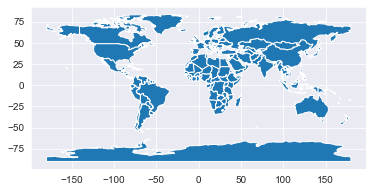

In [102]:
world.plot()

In [106]:
monde = pd.merge(world,sommePays,on='iso_a3')
monde.head()

pop_est      continent                      name iso_a3  gdp_md_est  \
0     920938        Oceania                      Fiji    FJI      8374.0   
1   53950935         Africa                  Tanzania    TZA    150600.0   
2   35623680  North America                    Canada    CAN   1674000.0   
3  326625791  North America  United States of America    USA  18560000.0   
4   18556698           Asia                Kazakhstan    KAZ    460700.0   

                                            geometry  total  
0  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...      5  
1  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...      3  
2  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...   1802  
3  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...   4366  
4  POLYGON ((87.35997 49.21498, 86.59878 48.54918...      8

<AxesSubplot:>

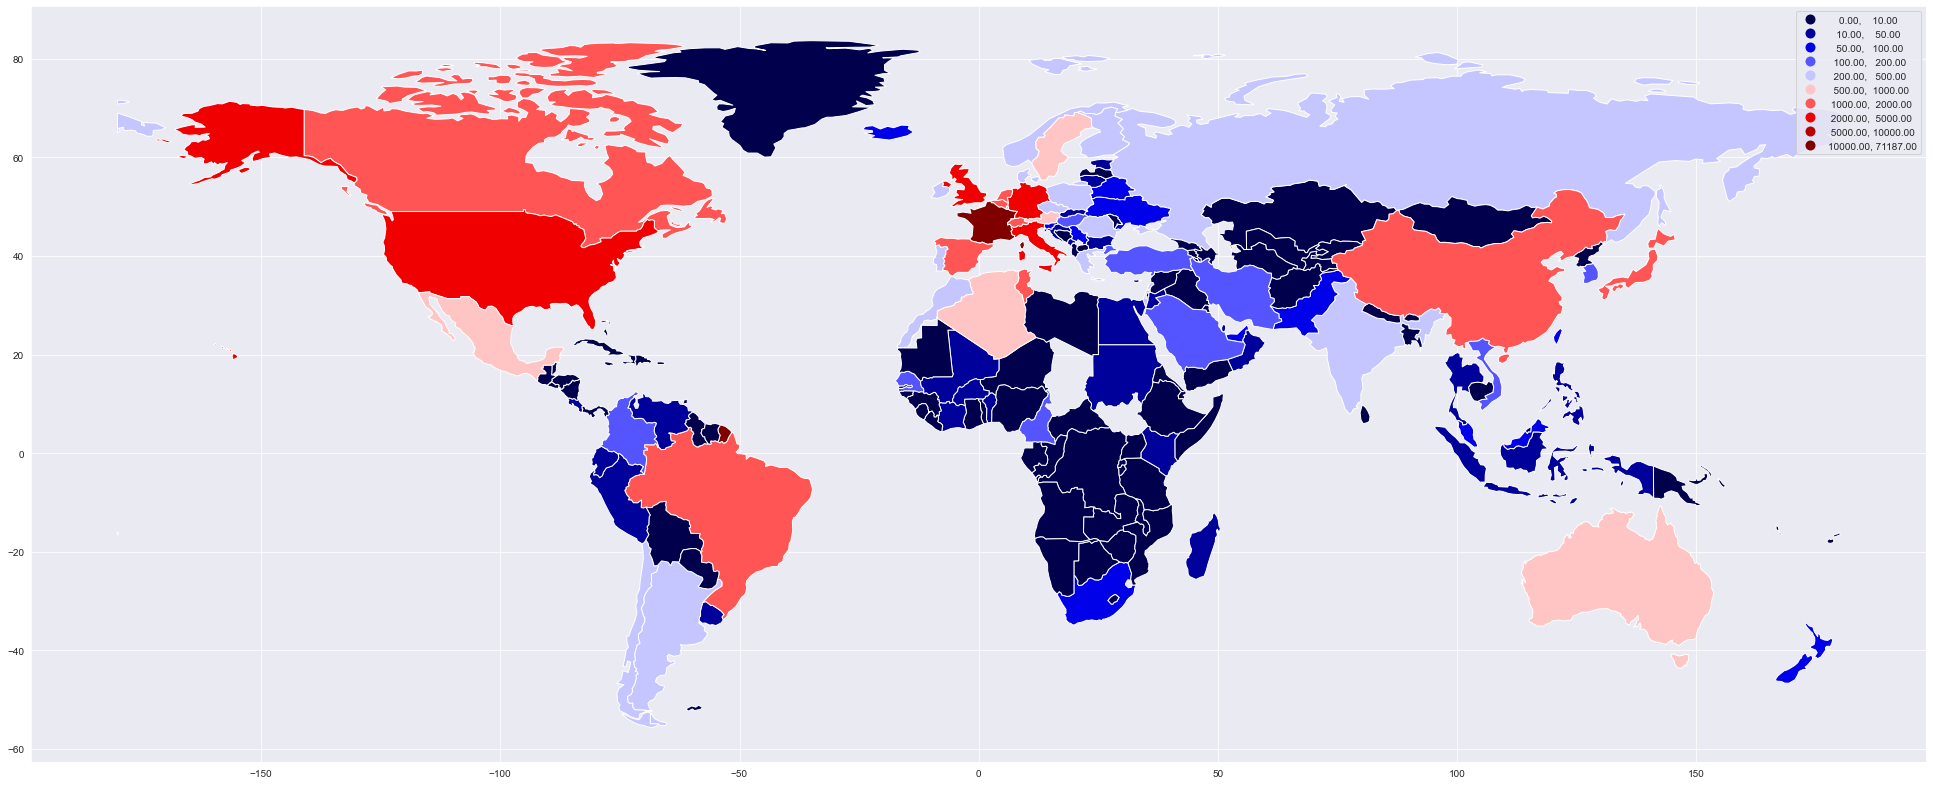

In [107]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from geopandas import GeoDataFrame
from shapely.geometry import Point
fig, ax = plt.subplots(1, 1, figsize=(35,35))
divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.1)
#monde.plot(column='total', ax=ax, legend=True, scheme='quantiles')
monde.plot(column='total', ax=ax, legend=True, scheme='User_Defined', cmap='seismic', classification_kwds=dict(bins=[10,50,100,200,500,1000,2000,5000,10000]))
#monde.plot(column='total', ax=ax, legend=True, cax=cax, scheme='quantiles')
#for x, y, label in zip(monde.geometry.x, monde.geometry.y, monde.name):
#    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
#calcul des points où rajouter les noms des pays
#cf. https://github.com/shotleft/how-to-python/blob/master/How%20it%20works%20-%20labelling%20districts%20in%20GeoPandas.ipynb
#import adjustText as aT
#monde["center"] = monde["geometry"].centroid
#monde_points = monde.copy()
#monde_points.set_geometry("center", inplace=True)

#texts=[]
#for x, y, label in zip(monde_points.geometry.x, monde_points.geometry.y, monde_points["name"]):
#    texts.append(plt.text(x, y, label, fontsize = 12))

#aT.adjust_text(texts, force_points=0.3, force_text=0.8, expand_points=(1,1), expand_text=(1,1),
#                   arrowprops=dict(arrowstyle="-", color='grey', lw=0.5))

In [52]:
colonnesNulles = [col for col in evolutionLabo2.columns if evolutionLabo2[col].max()==0]
print(colonnesNulles)
evolutionLabo2 = evolutionLabo2.drop(colonnesNulles, axis=1)
display(evolutionLabo2)

['Afghanistan', 'Åland, Îles', "Allemagne de l'EST", 'Angola', 'Anguilla', 'Antarctique', 'Antigua et Barbuda', 'Antilles néerlandaises', 'Aruba', 'Azerbaïdjan', 'Bahamas', 'Barbade', 'Bélize', 'Bermudes', 'Bhoutan', 'Bolivie (État plurinational de)', 'Bonaire, Saint-Eustache et Saba', 'Bouvet, Ile', 'Brunéi Darussalam', 'Burundi', 'Cabo Verde', 'Caïmans, Iles', 'Christmas, île', 'Cocos/Keeling (Îles)', 'Comores', 'Congo', 'Cook, Iles', 'Corée, République populaire démocratique de', 'Curaçao', 'Djibouti', 'Dominicaine, République', 'Dominique', 'El Salvador', 'Erythrée', 'Falkland/Malouines (Îles)', 'Féroé, îles', 'Gabon', 'Gambie', 'Géorgie', 'Géorgie du sud et les îles Sandwich du sud', 'Gibraltar', 'Grenade', 'Guam', 'Guatemala', 'Guernesey', 'Guinée équatoriale', 'Guyana', 'Haïti', 'Heard, Ile et MacDonald, îles', 'Honduras', 'Île de Man', 'Îles mineures éloignées des Etats-Unis', 'Îles vierges britanniques', 'Îles vierges des Etats-Unis', "Indien (Territoire britannique de l'océan

Nom             Afrique du Sud  Albanie  Algérie  Allemagne  Andorre  \
0                                                                      
CMP                          0        0        0          0        0   
CRAN                         0        0       36         43        0   
CREATIS                      0        0        2         81        0   
CRIL                         1        0       13          7        0   
CRISTAL                      3        0       50         67        0   
DI ENS                       0        0        1         51        0   
CROSSING (IRL)               0        0        0          1        0   
ETIS                         0        0        6         22        0   
FILOFOCS (UMI)               0        0        0          0        0   
GIPSA-Lab                    2        0       10         67        0   
GREYC                        1        0       36         26        0   
G-SCOP                       0        0        2         19        0   
HEUDIASYC                    1        3       38         11        0   
I3S                          0        0        2         50        0   
ICUBE                        0        0        8         41        0   
IDRIS                        0        0        0          0        0   
IPAL  (IRL)                  0        0        0          1        0   
IRIF                         1        0        0         35        0   
IRISA                       15        1       50        212        0   
IRIT                         8        3       64        129        0   
ISIR                         2        0        1         18        0   
JFLI                         0        0        0          4        0   
L2S                          2        0       28         48        0   
LAAS                         0        0        9         92        1   
LABRI                        2        0       22        117        0   
LAB-STICC                    5        0       97         62        0   
LAMIH                        0        0       30         23        0   
LAMSADE                      0        0        3         38        0   
LIG                          1        0        9        124        0   
LIGM                         0        0       22         41        0   
LIMOS                        3        0        8         19        0   
LIP                          0        1        0         22        0   
LIP6                         3        0       27        103        0   
LIPN                         2        0        3          4        0   
LIRIS                       10        0       49         60        0   
LIRMM                        6        0       32        129        0   
LIS                          2        0       26         45        0   
LISN                         0        0        4        155        1   
LIX                          5        0        2         50        0   
LMF                          0        0        0          1        0   
LORIA                        0        0       44        352        0   
LS2N                         2        0       50        118        0   
LMF-LSV                      0        0        0         34        0   
MDLS                         0        0        0         18        0   
RELAX                        0        0        0          0        0   
ROOT (IRL)                   0        0        0          1        0   
STMS                         4        0        0         32        0   
TIMA                         0        0        2         14        0   
TIMC IMAG                    1        1        2         23        0   
VERIMAG                      0        0        0          8        0   

Nom             Arabie Saoudite  Argentine  Arménie  Australie  Autriche  ...  \
0                                                                         ...   
CMP                           0          0        0          0         0  ...   
CRAN        

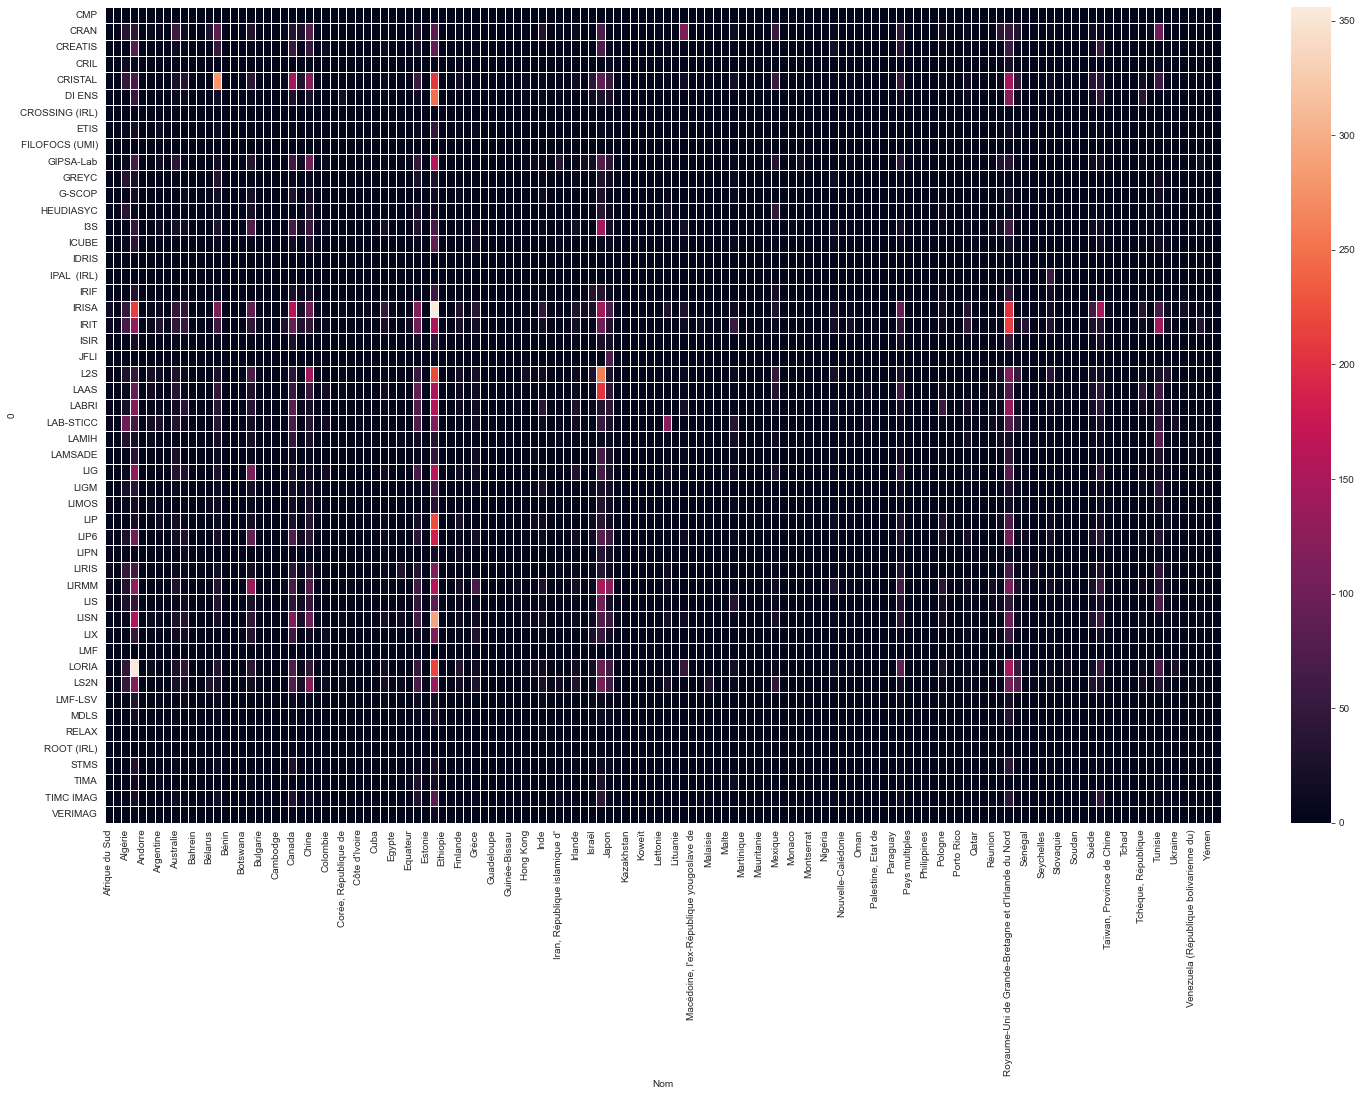

In [53]:
plt.figure(figsize=(25,15))
ax = seaborn.heatmap(evolutionLabo2, linewidths=1)

In [54]:
colonnesSup = [col for col in evolutionLabo2.columns if evolutionLabo2[col].max()<5]
print(colonnesSup)
evolutionLaboSup = evolutionLabo2.drop(colonnesSup, axis=1)
#display(evolutionLabo2)

['Albanie', 'Andorre', 'Bahrein', 'Bangladesh', 'Bénin', 'Bosnie-Herzégovine', 'Botswana', 'Cambodge', 'Chypre', 'Congo, République démocratique du', 'Cuba', 'Ethiopie', 'Fidji', 'Ghana', 'Groenland', 'Guadeloupe', 'Guinée', 'Guinée-Bissau', 'Iraq', 'Jordanie', 'Kazakhstan', 'Koweït', 'Lao, République démocratique populaire', 'Lettonie', 'Lituanie', "Macédoine, l'ex-République yougoslave de", 'Martinique', 'Maurice', 'Mauritanie', 'Mayotte', 'Moldova, République de', 'Montserrat', 'Niger', 'Nigéria', 'Oman', 'Panama', 'Paraguay', 'Pays multiples', 'Pitcairn', 'Polynésie française', 'Porto Rico', 'République arabe syrienne', 'Seychelles', 'Sri Lanka', 'Tanzanie, République unie de', 'Tchad', 'Tchécoslovaquie', 'Yémen', 'Zimbabwe']


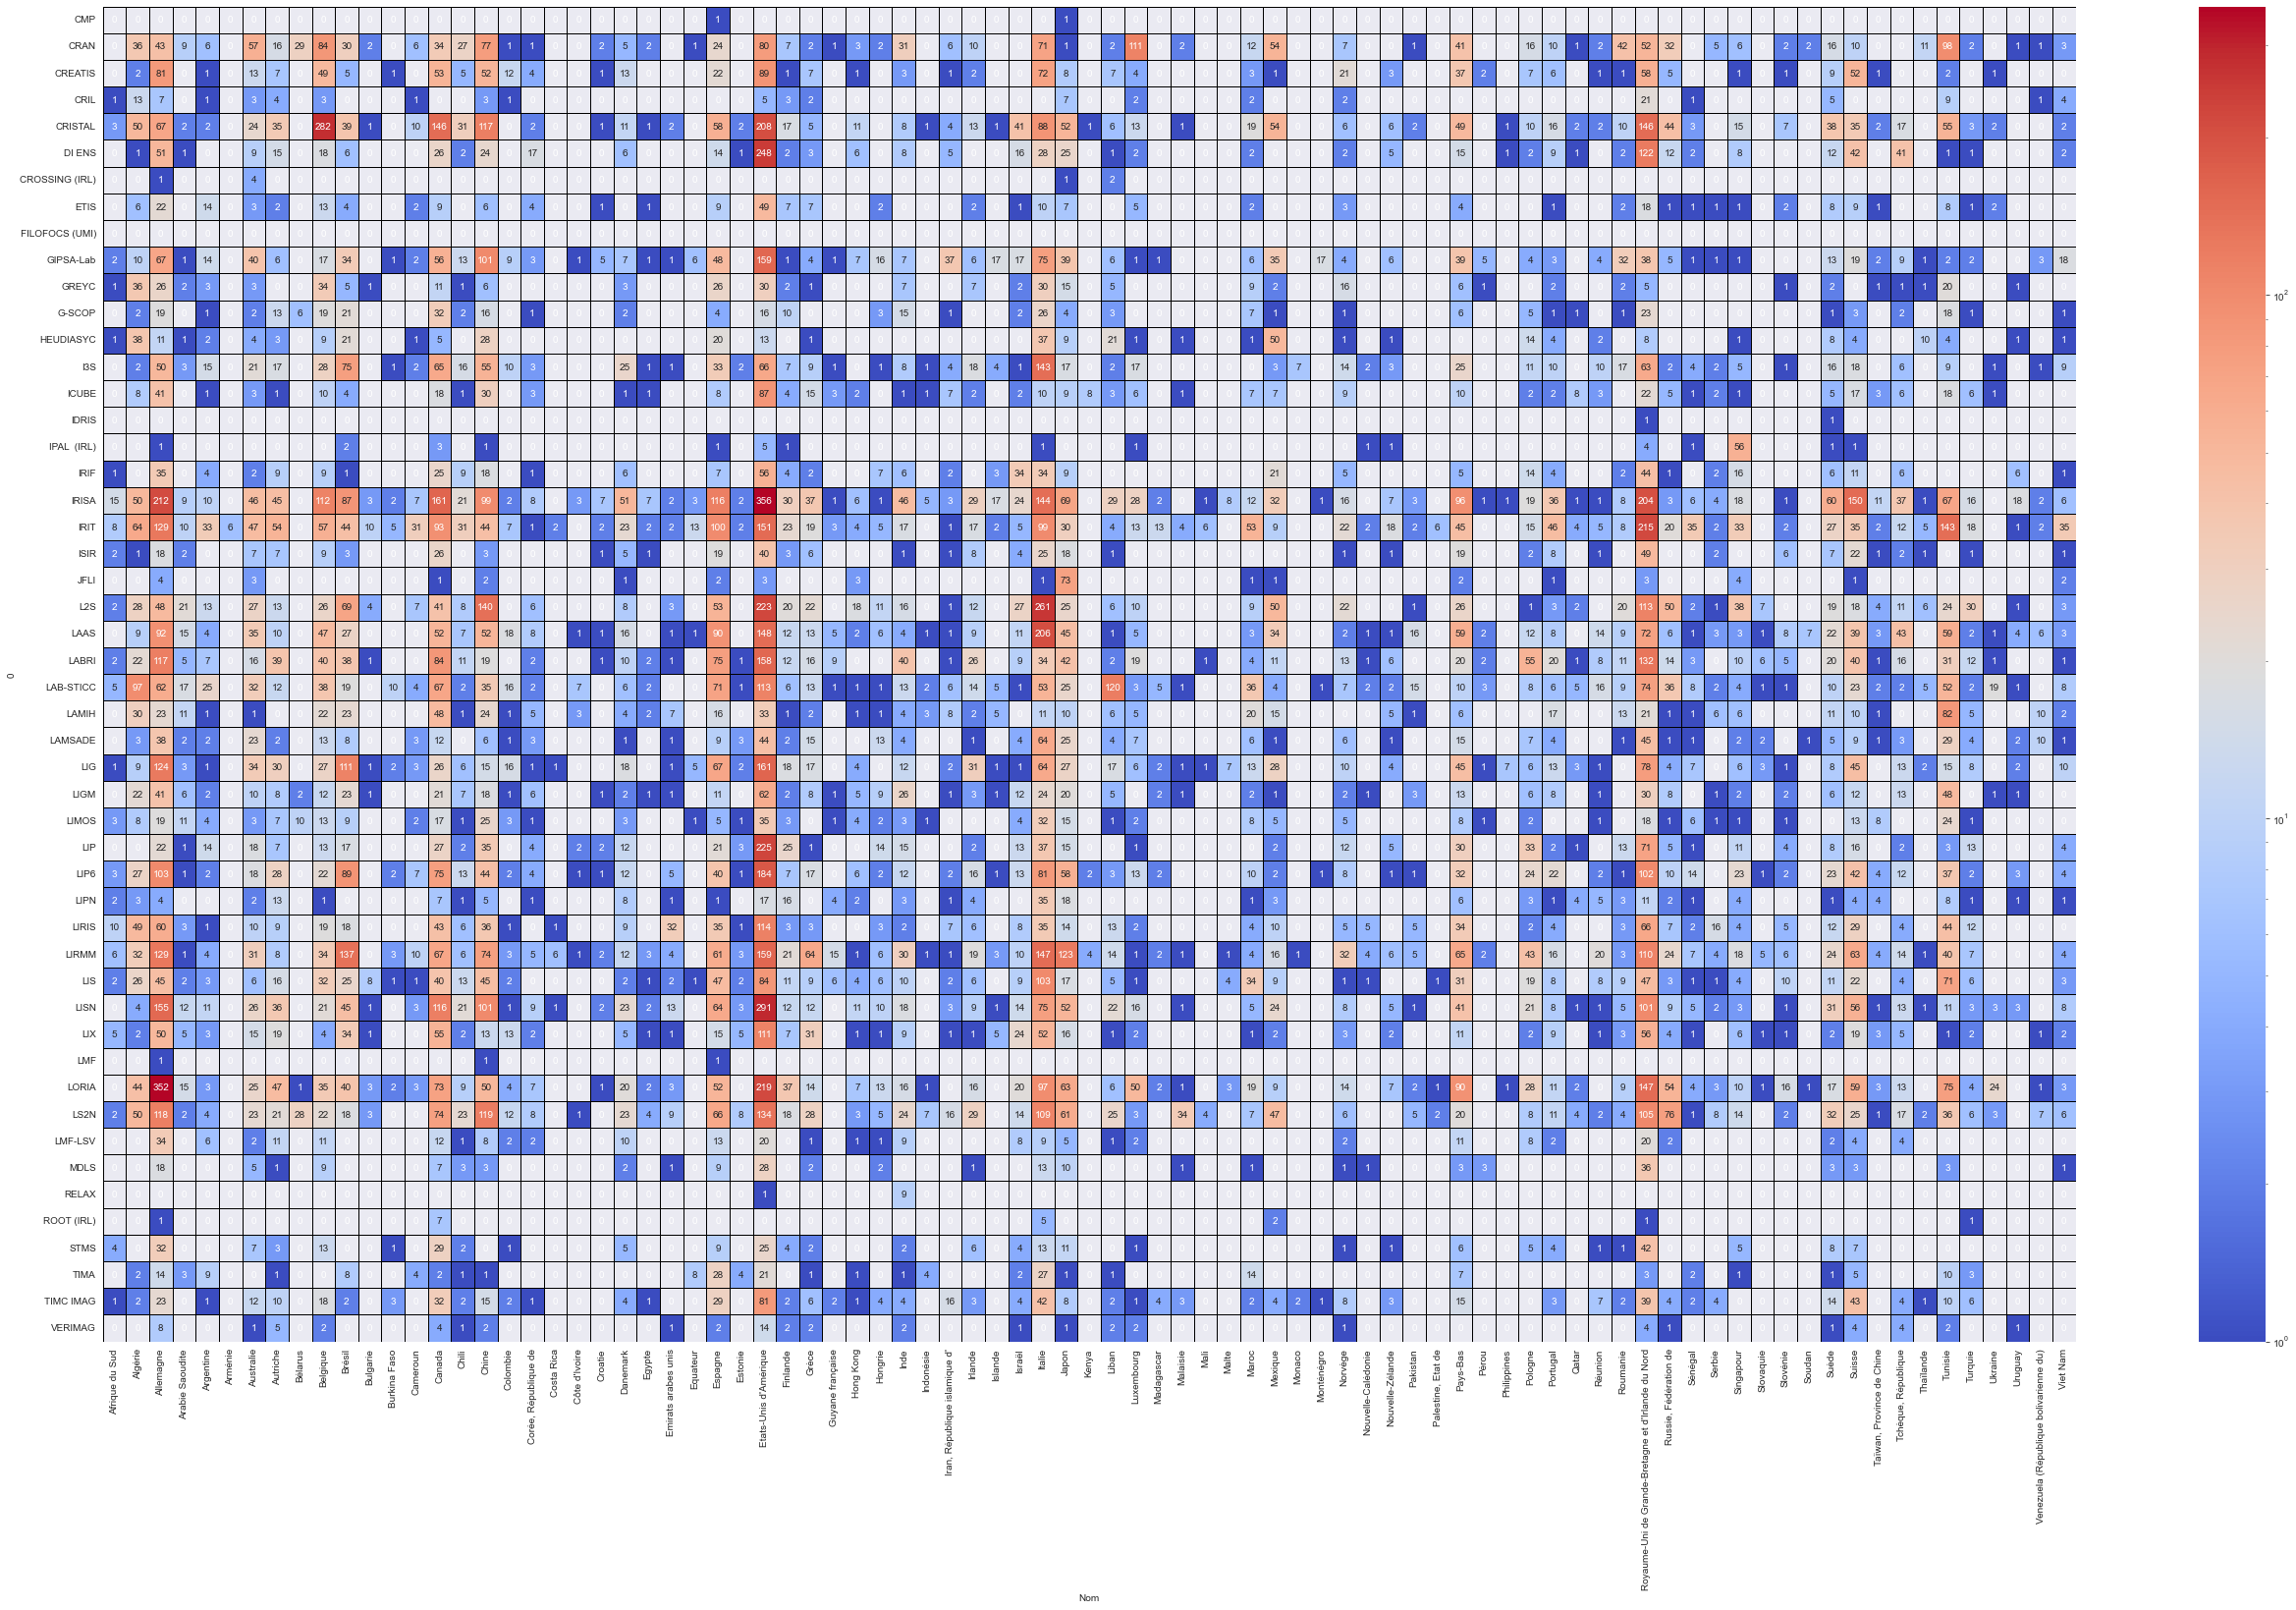

In [55]:
plt.figure(figsize=(45,25))
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator
ax = seaborn.heatmap(evolutionLaboSup, linewidths=1, linecolor='black', cmap="coolwarm", norm=LogNorm(), annot=True, fmt="d")

In [90]:
evolutionLabo2 = evolutionLabo.assign(sumHorsFR = lambda x : x.sum(axis=1) - x.FR )
#evolutionLabo.assign(sumHorsFR = lambda x : x.sum(axis=1) - x.FR)
evolutionLabo2 = evolutionLabo2.assign(propHorsFR = lambda x : x.sumHorsFR / x.FR )
#evolutionLabo["Total"] = evolutionLabo.sum(axis=1)
#display(evolutionLabo.sumFr)

In [92]:
display(evolutionLabo2)

AF  ZA  AX  AL  DZ  DE  DD  AD  AO  AI  ...  VN  VD  WF  YE  YU  ZR  \
CRAN      0   0   0   0  36  43   0   0   0   0  ...   3   0   0   0   0   0   
CRISTAL   0   4   0   0  51  76   0   0   0   0  ...   2   0   0   1   0   0   

         ZM  ZW  sumHorsFR  propHorsFR  
CRAN      0   0       1256    0.652807  
CRISTAL   0   0       2037    0.670286  

[2 rows x 260 columns]

## La liste des auteurs du LIRIS entre 2016 et 2020

In [62]:
lanceRequete("CNRS","labStructAcronym_s:LIRIS*&fq=producedDateY_i:[2016%20TO%202020]&rows=0&&facet=true&facet.field=structHasAuthId_fs&facet.prefix=2003_FacetSep_")

{
  "response": {
    "numFound": 1871,
    "start": 0,
    "docs": []
  },
  "facet_counts": {
    "facet_queries": {},
    "facet_fields": {
      "structHasAuthId_fs": [
        "2003_FacetSep_Laboratoire d'InfoRmatique en Image et Syst\u00e8mes d'information_JoinSep_674908_FacetSep_Djamal Benslimane",
        46,
        "2003_FacetSep_Laboratoire d'InfoRmatique en Image et Syst\u00e8mes d'information_JoinSep_307062_FacetSep_Christian Wolf",
        43,
        "2003_FacetSep_Laboratoire d'InfoRmatique en Image et Syst\u00e8mes d'information_JoinSep_757194_FacetSep_Samir Aknine",
        37,
        "2003_FacetSep_Laboratoire d'InfoRmatique en Image et Syst\u00e8mes d'information_JoinSep_46964_FacetSep_Guillaume Beslon",
        36,
        "2003_FacetSep_Laboratoire d'InfoRmatique en Image et Syst\u00e8mes d'information_JoinSep_1668775_FacetSep_Eric Tannier",
        32,
        "2003_FacetSep_Laboratoire d'InfoRmatique en Image et Syst\u00e8mes d'information_JoinSep_212248_FacetSep_David Coeurjolly",
        32,
        "2003_FacetSep_Laboratoire d'InfoRmatique en Image et Syst\u00e8mes d'information_JoinSep_1247523_FacetSep_Parisa Ghodous",
        30,
        "2003_FacetSep_Laboratoire d'InfoRmatique en Image et Syst\u00e8mes d'information_JoinSep_1224140_FacetSep_Noura Faci",
        29,
        "2003_FacetSep_Laboratoire d'InfoRmatique en Image et Syst\u00e8mes d'information_JoinSep_1200816_FacetSep_Angela Bonifati",
        28,
        "2003_FacetSep_Laboratoire d'InfoRmatique en Image et Syst\u00e8mes d'information_JoinSep_693447_FacetSep_Mahmoud Barhamgi",
        28,
        "2003_FacetSep_Laboratoire d'InfoRmatique en Image et Syst\u00e8mes d'information_JoinSep_1108819_FacetSep_Sonia Ben Mokhtar",
        27,
        "2003_FacetSep_Laboratoire d'InfoRmatique en Image et Syst\u00e8mes d'information_JoinSep_1011685_FacetSep_Stefan Duffner",
        26,
        "2003_FacetSep_Laboratoire d'InfoRmatique en Image et Syst\u00e8mes d'information_JoinSep_184772_FacetSep_Christine Solnon",
        26,
        "2003_FacetSep_Laboratoire d'InfoRmatique en Image et Syst\u00e8mes d'information_JoinSep_1113630_FacetSep_Mehdi Kaytoue",
        25,
        "2003_FacetSep_Laboratoire d'InfoRmatique en Image et Syst\u00e8mes d'information_JoinSep_314872_FacetSep_C\u00e9line Robardet",
        25,
        "2003_FacetSep_Laboratoire d'InfoRmatique en Image et Syst\u00e8mes d'information_JoinSep_374940_FacetSep_Youakim Badr",
        24,
        "2003_FacetSep_Laboratoire d'InfoRmatique en Image et Syst\u00e8mes d'information_JoinSep_855381_FacetSep_Liming Chen",
        24,
        "2003_FacetSep_Laboratoire d'InfoRmatique en Image et Syst\u00e8mes d'information_JoinSep_222208_FacetSep_Laure Tougne",
        23,
        "2003_FacetSep_Laboratoire d'InfoRmatique en Image et Syst\u00e8mes d'information_JoinSep_298519_FacetSep_Christophe Garcia",
        23,
        "2003_FacetSep_Laboratoire d'InfoRmatique en Image et Syst\u00e8mes d'information_JoinSep_620262_FacetSep_Chirine Ghedira",
        23,
        "2003_FacetSep_Laboratoire d'InfoRmatique en Image et Syst\u00e8mes d'information_JoinSep_795840_FacetSep_Sara Bouchenak",
        23,
        "2003_FacetSep_Laboratoire d'InfoRmatique en Image et Syst\u00e8mes d'information_JoinSep_1164964_FacetSep_Elise Lavou\u00e9",
        21,
        "2003_FacetSep_Laboratoire d'InfoRmatique en Image et Syst\u00e8mes d'information_JoinSep_167613_FacetSep_Sylvie Servigne",
        21,
        "2003_FacetSep_Laboratoire d'InfoRmatique en Image et Syst\u00e8mes d'information_JoinSep_195084_FacetSep_La\u00ebtitia Matignon",
        21,
        "2003_FacetSep_Laboratoire d'InfoRmatique en Image et Syst\u00e8mes d'information_JoinSep_206969_FacetSep_Hamamache Kheddouci",
        21,
        "2003_FacetSep_Laboratoire d'InfoRmatique en Image et Syst\u00e8mes d'information_JoinSep_439784_FacetSep_Christophe Rigotti",
        21,
        "2003_FacetSep_Laboratoire d'InfoRmatique en Image et Syst\u00e8

In [63]:
lanceRequete("CNRS","labStructAcronym_s:LIRIS*&fq=producedDateY_i:[2016%20TO%202020]&facet=true&facet.pivot=submitType_s,authIdHasPrimaryStructure_fs&rows=0&wt=json")

{
  "response": {
    "numFound": 1871,
    "start": 0,
    "docs": []
  },
  "facet_counts": {
    "facet_queries": {},
    "facet_fields": {},
    "facet_ranges": {},
    "facet_intervals": {},
    "facet_heatmaps": {},
    "facet_pivot": {
      "submitType_s,authIdHasPrimaryStructure_fs": [
        {
          "field": "submitType_s",
          "value": "file",
          "count": 1083,
          "pivot": [
            {
              "field": "authIdHasPrimaryStructure_fs",
              "value": "46964_FacetSep_Guillaume Beslon_JoinSep_160051_FacetSep_Artificial Evolution and Computational Biology",
              "count": 32
            },
            {
              "field": "authIdHasPrimaryStructure_fs",
              "value": "46964_FacetSep_Guillaume Beslon_JoinSep_2003_FacetSep_Laboratoire d'InfoRmatique en Image et Syst\u00e8mes d'information",
              "count": 30
            },
            {
              "field": "authIdHasPrimaryStructure_fs",
              "value": "1108819_FacetSep_Sonia Ben Mokhtar_JoinSep_394737_FacetSep_Distribution, Recherche d'Information et Mobilit\u00e9",
              "count": 24
            },
            {
              "field": "authIdHasPrimaryStructure_fs",
              "value": "1113630_FacetSep_Mehdi Kaytoue_JoinSep_413086_FacetSep_Data Mining and Machine Learning",
              "count": 24
            },
            {
              "field": "authIdHasPrimaryStructure_fs",
              "value": "1668775_FacetSep_Eric Tannier_JoinSep_160051_FacetSep_Artificial Evolution and Computational Biology",
              "count": 24
            },
            {
              "field": "authIdHasPrimaryStructure_fs",
              "value": "1011685_FacetSep_Stefan Duffner_JoinSep_403930_FacetSep_Extraction de Caract\u00e9ristiques et Identification",
              "count": 23
            },
            {
              "field": "authIdHasPrimaryStructure_fs",
              "value": "307062_FacetSep_Christian Wolf_JoinSep_403930_FacetSep_Extraction de Caract\u00e9ristiques et Identification",
              "count": 23
            },
            {
              "field": "authIdHasPrimaryStructure_fs",
              "value": "184772_FacetSep_Christine Solnon_JoinSep_391965_FacetSep_Geometry Processing and Constrained Optimization",
              "count": 22
            },
            {
              "field": "authIdHasPrimaryStructure_fs",
              "value": "1247523_FacetSep_Parisa Ghodous_JoinSep_393309_FacetSep_Service Oriented Computing",
              "count": 18
            },
            {
              "field": "authIdHasPrimaryStructure_fs",
              "value": "212248_FacetSep_David Coeurjolly_JoinSep_391965_FacetSep_Geometry Processing and Constrained Optimization",
              "count": 18
            },
            {
              "field": "authIdHasPrimaryStructure_fs",
              "value": "1164964_FacetSep_Elise Lavou\u00e9_JoinSep_413091_FacetSep_Situated Interaction, Collaboration, Adaptation and Learning",
              "count": 17
            },
            {
              "field": "authIdHasPrimaryStructure_fs",
              "value": "531974_FacetSep_Marc Plantevit_JoinSep_413086_FacetSep_Data Mining and Machine Learning",
              "count": 17
            },
            {
              "field": "authIdHasPrimaryStructure_fs",
              "value": "908599_FacetSep_Aur\u00e9lien Tabard_JoinSep_413091_FacetSep_Situated Interaction, Collaboration, Adaptation and Learning",
              "count": 17
            },
            {
              "field": "authIdHasPrimaryStructure_fs",
              "value": "167613_FacetSep_Sylvie Servigne_JoinSep_401125_FacetSep_Base de Donn\u00e9es",
              "count": 16
            },
            {
              "field": "authIdHasPrimaryStructure_fs",
              "value": "1170678_FacetSep_St\u00e9phane Derrode_JoinSep_403930_FacetSep_Extraction de Caract\u00e9ristiques et Identification",
              "count":